# Data Loading

In [8]:
import pandas as pd

dir = "data"
artificial_train = pd.read_fwf(dir+"/artificial_train.data", header=None)
artificial_train_labels = pd.read_fwf(dir+"/artificial_train.labels", header=None)

artificial_train.columns = [f'{col}_col' for col in artificial_train.columns]
artificial_train = pd.concat([artificial_train, artificial_train_labels], axis=1)
artificial_train.rename(columns={0: 'label'}, inplace=True)
artificial_test = pd.read_fwf(dir+"/artificial_test.data", header=None)
artificial_test.columns = [f'{col}_col' for col in artificial_test.columns]

# There was a problem with row 577 in train data so we drop it
artificial_train.drop(577, inplace=True)

for column in artificial_train.iloc[:, :-1]:
    artificial_train[column] = artificial_train[column].astype('int')
    artificial_test[column] = artificial_test[column].astype('int')

# EDA

In [3]:
artificial_train.head()

,0_col,1_col,2_col,3_col,4_col,5_col,6_col,7_col,8_col,9_col,...,491_col,492_col,493_col,494_col,495_col,496_col,497_col,498_col,499_col,label
0,485,477,537,479,452,471,491,476,475,473,...,481,477,485,511,485,481,479,475,496,-1
1,483,458,460,487,587,475,526,479,485,469,...,478,487,338,513,486,483,492,510,517,-1
2,487,542,499,468,448,471,442,478,480,477,...,481,492,650,506,501,480,489,499,498,-1
3,480,491,510,485,495,472,417,474,502,476,...,480,474,572,454,469,475,482,494,461,1
4,484,502,528,489,466,481,402,478,487,468,...,479,452,435,486,508,481,504,495,511,1


In [4]:
artificial_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1999 entries, 0 to 1999
Columns: 501 entries, 0_col to label
dtypes: int64(501)
memory usage: 7.7 MB


In [5]:
artificial_train.describe()

,0_col,1_col,2_col,3_col,4_col,5_col,6_col,7_col,8_col,9_col,...,491_col,492_col,493_col,494_col,495_col,496_col,497_col,498_col,499_col,label
count,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,...,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.00000
mean,481.721861,483.432216,510.144572,483.390195,501.624812,479.264132,480.131066,476.565283,486.785893,478.786393,...,478.210105,485.709855,496.103052,492.890445,510.183092,477.622811,482.708854,507.283142,489.630815,0.00050
std,6.423312,30.180211,38.897090,9.058581,41.396110,6.793778,40.574612,1.384750,15.043753,7.191774,...,16.042233,29.280082,128.458783,38.184966,41.313100,16.695045,20.703065,41.337231,31.089586,1.00025
min,462.000000,381.000000,370.000000,453.000000,371.000000,459.000000,334.000000,471.000000,430.000000,455.000000,...,74.000000,21.000000,31.000000,82.000000,53.000000,67.000000,76.000000,22.000000,5.000000,-1.00000
25%,477.000000,464.000000,485.000000,477.000000,475.000000,475.000000,453.000000,476.000000,477.000000,474.000000,...,476.000000,471.000000,404.000000,469.500000,485.500000,474.000000,474.000000,482.000000,473.000000,-1.00000
50%,482.000000,483.000000,510.000000,483.000000,500.000000,479.000000,480.000000,477.000000,487.000000,479.000000,...,479.000000,486.000000,502.000000,492.000000,511.000000,478.000000,483.000000,508.000000,490.000000,1.00000
75%,486.000000,503.000000,536.000000,490.000000,528.000000,484.000000,506.500000,477.000000,496.000000,484.000000,...,481.000000,502.000000,586.000000,517.000000,535.000000,482.000000,492.000000,533.000000,507.500000,1.00000
max,503.000000,600.000000,654.000000,519.000000,688.000000,505.000000,611.000000,481.000000,536.000000,503.000000,...,497.000000,566.000000,920.000000,615.000000,661.000000,500.000000,535.000000,644.000000,583.000000,1.00000


In [6]:
artificial_train.isna().sum().sort_values(ascending=False)

0_col      0
330_col    0
343_col    0
342_col    0
341_col    0
          ..
162_col    0
161_col    0
160_col    0
159_col    0
label      0
Length: 501, dtype: int64

There was no missing data

In [7]:
artificial_train["label"].value_counts()

 1    1000
-1     999
Name: label, dtype: int64

Classes are balanced

# Select columns

* RFE to select 120 columns from 500
* Hyperparameter search
* RFE to select 30 from 120
* Hyperparameter search
* Final 15-20 columns from 30


## RFE on LightGBM

In [9]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score
import numpy as np
from sklearn.feature_selection import RFE

def select_features_RFE(X: pd.DataFrame, y: pd.Series, model, n_features_to_select: int=45, step: int=3):
    """
    Function selects features using RFE
    :param X: train data
    :param y: train labels
    :param model: model to use
    :param n_features_to_select: number of features to select
    :param step: step
    :return: train data with selected features
    """
    rfe = RFE(model, n_features_to_select=n_features_to_select, step=step)
    rfe = rfe.fit(X, y)
    return X[X.columns[rfe.support_]]

def kfold(X, y, model, num_folds: int, metric: callable = balanced_accuracy_score, random_state: int=42):
    """
    Function performs kfold cross validation
    :param X: train data
    :param y: train labels
    :param model: model to use
    :param num_folds: number of folds
    :param metric: metric to use
    :param random_state: random state
    :return: train and test metric
    """
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)

    metric_train = []
    metric_test = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        metric_train.append(metric(y_train, y_train_pred))
        metric_test.append(metric(y_test, y_test_pred))
    metric_train = np.array(metric_train)
    metric_test = np.array(metric_test)

    return metric_train, metric_test


def objective_lightgbm(trial, X, y, metric, random_state=42):
    """
    Function performs hyperparameter optimization for lightgbm
    :param trial: optuna trial
    :param X: train data
    :param y: train labels
    :param metric: metric to use
    :param random_state: random state
    :return: metric value
    """

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    model = lgb.LGBMClassifier(**param, random_state=random_state)
    metric_train, metric_test = kfold(X, y, model, num_folds=5, metric=metric, random_state=random_state)
    return metric_test.mean()

## Choosing best 30 columns

In [10]:
from functools import partial
import optuna
import warnings
warnings.filterwarnings('ignore')

random_state=42
validation_scores = {}

# 500 columns
lgbm = lgb.LGBMClassifier(random_state=random_state, verbose=-1)
X = artificial_train.drop(['label'], axis=1)
y = artificial_train['label']

## tune for 500 columns
study = optuna.create_study(direction='maximize')
study.optimize(partial(objective_lightgbm, X=X, y=y, metric=balanced_accuracy_score, random_state=random_state), n_trials=10)
lgbm = lgb.LGBMClassifier(**study.best_params, random_state=random_state)

## validate for 500 columns
validation_scores['500'] = kfold(X, y, lgbm, num_folds=5, metric=balanced_accuracy_score, random_state=random_state)[1]
print("Validation for 500 columns: ", validation_scores['500'])

# Select 120 columns
X = select_features_RFE(X, y, lgbm, n_features_to_select=120, step=3)

## tune for 120 columns
study = optuna.create_study(direction='maximize')
study.optimize(partial(objective_lightgbm, X=X, y=y, metric=balanced_accuracy_score, random_state=random_state), n_trials=25)
lgbm = lgb.LGBMClassifier(**study.best_params, random_state=random_state)

## validate for 120 columns
validation_scores['120'] = kfold(X, y, lgbm, num_folds=5, metric=balanced_accuracy_score, random_state=random_state)[1]
print("Validation for 120 columns: ", validation_scores['120'])

# Select 45 columns
X = select_features_RFE(X, y, lgbm, n_features_to_select=45, step=2)

## tune for 45 columns
study = optuna.create_study(direction='maximize')
study.optimize(partial(objective_lightgbm, X=X, y=y, metric=balanced_accuracy_score, random_state=random_state), n_trials=40)
lgbm = lgb.LGBMClassifier(**study.best_params, random_state=random_state)

## validate for 45 columns
validation_scores['45'] = kfold(X, y, lgbm, num_folds=5, metric=balanced_accuracy_score, random_state=random_state)[1]
print("Validation for 45 columns: ", validation_scores['45'])

# Select 30 columns
X = select_features_RFE(X, y, lgbm, n_features_to_select=30, step=1)

## tune for 30 columns
study = optuna.create_study(direction='maximize')
study.optimize(partial(objective_lightgbm, X=X, y=y, metric=balanced_accuracy_score, random_state=random_state), n_trials=60)
lgbm = lgb.LGBMClassifier(**study.best_params, random_state=random_state)

## validate for 30 columns
validation_scores['30'] = kfold(X, y, lgbm, num_folds=5, metric=balanced_accuracy_score, random_state=random_state)[1]
print("Validation for 30 columns: ", validation_scores['30'])


d:\Python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-01-16 17:26:47,597] A new study created in memory with name: no-name-045c8ed8-8ffb-4f35-a918-2da9309dc391


[LightGBM] [Warning] feature_fraction is set=0.8759745462125081, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8759745462125081
[LightGBM] [Warning] bagging_fraction is set=0.8263213910976093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8263213910976093
[LightGBM] [Warning] lambda_l1 is set=0.04554028046257063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04554028046257063
[LightGBM] [Warning] lambda_l2 is set=3.6641721771487206e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6641721771487206e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8759745462125081, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8759745462125081
[LightGBM] [Warning] bagging_fraction is set=0.8263213910976093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8263213910976093
[LightGBM] [W

[I 2024-01-16 17:26:51,482] Trial 0 finished with value: 0.7695472799323679 and parameters: {'lambda_l1': 0.04554028046257063, 'lambda_l2': 3.6641721771487206e-05, 'num_leaves': 95, 'feature_fraction': 0.8759745462125081, 'bagging_fraction': 0.8263213910976093, 'bagging_freq': 3, 'min_child_samples': 34}. Best is trial 0 with value: 0.7695472799323679.


[LightGBM] [Warning] feature_fraction is set=0.783975811537372, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.783975811537372
[LightGBM] [Warning] bagging_fraction is set=0.7783399241418851, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7783399241418851
[LightGBM] [Warning] lambda_l1 is set=2.486386173816641e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.486386173816641e-06
[LightGBM] [Warning] lambda_l2 is set=0.001014785308627736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001014785308627736
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.783975811537372, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.783975811537372
[LightGBM] [Warning] bagging_fraction is set=0.7783399241418851, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7783399241418851
[LightGBM] [Warni

[I 2024-01-16 17:26:54,380] Trial 1 finished with value: 0.7530756097676553 and parameters: {'lambda_l1': 2.486386173816641e-06, 'lambda_l2': 0.001014785308627736, 'num_leaves': 21, 'feature_fraction': 0.783975811537372, 'bagging_fraction': 0.7783399241418851, 'bagging_freq': 7, 'min_child_samples': 32}. Best is trial 0 with value: 0.7695472799323679.


[LightGBM] [Warning] feature_fraction is set=0.8231475532244277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8231475532244277
[LightGBM] [Warning] bagging_fraction is set=0.8126122735793109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8126122735793109
[LightGBM] [Warning] lambda_l1 is set=7.80666929832264, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.80666929832264
[LightGBM] [Warning] lambda_l2 is set=0.0011478192811436847, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011478192811436847
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8231475532244277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8231475532244277
[LightGBM] [Warning] bagging_fraction is set=0.8126122735793109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8126122735793109
[LightGBM] [Warning] 

[I 2024-01-16 17:26:56,362] Trial 2 finished with value: 0.7424300225008024 and parameters: {'lambda_l1': 7.80666929832264, 'lambda_l2': 0.0011478192811436847, 'num_leaves': 147, 'feature_fraction': 0.8231475532244277, 'bagging_fraction': 0.8126122735793109, 'bagging_freq': 5, 'min_child_samples': 53}. Best is trial 0 with value: 0.7695472799323679.


[LightGBM] [Warning] feature_fraction is set=0.84841190406556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.84841190406556
[LightGBM] [Warning] bagging_fraction is set=0.4872057897036397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4872057897036397
[LightGBM] [Warning] lambda_l1 is set=0.02382942843749373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02382942843749373
[LightGBM] [Warning] lambda_l2 is set=0.0028309645232744277, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0028309645232744277
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.84841190406556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.84841190406556
[LightGBM] [Warning] bagging_fraction is set=0.4872057897036397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4872057897036397
[LightGBM] [Warning] la

[I 2024-01-16 17:26:58,374] Trial 3 finished with value: 0.6870509883885969 and parameters: {'lambda_l1': 0.02382942843749373, 'lambda_l2': 0.0028309645232744277, 'num_leaves': 81, 'feature_fraction': 0.84841190406556, 'bagging_fraction': 0.4872057897036397, 'bagging_freq': 3, 'min_child_samples': 44}. Best is trial 0 with value: 0.7695472799323679.


[LightGBM] [Warning] feature_fraction is set=0.4705932416047566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4705932416047566
[LightGBM] [Warning] bagging_fraction is set=0.5221464041500792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5221464041500792
[LightGBM] [Warning] lambda_l1 is set=7.612618914195685e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.612618914195685e-05
[LightGBM] [Warning] lambda_l2 is set=1.0627156837455551e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0627156837455551e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4705932416047566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4705932416047566
[LightGBM] [Warning] bagging_fraction is set=0.5221464041500792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5221464041500792
[LightGBM

[I 2024-01-16 17:26:59,660] Trial 4 finished with value: 0.6772404035527235 and parameters: {'lambda_l1': 7.612618914195685e-05, 'lambda_l2': 1.0627156837455551e-05, 'num_leaves': 62, 'feature_fraction': 0.4705932416047566, 'bagging_fraction': 0.5221464041500792, 'bagging_freq': 7, 'min_child_samples': 71}. Best is trial 0 with value: 0.7695472799323679.


[LightGBM] [Warning] feature_fraction is set=0.8205899315281755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8205899315281755
[LightGBM] [Warning] bagging_fraction is set=0.433412075307148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.433412075307148
[LightGBM] [Warning] lambda_l1 is set=5.846116927941077e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.846116927941077e-08
[LightGBM] [Warning] lambda_l2 is set=4.862614282055625e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.862614282055625e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8205899315281755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8205899315281755
[LightGBM] [Warning] bagging_fraction is set=0.433412075307148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.433412075307148
[LightGBM] [War

[I 2024-01-16 17:27:01,351] Trial 5 finished with value: 0.6481475798802051 and parameters: {'lambda_l1': 5.846116927941077e-08, 'lambda_l2': 4.862614282055625e-05, 'num_leaves': 230, 'feature_fraction': 0.8205899315281755, 'bagging_fraction': 0.433412075307148, 'bagging_freq': 1, 'min_child_samples': 79}. Best is trial 0 with value: 0.7695472799323679.


[LightGBM] [Warning] feature_fraction is set=0.6196575417824228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6196575417824228
[LightGBM] [Warning] bagging_fraction is set=0.5422986999369881, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5422986999369881
[LightGBM] [Warning] lambda_l1 is set=0.00033972818441260636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00033972818441260636
[LightGBM] [Warning] lambda_l2 is set=7.722935345798544e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.722935345798544e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6196575417824228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6196575417824228
[LightGBM] [Warning] bagging_fraction is set=0.5422986999369881, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5422986999369881
[LightGBM

[I 2024-01-16 17:27:02,973] Trial 6 finished with value: 0.6706166770334561 and parameters: {'lambda_l1': 0.00033972818441260636, 'lambda_l2': 7.722935345798544e-06, 'num_leaves': 74, 'feature_fraction': 0.6196575417824228, 'bagging_fraction': 0.5422986999369881, 'bagging_freq': 1, 'min_child_samples': 83}. Best is trial 0 with value: 0.7695472799323679.


[LightGBM] [Warning] feature_fraction is set=0.819723923124215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.819723923124215
[LightGBM] [Warning] bagging_fraction is set=0.5476885729745747, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5476885729745747
[LightGBM] [Warning] lambda_l1 is set=1.5217744139203513e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5217744139203513e-05
[LightGBM] [Warning] lambda_l2 is set=4.671857428914054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.671857428914054
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.819723923124215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.819723923124215
[LightGBM] [Warning] bagging_fraction is set=0.5476885729745747, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5476885729745747
[LightGBM] [Warning] 

[I 2024-01-16 17:27:05,831] Trial 7 finished with value: 0.7027118433023614 and parameters: {'lambda_l1': 1.5217744139203513e-05, 'lambda_l2': 4.671857428914054, 'num_leaves': 177, 'feature_fraction': 0.819723923124215, 'bagging_fraction': 0.5476885729745747, 'bagging_freq': 2, 'min_child_samples': 32}. Best is trial 0 with value: 0.7695472799323679.


[LightGBM] [Warning] feature_fraction is set=0.8426803104877556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8426803104877556
[LightGBM] [Warning] bagging_fraction is set=0.9922351635370092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9922351635370092
[LightGBM] [Warning] lambda_l1 is set=9.784198373050754e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.784198373050754e-08
[LightGBM] [Warning] lambda_l2 is set=1.011004913168852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.011004913168852
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8426803104877556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8426803104877556
[LightGBM] [Warning] bagging_fraction is set=0.9922351635370092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9922351635370092
[LightGBM] [Warning

[I 2024-01-16 17:27:16,520] Trial 8 finished with value: 0.8231157204803384 and parameters: {'lambda_l1': 9.784198373050754e-08, 'lambda_l2': 1.011004913168852, 'num_leaves': 90, 'feature_fraction': 0.8426803104877556, 'bagging_fraction': 0.9922351635370092, 'bagging_freq': 5, 'min_child_samples': 6}. Best is trial 8 with value: 0.8231157204803384.


[LightGBM] [Warning] feature_fraction is set=0.46131683913309646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46131683913309646
[LightGBM] [Warning] bagging_fraction is set=0.44241315643588175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44241315643588175
[LightGBM] [Warning] lambda_l1 is set=0.1443045902913688, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1443045902913688
[LightGBM] [Warning] lambda_l2 is set=0.01670656129448182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01670656129448182
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.46131683913309646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46131683913309646
[LightGBM] [Warning] bagging_fraction is set=0.44241315643588175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44241315643588175
[LightGBM] [W

[I 2024-01-16 17:27:19,956] Trial 9 finished with value: 0.6759647616300193 and parameters: {'lambda_l1': 0.1443045902913688, 'lambda_l2': 0.01670656129448182, 'num_leaves': 165, 'feature_fraction': 0.46131683913309646, 'bagging_fraction': 0.44241315643588175, 'bagging_freq': 2, 'min_child_samples': 42}. Best is trial 8 with value: 0.8231157204803384.


[LightGBM] [Warning] feature_fraction is set=0.8426803104877556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8426803104877556
[LightGBM] [Warning] bagging_fraction is set=0.9922351635370092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9922351635370092
[LightGBM] [Warning] lambda_l1 is set=9.784198373050754e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.784198373050754e-08
[LightGBM] [Warning] lambda_l2 is set=1.011004913168852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.011004913168852
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8426803104877556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8426803104877556
[LightGBM] [Warning] bagging_fraction is set=0.9922351635370092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9922351635370092
[LightGBM] [Warning

[I 2024-01-16 17:40:59,016] A new study created in memory with name: no-name-802d9104-561e-499c-ae82-d2dbcd1e628b


[LightGBM] [Warning] feature_fraction is set=0.9240491690658208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9240491690658208
[LightGBM] [Warning] bagging_fraction is set=0.8748751333774929, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8748751333774929
[LightGBM] [Warning] lambda_l1 is set=4.67071780216229e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.67071780216229e-07
[LightGBM] [Warning] lambda_l2 is set=2.690534909363801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.690534909363801
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9240491690658208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9240491690658208
[LightGBM] [Warning] bagging_fraction is set=0.8748751333774929, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8748751333774929
[LightGBM] [Warning] 

[I 2024-01-16 17:41:03,969] Trial 0 finished with value: 0.7860743199186884 and parameters: {'lambda_l1': 4.67071780216229e-07, 'lambda_l2': 2.690534909363801, 'num_leaves': 180, 'feature_fraction': 0.9240491690658208, 'bagging_fraction': 0.8748751333774929, 'bagging_freq': 4, 'min_child_samples': 69}. Best is trial 0 with value: 0.7860743199186884.


[LightGBM] [Warning] feature_fraction is set=0.9781906212368102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9781906212368102
[LightGBM] [Warning] bagging_fraction is set=0.40848373682162403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40848373682162403
[LightGBM] [Warning] lambda_l1 is set=0.007472166680525332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007472166680525332
[LightGBM] [Warning] lambda_l2 is set=1.555336524613235e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.555336524613235e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9781906212368102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9781906212368102
[LightGBM] [Warning] bagging_fraction is set=0.40848373682162403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40848373682162403
[LightGBM

[I 2024-01-16 17:41:06,044] Trial 1 finished with value: 0.6815999151526422 and parameters: {'lambda_l1': 0.007472166680525332, 'lambda_l2': 1.555336524613235e-05, 'num_leaves': 96, 'feature_fraction': 0.9781906212368102, 'bagging_fraction': 0.40848373682162403, 'bagging_freq': 4, 'min_child_samples': 91}. Best is trial 0 with value: 0.7860743199186884.


[LightGBM] [Warning] feature_fraction is set=0.8959521958940074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8959521958940074
[LightGBM] [Warning] bagging_fraction is set=0.918920900462919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.918920900462919
[LightGBM] [Warning] lambda_l1 is set=0.5868104412037553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5868104412037553
[LightGBM] [Warning] lambda_l2 is set=1.682328760989389e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.682328760989389e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8959521958940074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8959521958940074
[LightGBM] [Warning] bagging_fraction is set=0.918920900462919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.918920900462919
[LightGBM] [Warning] 

[I 2024-01-16 17:41:11,631] Trial 2 finished with value: 0.8198856453327934 and parameters: {'lambda_l1': 0.5868104412037553, 'lambda_l2': 1.682328760989389e-08, 'num_leaves': 228, 'feature_fraction': 0.8959521958940074, 'bagging_fraction': 0.918920900462919, 'bagging_freq': 3, 'min_child_samples': 38}. Best is trial 2 with value: 0.8198856453327934.


[LightGBM] [Warning] feature_fraction is set=0.9467421753813864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9467421753813864
[LightGBM] [Warning] bagging_fraction is set=0.6846825286275962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6846825286275962
[LightGBM] [Warning] lambda_l1 is set=9.249036924568743e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.249036924568743e-06
[LightGBM] [Warning] lambda_l2 is set=0.10759254140944782, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10759254140944782
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9467421753813864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9467421753813864
[LightGBM] [Warning] bagging_fraction is set=0.6846825286275962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6846825286275962
[LightGBM] [War

[I 2024-01-16 17:41:23,459] Trial 3 finished with value: 0.7973692077495695 and parameters: {'lambda_l1': 9.249036924568743e-06, 'lambda_l2': 0.10759254140944782, 'num_leaves': 159, 'feature_fraction': 0.9467421753813864, 'bagging_fraction': 0.6846825286275962, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 2 with value: 0.8198856453327934.


[LightGBM] [Warning] feature_fraction is set=0.6997923806036594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6997923806036594
[LightGBM] [Warning] bagging_fraction is set=0.5718557730871683, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5718557730871683
[LightGBM] [Warning] lambda_l1 is set=5.984870413436602e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.984870413436602e-08
[LightGBM] [Warning] lambda_l2 is set=0.0008762373267617766, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008762373267617766
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6997923806036594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6997923806036594
[LightGBM] [Warning] bagging_fraction is set=0.5718557730871683, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5718557730871683
[LightGBM] 

[I 2024-01-16 17:41:27,020] Trial 4 finished with value: 0.7503633662212251 and parameters: {'lambda_l1': 5.984870413436602e-08, 'lambda_l2': 0.0008762373267617766, 'num_leaves': 33, 'feature_fraction': 0.6997923806036594, 'bagging_fraction': 0.5718557730871683, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 2 with value: 0.8198856453327934.


[LightGBM] [Warning] feature_fraction is set=0.7276650841410319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7276650841410319
[LightGBM] [Warning] bagging_fraction is set=0.8601996272318648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8601996272318648
[LightGBM] [Warning] lambda_l1 is set=1.7395686663822005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7395686663822005
[LightGBM] [Warning] lambda_l2 is set=4.535969973934429e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.535969973934429e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7276650841410319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7276650841410319
[LightGBM] [Warning] bagging_fraction is set=0.8601996272318648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8601996272318648
[LightGBM] [Warni

[I 2024-01-16 17:41:31,251] Trial 5 finished with value: 0.8104525976782039 and parameters: {'lambda_l1': 1.7395686663822005, 'lambda_l2': 4.535969973934429e-06, 'num_leaves': 59, 'feature_fraction': 0.7276650841410319, 'bagging_fraction': 0.8601996272318648, 'bagging_freq': 5, 'min_child_samples': 36}. Best is trial 2 with value: 0.8198856453327934.


[LightGBM] [Warning] feature_fraction is set=0.9614275938306729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9614275938306729
[LightGBM] [Warning] bagging_fraction is set=0.8268401220670285, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8268401220670285
[LightGBM] [Warning] lambda_l1 is set=0.00012533587875762384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012533587875762384
[LightGBM] [Warning] lambda_l2 is set=1.6999678977188708e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6999678977188708e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9614275938306729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9614275938306729
[LightGBM] [Warning] bagging_fraction is set=0.8268401220670285, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8268401220670285
[LightG

[I 2024-01-16 17:41:35,034] Trial 6 finished with value: 0.7624127646143245 and parameters: {'lambda_l1': 0.00012533587875762384, 'lambda_l2': 1.6999678977188708e-07, 'num_leaves': 79, 'feature_fraction': 0.9614275938306729, 'bagging_fraction': 0.8268401220670285, 'bagging_freq': 5, 'min_child_samples': 82}. Best is trial 2 with value: 0.8198856453327934.


[LightGBM] [Warning] feature_fraction is set=0.758872062161768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.758872062161768
[LightGBM] [Warning] bagging_fraction is set=0.9546764766268342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9546764766268342
[LightGBM] [Warning] lambda_l1 is set=0.1601890604019716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1601890604019716
[LightGBM] [Warning] lambda_l2 is set=3.832139526015877e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.832139526015877e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.758872062161768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.758872062161768
[LightGBM] [Warning] bagging_fraction is set=0.9546764766268342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9546764766268342
[LightGBM] [Warning] 

[I 2024-01-16 17:41:38,625] Trial 7 finished with value: 0.783284719702211 and parameters: {'lambda_l1': 0.1601890604019716, 'lambda_l2': 3.832139526015877e-05, 'num_leaves': 67, 'feature_fraction': 0.758872062161768, 'bagging_fraction': 0.9546764766268342, 'bagging_freq': 1, 'min_child_samples': 84}. Best is trial 2 with value: 0.8198856453327934.


[LightGBM] [Warning] feature_fraction is set=0.604976649557951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.604976649557951
[LightGBM] [Warning] bagging_fraction is set=0.4718540389408421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4718540389408421
[LightGBM] [Warning] lambda_l1 is set=6.884424043952145e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.884424043952145e-08
[LightGBM] [Warning] lambda_l2 is set=3.5915669668316834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5915669668316834
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.604976649557951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.604976649557951
[LightGBM] [Warning] bagging_fraction is set=0.4718540389408421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4718540389408421
[LightGBM] [Warning] 

[I 2024-01-16 17:41:40,533] Trial 8 finished with value: 0.7033005682984472 and parameters: {'lambda_l1': 6.884424043952145e-08, 'lambda_l2': 3.5915669668316834, 'num_leaves': 113, 'feature_fraction': 0.604976649557951, 'bagging_fraction': 0.4718540389408421, 'bagging_freq': 2, 'min_child_samples': 80}. Best is trial 2 with value: 0.8198856453327934.


[LightGBM] [Warning] feature_fraction is set=0.5107965648682633, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5107965648682633
[LightGBM] [Warning] bagging_fraction is set=0.9565170684294048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9565170684294048
[LightGBM] [Warning] lambda_l1 is set=1.1946672724537459e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1946672724537459e-06
[LightGBM] [Warning] lambda_l2 is set=0.07339341525642727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07339341525642727
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5107965648682633, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5107965648682633
[LightGBM] [Warning] bagging_fraction is set=0.9565170684294048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9565170684294048
[LightGBM] [W

[I 2024-01-16 17:41:42,934] Trial 9 finished with value: 0.7717988456169321 and parameters: {'lambda_l1': 1.1946672724537459e-06, 'lambda_l2': 0.07339341525642727, 'num_leaves': 184, 'feature_fraction': 0.5107965648682633, 'bagging_fraction': 0.9565170684294048, 'bagging_freq': 2, 'min_child_samples': 89}. Best is trial 2 with value: 0.8198856453327934.


[LightGBM] [Warning] feature_fraction is set=0.8449283998538184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8449283998538184
[LightGBM] [Warning] bagging_fraction is set=0.7232694002951143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7232694002951143
[LightGBM] [Warning] lambda_l1 is set=6.61114418966944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.61114418966944
[LightGBM] [Warning] lambda_l2 is set=1.7740281443950815e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7740281443950815e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8449283998538184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8449283998538184
[LightGBM] [Warning] bagging_fraction is set=0.7232694002951143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7232694002951143
[LightGBM] [Warning

[I 2024-01-16 17:41:47,317] Trial 10 finished with value: 0.7969877431208795 and parameters: {'lambda_l1': 6.61114418966944, 'lambda_l2': 1.7740281443950815e-08, 'num_leaves': 247, 'feature_fraction': 0.8449283998538184, 'bagging_fraction': 0.7232694002951143, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 2 with value: 0.8198856453327934.


[LightGBM] [Warning] feature_fraction is set=0.7829898895565661, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7829898895565661
[LightGBM] [Warning] bagging_fraction is set=0.8007403271474179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8007403271474179
[LightGBM] [Warning] lambda_l1 is set=9.250910864385158, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.250910864385158
[LightGBM] [Warning] lambda_l2 is set=7.534246368625076e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.534246368625076e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7829898895565661, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7829898895565661
[LightGBM] [Warning] bagging_fraction is set=0.8007403271474179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8007403271474179
[LightGBM] [Warning

[I 2024-01-16 17:41:48,468] Trial 11 finished with value: 0.6157697866371556 and parameters: {'lambda_l1': 9.250910864385158, 'lambda_l2': 7.534246368625076e-07, 'num_leaves': 2, 'feature_fraction': 0.7829898895565661, 'bagging_fraction': 0.8007403271474179, 'bagging_freq': 3, 'min_child_samples': 34}. Best is trial 2 with value: 0.8198856453327934.


[LightGBM] [Warning] feature_fraction is set=0.41383348581074036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41383348581074036
[LightGBM] [Warning] bagging_fraction is set=0.9840752678044304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9840752678044304
[LightGBM] [Warning] lambda_l1 is set=0.0688580715465806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0688580715465806
[LightGBM] [Warning] lambda_l2 is set=1.7966549688288233e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7966549688288233e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.41383348581074036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41383348581074036
[LightGBM] [Warning] bagging_fraction is set=0.9840752678044304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9840752678044304
[LightGBM] 

[I 2024-01-16 17:41:53,449] Trial 12 finished with value: 0.7991342026451962 and parameters: {'lambda_l1': 0.0688580715465806, 'lambda_l2': 1.7966549688288233e-08, 'num_leaves': 234, 'feature_fraction': 0.41383348581074036, 'bagging_fraction': 0.9840752678044304, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 2 with value: 0.8198856453327934.


[LightGBM] [Warning] feature_fraction is set=0.6722411991026404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6722411991026404
[LightGBM] [Warning] bagging_fraction is set=0.8854421241939893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8854421241939893
[LightGBM] [Warning] lambda_l1 is set=0.26824151588971484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.26824151588971484
[LightGBM] [Warning] lambda_l2 is set=2.2264489274837855e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2264489274837855e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6722411991026404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6722411991026404
[LightGBM] [Warning] bagging_fraction is set=0.8854421241939893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8854421241939893
[LightGBM] [W

[I 2024-01-16 17:41:57,456] Trial 13 finished with value: 0.8024816391283016 and parameters: {'lambda_l1': 0.26824151588971484, 'lambda_l2': 2.2264489274837855e-06, 'num_leaves': 135, 'feature_fraction': 0.6722411991026404, 'bagging_fraction': 0.8854421241939893, 'bagging_freq': 5, 'min_child_samples': 51}. Best is trial 2 with value: 0.8198856453327934.


[LightGBM] [Warning] feature_fraction is set=0.8520913184475226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8520913184475226
[LightGBM] [Warning] bagging_fraction is set=0.7214502216608722, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7214502216608722
[LightGBM] [Warning] lambda_l1 is set=0.003101284518166099, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003101284518166099
[LightGBM] [Warning] lambda_l2 is set=0.0009490451695397594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009490451695397594
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8520913184475226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8520913184475226
[LightGBM] [Warning] bagging_fraction is set=0.7214502216608722, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7214502216608722
[LightGBM] [W

[I 2024-01-16 17:42:03,132] Trial 14 finished with value: 0.7840972597147958 and parameters: {'lambda_l1': 0.003101284518166099, 'lambda_l2': 0.0009490451695397594, 'num_leaves': 213, 'feature_fraction': 0.8520913184475226, 'bagging_fraction': 0.7214502216608722, 'bagging_freq': 3, 'min_child_samples': 32}. Best is trial 2 with value: 0.8198856453327934.


[LightGBM] [Warning] feature_fraction is set=0.612099578692036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.612099578692036
[LightGBM] [Warning] bagging_fraction is set=0.7994914528784834, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7994914528784834
[LightGBM] [Warning] lambda_l1 is set=1.1043356819610468, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1043356819610468
[LightGBM] [Warning] lambda_l2 is set=1.9921523815047934e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9921523815047934e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.612099578692036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.612099578692036
[LightGBM] [Warning] bagging_fraction is set=0.7994914528784834, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7994914528784834
[LightGBM] [Warning

[I 2024-01-16 17:42:05,711] Trial 15 finished with value: 0.7685353771987259 and parameters: {'lambda_l1': 1.1043356819610468, 'lambda_l2': 1.9921523815047934e-07, 'num_leaves': 40, 'feature_fraction': 0.612099578692036, 'bagging_fraction': 0.7994914528784834, 'bagging_freq': 5, 'min_child_samples': 63}. Best is trial 2 with value: 0.8198856453327934.


[LightGBM] [Warning] feature_fraction is set=0.8563104754238291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8563104754238291
[LightGBM] [Warning] bagging_fraction is set=0.8924914327038698, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8924914327038698
[LightGBM] [Warning] lambda_l1 is set=0.01114701136279109, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01114701136279109
[LightGBM] [Warning] lambda_l2 is set=3.981709132278148e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.981709132278148e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8563104754238291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8563104754238291
[LightGBM] [Warning] bagging_fraction is set=0.8924914327038698, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8924914327038698
[LightGBM] [War

[I 2024-01-16 17:42:14,692] Trial 16 finished with value: 0.8255700823003419 and parameters: {'lambda_l1': 0.01114701136279109, 'lambda_l2': 3.981709132278148e-05, 'num_leaves': 138, 'feature_fraction': 0.8563104754238291, 'bagging_fraction': 0.8924914327038698, 'bagging_freq': 3, 'min_child_samples': 20}. Best is trial 16 with value: 0.8255700823003419.


[LightGBM] [Warning] feature_fraction is set=0.8633192185593095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8633192185593095
[LightGBM] [Warning] bagging_fraction is set=0.6434292363794285, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6434292363794285
[LightGBM] [Warning] lambda_l1 is set=0.0070278750181342765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0070278750181342765
[LightGBM] [Warning] lambda_l2 is set=0.0001309397156017233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001309397156017233
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8633192185593095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8633192185593095
[LightGBM] [Warning] bagging_fraction is set=0.6434292363794285, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6434292363794285
[LightGBM] 

[I 2024-01-16 17:42:22,128] Trial 17 finished with value: 0.7794869831306235 and parameters: {'lambda_l1': 0.0070278750181342765, 'lambda_l2': 0.0001309397156017233, 'num_leaves': 212, 'feature_fraction': 0.8633192185593095, 'bagging_fraction': 0.6434292363794285, 'bagging_freq': 3, 'min_child_samples': 23}. Best is trial 16 with value: 0.8255700823003419.


[LightGBM] [Warning] feature_fraction is set=0.8102964061321698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8102964061321698
[LightGBM] [Warning] bagging_fraction is set=0.9232902060682115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9232902060682115
[LightGBM] [Warning] lambda_l1 is set=0.00017666389878791508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017666389878791508
[LightGBM] [Warning] lambda_l2 is set=0.033052682277120944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.033052682277120944
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8102964061321698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8102964061321698
[LightGBM] [Warning] bagging_fraction is set=0.9232902060682115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9232902060682115
[LightGBM] 

[I 2024-01-16 17:42:40,816] Trial 18 finished with value: 0.8391528614840217 and parameters: {'lambda_l1': 0.00017666389878791508, 'lambda_l2': 0.033052682277120944, 'num_leaves': 139, 'feature_fraction': 0.8102964061321698, 'bagging_fraction': 0.9232902060682115, 'bagging_freq': 1, 'min_child_samples': 6}. Best is trial 18 with value: 0.8391528614840217.


[LightGBM] [Warning] feature_fraction is set=0.8220567984089768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8220567984089768
[LightGBM] [Warning] bagging_fraction is set=0.7683067789722767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7683067789722767
[LightGBM] [Warning] lambda_l1 is set=0.00023941058130630915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00023941058130630915
[LightGBM] [Warning] lambda_l2 is set=0.012899816508553881, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012899816508553881
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8220567984089768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8220567984089768
[LightGBM] [Warning] bagging_fraction is set=0.7683067789722767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7683067789722767
[LightGBM] 

[I 2024-01-16 17:42:54,187] Trial 19 finished with value: 0.823645515112631 and parameters: {'lambda_l1': 0.00023941058130630915, 'lambda_l2': 0.012899816508553881, 'num_leaves': 138, 'feature_fraction': 0.8220567984089768, 'bagging_fraction': 0.7683067789722767, 'bagging_freq': 1, 'min_child_samples': 9}. Best is trial 18 with value: 0.8391528614840217.


[LightGBM] [Warning] feature_fraction is set=0.7921353895954387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7921353895954387
[LightGBM] [Warning] bagging_fraction is set=0.6100987961700733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6100987961700733
[LightGBM] [Warning] lambda_l1 is set=3.194829981527398e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.194829981527398e-05
[LightGBM] [Warning] lambda_l2 is set=0.005631632147381027, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005631632147381027
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7921353895954387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7921353895954387
[LightGBM] [Warning] bagging_fraction is set=0.6100987961700733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6100987961700733
[LightGBM] [W

[I 2024-01-16 17:43:00,800] Trial 20 finished with value: 0.7680758126982848 and parameters: {'lambda_l1': 3.194829981527398e-05, 'lambda_l2': 0.005631632147381027, 'num_leaves': 163, 'feature_fraction': 0.7921353895954387, 'bagging_fraction': 0.6100987961700733, 'bagging_freq': 2, 'min_child_samples': 22}. Best is trial 18 with value: 0.8391528614840217.


[LightGBM] [Warning] feature_fraction is set=0.8184173608407638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8184173608407638
[LightGBM] [Warning] bagging_fraction is set=0.7711700542156714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7711700542156714
[LightGBM] [Warning] lambda_l1 is set=0.0007627977462452602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007627977462452602
[LightGBM] [Warning] lambda_l2 is set=0.02645020948555634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02645020948555634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8184173608407638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8184173608407638
[LightGBM] [Warning] bagging_fraction is set=0.7711700542156714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7711700542156714
[LightGBM] [War

[I 2024-01-16 17:43:21,020] Trial 21 finished with value: 0.8285076422488411 and parameters: {'lambda_l1': 0.0007627977462452602, 'lambda_l2': 0.02645020948555634, 'num_leaves': 129, 'feature_fraction': 0.8184173608407638, 'bagging_fraction': 0.7711700542156714, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 18 with value: 0.8391528614840217.


[LightGBM] [Warning] feature_fraction is set=0.8923027367171312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8923027367171312
[LightGBM] [Warning] bagging_fraction is set=0.8991086500024839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8991086500024839
[LightGBM] [Warning] lambda_l1 is set=0.002045512143416896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002045512143416896
[LightGBM] [Warning] lambda_l2 is set=0.37501809192311997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.37501809192311997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8923027367171312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8923027367171312
[LightGBM] [Warning] bagging_fraction is set=0.8991086500024839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8991086500024839
[LightGBM] [Warni

[I 2024-01-16 17:43:34,556] Trial 22 finished with value: 0.8381828540369105 and parameters: {'lambda_l1': 0.002045512143416896, 'lambda_l2': 0.37501809192311997, 'num_leaves': 111, 'feature_fraction': 0.8923027367171312, 'bagging_fraction': 0.8991086500024839, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 18 with value: 0.8391528614840217.


[LightGBM] [Warning] feature_fraction is set=0.8891456225387898, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8891456225387898
[LightGBM] [Warning] bagging_fraction is set=0.9963595903247905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9963595903247905
[LightGBM] [Warning] lambda_l1 is set=0.0016122154757862263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016122154757862263
[LightGBM] [Warning] lambda_l2 is set=0.4386670190974087, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4386670190974087
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8891456225387898, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8891456225387898
[LightGBM] [Warning] bagging_fraction is set=0.9963595903247905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9963595903247905
[LightGBM] [Warni

[I 2024-01-16 17:43:48,220] Trial 23 finished with value: 0.8394264801424061 and parameters: {'lambda_l1': 0.0016122154757862263, 'lambda_l2': 0.4386670190974087, 'num_leaves': 107, 'feature_fraction': 0.8891456225387898, 'bagging_fraction': 0.9963595903247905, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 23 with value: 0.8394264801424061.


[LightGBM] [Warning] feature_fraction is set=0.9184426102147658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9184426102147658
[LightGBM] [Warning] bagging_fraction is set=0.9888897440502247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9888897440502247
[LightGBM] [Warning] lambda_l1 is set=0.0015715244674202606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015715244674202606
[LightGBM] [Warning] lambda_l2 is set=0.4635099076094039, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4635099076094039
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9184426102147658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9184426102147658
[LightGBM] [Warning] bagging_fraction is set=0.9888897440502247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9888897440502247
[LightGBM] [Warni

[I 2024-01-16 17:43:59,277] Trial 24 finished with value: 0.8327921489001016 and parameters: {'lambda_l1': 0.0015715244674202606, 'lambda_l2': 0.4635099076094039, 'num_leaves': 103, 'feature_fraction': 0.9184426102147658, 'bagging_fraction': 0.9888897440502247, 'bagging_freq': 1, 'min_child_samples': 11}. Best is trial 23 with value: 0.8394264801424061.


[LightGBM] [Warning] feature_fraction is set=0.8891456225387898, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8891456225387898
[LightGBM] [Warning] bagging_fraction is set=0.9963595903247905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9963595903247905
[LightGBM] [Warning] lambda_l1 is set=0.0016122154757862263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016122154757862263
[LightGBM] [Warning] lambda_l2 is set=0.4386670190974087, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4386670190974087
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8891456225387898, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8891456225387898
[LightGBM] [Warning] bagging_fraction is set=0.9963595903247905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9963595903247905
[LightGBM] [Warni

[I 2024-01-16 17:46:21,409] A new study created in memory with name: no-name-1d467e9a-d90a-4e1c-babd-730eda586b46


[LightGBM] [Warning] feature_fraction is set=0.6398430292060259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6398430292060259
[LightGBM] [Warning] bagging_fraction is set=0.522553731103819, subsample=1.0 will be ignored. Current value: bagging_fraction=0.522553731103819
[LightGBM] [Warning] lambda_l1 is set=0.048847063289586816, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.048847063289586816
[LightGBM] [Warning] lambda_l2 is set=0.026665054760494633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026665054760494633
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6398430292060259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6398430292060259
[LightGBM] [Warning] bagging_fraction is set=0.522553731103819, subsample=1.0 will be ignored. Current value: bagging_fraction=0.522553731103819
[LightGBM] [Warning

[I 2024-01-16 17:46:25,760] Trial 0 finished with value: 0.8029899258951932 and parameters: {'lambda_l1': 0.048847063289586816, 'lambda_l2': 0.026665054760494633, 'num_leaves': 75, 'feature_fraction': 0.6398430292060259, 'bagging_fraction': 0.522553731103819, 'bagging_freq': 3, 'min_child_samples': 17}. Best is trial 0 with value: 0.8029899258951932.


[LightGBM] [Warning] feature_fraction is set=0.44738467177155017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44738467177155017
[LightGBM] [Warning] bagging_fraction is set=0.662578749105301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.662578749105301
[LightGBM] [Warning] lambda_l1 is set=6.033553463498407e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.033553463498407e-07
[LightGBM] [Warning] lambda_l2 is set=0.5605363944998513, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5605363944998513
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.44738467177155017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44738467177155017
[LightGBM] [Warning] bagging_fraction is set=0.662578749105301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.662578749105301
[LightGBM] [Warni

[I 2024-01-16 17:46:27,476] Trial 1 finished with value: 0.7698061119335005 and parameters: {'lambda_l1': 6.033553463498407e-07, 'lambda_l2': 0.5605363944998513, 'num_leaves': 82, 'feature_fraction': 0.44738467177155017, 'bagging_fraction': 0.662578749105301, 'bagging_freq': 2, 'min_child_samples': 75}. Best is trial 0 with value: 0.8029899258951932.


[LightGBM] [Warning] feature_fraction is set=0.749861426165815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.749861426165815
[LightGBM] [Warning] bagging_fraction is set=0.5959689067366822, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5959689067366822
[LightGBM] [Warning] lambda_l1 is set=0.03494363353226269, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03494363353226269
[LightGBM] [Warning] lambda_l2 is set=1.1868501891895102, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1868501891895102
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.749861426165815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.749861426165815
[LightGBM] [Warning] bagging_fraction is set=0.5959689067366822, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5959689067366822
[LightGBM] [Warning] lamb

[I 2024-01-16 17:46:29,672] Trial 2 finished with value: 0.7576530960378317 and parameters: {'lambda_l1': 0.03494363353226269, 'lambda_l2': 1.1868501891895102, 'num_leaves': 28, 'feature_fraction': 0.749861426165815, 'bagging_fraction': 0.5959689067366822, 'bagging_freq': 2, 'min_child_samples': 79}. Best is trial 0 with value: 0.8029899258951932.


[LightGBM] [Warning] feature_fraction is set=0.8624605963889818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8624605963889818
[LightGBM] [Warning] bagging_fraction is set=0.6736003125702854, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6736003125702854
[LightGBM] [Warning] lambda_l1 is set=5.955549336474484e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.955549336474484e-07
[LightGBM] [Warning] lambda_l2 is set=9.93852331905081, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.93852331905081
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8624605963889818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8624605963889818
[LightGBM] [Warning] bagging_fraction is set=0.6736003125702854, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6736003125702854
[LightGBM] [Warning] 

[I 2024-01-16 17:46:31,803] Trial 3 finished with value: 0.7744974776319904 and parameters: {'lambda_l1': 5.955549336474484e-07, 'lambda_l2': 9.93852331905081, 'num_leaves': 47, 'feature_fraction': 0.8624605963889818, 'bagging_fraction': 0.6736003125702854, 'bagging_freq': 4, 'min_child_samples': 57}. Best is trial 0 with value: 0.8029899258951932.


[LightGBM] [Warning] feature_fraction is set=0.5846197197250403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5846197197250403
[LightGBM] [Warning] bagging_fraction is set=0.536321925005723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.536321925005723
[LightGBM] [Warning] lambda_l1 is set=0.0005025706964577095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005025706964577095
[LightGBM] [Warning] lambda_l2 is set=4.381294982239262e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.381294982239262e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5846197197250403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5846197197250403
[LightGBM] [Warning] bagging_fraction is set=0.536321925005723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.536321925005723
[LightGBM] [War

[I 2024-01-16 17:46:41,037] Trial 4 finished with value: 0.8107736626711434 and parameters: {'lambda_l1': 0.0005025706964577095, 'lambda_l2': 4.381294982239262e-08, 'num_leaves': 245, 'feature_fraction': 0.5846197197250403, 'bagging_fraction': 0.536321925005723, 'bagging_freq': 1, 'min_child_samples': 6}. Best is trial 4 with value: 0.8107736626711434.


[LightGBM] [Warning] feature_fraction is set=0.4502156692248129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4502156692248129
[LightGBM] [Warning] bagging_fraction is set=0.9694876251118782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9694876251118782
[LightGBM] [Warning] lambda_l1 is set=8.019813655168631, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.019813655168631
[LightGBM] [Warning] lambda_l2 is set=0.032917543699901984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.032917543699901984
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4502156692248129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4502156692248129
[LightGBM] [Warning] bagging_fraction is set=0.9694876251118782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9694876251118782
[LightGBM] [Warning] 

[I 2024-01-16 17:46:42,851] Trial 5 finished with value: 0.7671417711185764 and parameters: {'lambda_l1': 8.019813655168631, 'lambda_l2': 0.032917543699901984, 'num_leaves': 135, 'feature_fraction': 0.4502156692248129, 'bagging_fraction': 0.9694876251118782, 'bagging_freq': 3, 'min_child_samples': 73}. Best is trial 4 with value: 0.8107736626711434.


[LightGBM] [Warning] feature_fraction is set=0.6757708734938827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6757708734938827
[LightGBM] [Warning] bagging_fraction is set=0.6425086613768297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6425086613768297
[LightGBM] [Warning] lambda_l1 is set=5.444979842420956e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.444979842420956e-07
[LightGBM] [Warning] lambda_l2 is set=0.28772982050443835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.28772982050443835
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6757708734938827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6757708734938827
[LightGBM] [Warning] bagging_fraction is set=0.6425086613768297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6425086613768297
[LightGBM] [War

[I 2024-01-16 17:46:44,912] Trial 6 finished with value: 0.7881446370602037 and parameters: {'lambda_l1': 5.444979842420956e-07, 'lambda_l2': 0.28772982050443835, 'num_leaves': 114, 'feature_fraction': 0.6757708734938827, 'bagging_fraction': 0.6425086613768297, 'bagging_freq': 1, 'min_child_samples': 45}. Best is trial 4 with value: 0.8107736626711434.


[LightGBM] [Warning] feature_fraction is set=0.5926642393983809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5926642393983809
[LightGBM] [Warning] bagging_fraction is set=0.48413768128643186, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48413768128643186
[LightGBM] [Warning] lambda_l1 is set=6.19117920818848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.19117920818848
[LightGBM] [Warning] lambda_l2 is set=3.7949649796364753, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7949649796364753
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5926642393983809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5926642393983809
[LightGBM] [Warning] bagging_fraction is set=0.48413768128643186, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48413768128643186
[LightGBM] [Warning] la

[I 2024-01-16 17:46:46,397] Trial 7 finished with value: 0.7570166406861485 and parameters: {'lambda_l1': 6.19117920818848, 'lambda_l2': 3.7949649796364753, 'num_leaves': 84, 'feature_fraction': 0.5926642393983809, 'bagging_fraction': 0.48413768128643186, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 4 with value: 0.8107736626711434.


[LightGBM] [Warning] feature_fraction is set=0.8450458274282366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8450458274282366
[LightGBM] [Warning] bagging_fraction is set=0.7756233262628109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7756233262628109
[LightGBM] [Warning] lambda_l1 is set=7.07940113328445e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.07940113328445e-06
[LightGBM] [Warning] lambda_l2 is set=5.157665507032554e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.157665507032554e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8450458274282366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8450458274282366
[LightGBM] [Warning] bagging_fraction is set=0.7756233262628109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7756233262628109
[LightGBM] [W

[I 2024-01-16 17:46:50,171] Trial 8 finished with value: 0.8178094392940531 and parameters: {'lambda_l1': 7.07940113328445e-06, 'lambda_l2': 5.157665507032554e-05, 'num_leaves': 192, 'feature_fraction': 0.8450458274282366, 'bagging_fraction': 0.7756233262628109, 'bagging_freq': 5, 'min_child_samples': 25}. Best is trial 8 with value: 0.8178094392940531.


[LightGBM] [Warning] feature_fraction is set=0.990044234436751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.990044234436751
[LightGBM] [Warning] bagging_fraction is set=0.8623356878475978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8623356878475978
[LightGBM] [Warning] lambda_l1 is set=3.208554632655754e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.208554632655754e-07
[LightGBM] [Warning] lambda_l2 is set=7.879854501663204e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.879854501663204e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.990044234436751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.990044234436751
[LightGBM] [Warning] bagging_fraction is set=0.8623356878475978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8623356878475978
[LightGBM] [War

[I 2024-01-16 17:47:01,703] Trial 9 finished with value: 0.8314593542726731 and parameters: {'lambda_l1': 3.208554632655754e-07, 'lambda_l2': 7.879854501663204e-08, 'num_leaves': 167, 'feature_fraction': 0.990044234436751, 'bagging_fraction': 0.8623356878475978, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 9 with value: 0.8314593542726731.


[LightGBM] [Warning] feature_fraction is set=0.9935147909923266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9935147909923266
[LightGBM] [Warning] bagging_fraction is set=0.8601792205477723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8601792205477723
[LightGBM] [Warning] lambda_l1 is set=0.00021174569324428907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021174569324428907
[LightGBM] [Warning] lambda_l2 is set=1.1876506109404209e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1876506109404209e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9935147909923266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9935147909923266
[LightGBM] [Warning] bagging_fraction is set=0.8601792205477723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8601792205477723
[LightG

[I 2024-01-16 17:47:03,912] Trial 10 finished with value: 0.7752382834288143 and parameters: {'lambda_l1': 0.00021174569324428907, 'lambda_l2': 1.1876506109404209e-08, 'num_leaves': 172, 'feature_fraction': 0.9935147909923266, 'bagging_fraction': 0.8601792205477723, 'bagging_freq': 7, 'min_child_samples': 96}. Best is trial 9 with value: 0.8314593542726731.


[LightGBM] [Warning] feature_fraction is set=0.9498304596543585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9498304596543585
[LightGBM] [Warning] bagging_fraction is set=0.8044439851378418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8044439851378418
[LightGBM] [Warning] lambda_l1 is set=1.788144966593486e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.788144966593486e-08
[LightGBM] [Warning] lambda_l2 is set=3.2082369071608945e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2082369071608945e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9498304596543585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9498304596543585
[LightGBM] [Warning] bagging_fraction is set=0.8044439851378418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8044439851378418
[LightGBM

[I 2024-01-16 17:47:07,693] Trial 11 finished with value: 0.8167983017594492 and parameters: {'lambda_l1': 1.788144966593486e-08, 'lambda_l2': 3.2082369071608945e-06, 'num_leaves': 202, 'feature_fraction': 0.9498304596543585, 'bagging_fraction': 0.8044439851378418, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 9 with value: 0.8314593542726731.


[LightGBM] [Warning] feature_fraction is set=0.8456927102918672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8456927102918672
[LightGBM] [Warning] bagging_fraction is set=0.8001540362597722, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8001540362597722
[LightGBM] [Warning] lambda_l1 is set=2.7015512306332618e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7015512306332618e-05
[LightGBM] [Warning] lambda_l2 is set=6.113999026057135e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.113999026057135e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8456927102918672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8456927102918672
[LightGBM] [Warning] bagging_fraction is set=0.8001540362597722, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8001540362597722
[LightGBM

[I 2024-01-16 17:47:10,587] Trial 12 finished with value: 0.8071052228990947 and parameters: {'lambda_l1': 2.7015512306332618e-05, 'lambda_l2': 6.113999026057135e-05, 'num_leaves': 190, 'feature_fraction': 0.8456927102918672, 'bagging_fraction': 0.8001540362597722, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 9 with value: 0.8314593542726731.


[LightGBM] [Warning] feature_fraction is set=0.9081152539814203, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9081152539814203
[LightGBM] [Warning] bagging_fraction is set=0.9511735317742173, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9511735317742173
[LightGBM] [Warning] lambda_l1 is set=1.9285258758325334e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9285258758325334e-08
[LightGBM] [Warning] lambda_l2 is set=9.426394839970701e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.426394839970701e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9081152539814203, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9081152539814203
[LightGBM] [Warning] bagging_fraction is set=0.9511735317742173, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9511735317742173
[LightGBM

[I 2024-01-16 17:47:22,755] Trial 13 finished with value: 0.8495960397631054 and parameters: {'lambda_l1': 1.9285258758325334e-08, 'lambda_l2': 9.426394839970701e-07, 'num_leaves': 256, 'feature_fraction': 0.9081152539814203, 'bagging_fraction': 0.9511735317742173, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.921732285980761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.921732285980761
[LightGBM] [Warning] bagging_fraction is set=0.9767458018674025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9767458018674025
[LightGBM] [Warning] lambda_l1 is set=1.0455789173989445e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0455789173989445e-08
[LightGBM] [Warning] lambda_l2 is set=3.816926943646822e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.816926943646822e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.921732285980761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.921732285980761
[LightGBM] [Warning] bagging_fraction is set=0.9767458018674025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9767458018674025
[LightGBM] [W

[I 2024-01-16 17:47:38,048] Trial 14 finished with value: 0.8462423329453574 and parameters: {'lambda_l1': 1.0455789173989445e-08, 'lambda_l2': 3.816926943646822e-07, 'num_leaves': 256, 'feature_fraction': 0.921732285980761, 'bagging_fraction': 0.9767458018674025, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.7615998310848497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7615998310848497
[LightGBM] [Warning] bagging_fraction is set=0.9883557005383637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9883557005383637
[LightGBM] [Warning] lambda_l1 is set=3.781969178993663e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.781969178993663e-08
[LightGBM] [Warning] lambda_l2 is set=1.4008655263051153e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4008655263051153e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7615998310848497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7615998310848497
[LightGBM] [Warning] bagging_fraction is set=0.9883557005383637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9883557005383637
[LightGBM

[I 2024-01-16 17:47:41,346] Trial 15 finished with value: 0.8266900868101252 and parameters: {'lambda_l1': 3.781969178993663e-08, 'lambda_l2': 1.4008655263051153e-06, 'num_leaves': 248, 'feature_fraction': 0.7615998310848497, 'bagging_fraction': 0.9883557005383637, 'bagging_freq': 5, 'min_child_samples': 38}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.9255348314880927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9255348314880927
[LightGBM] [Warning] bagging_fraction is set=0.40091169496441853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40091169496441853
[LightGBM] [Warning] lambda_l1 is set=1.480030351612382e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.480030351612382e-08
[LightGBM] [Warning] lambda_l2 is set=1.3204752420763173e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3204752420763173e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9255348314880927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9255348314880927
[LightGBM] [Warning] bagging_fraction is set=0.40091169496441853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40091169496441853
[Ligh

[I 2024-01-16 17:47:44,286] Trial 16 finished with value: 0.7656857268974397 and parameters: {'lambda_l1': 1.480030351612382e-08, 'lambda_l2': 1.3204752420763173e-06, 'num_leaves': 225, 'feature_fraction': 0.9255348314880927, 'bagging_fraction': 0.40091169496441853, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.8922148435391525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8922148435391525
[LightGBM] [Warning] bagging_fraction is set=0.9335955806842222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9335955806842222
[LightGBM] [Warning] lambda_l1 is set=7.24948586522127e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.24948586522127e-06
[LightGBM] [Warning] lambda_l2 is set=0.0018796727472827552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0018796727472827552
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8922148435391525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8922148435391525
[LightGBM] [Warning] bagging_fraction is set=0.9335955806842222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9335955806842222
[LightGBM] [W

[I 2024-01-16 17:47:57,356] Trial 17 finished with value: 0.8467069793657371 and parameters: {'lambda_l1': 7.24948586522127e-06, 'lambda_l2': 0.0018796727472827552, 'num_leaves': 256, 'feature_fraction': 0.8922148435391525, 'bagging_fraction': 0.9335955806842222, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.7790448947240037, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7790448947240037
[LightGBM] [Warning] bagging_fraction is set=0.8802568550591323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8802568550591323
[LightGBM] [Warning] lambda_l1 is set=1.6897129235717652e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6897129235717652e-05
[LightGBM] [Warning] lambda_l2 is set=0.0010427836512126923, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010427836512126923
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7790448947240037, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7790448947240037
[LightGBM] [Warning] bagging_fraction is set=0.8802568550591323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8802568550591323
[LightGBM

[I 2024-01-16 17:48:01,923] Trial 18 finished with value: 0.8301048086336225 and parameters: {'lambda_l1': 1.6897129235717652e-05, 'lambda_l2': 0.0010427836512126923, 'num_leaves': 220, 'feature_fraction': 0.7790448947240037, 'bagging_fraction': 0.8802568550591323, 'bagging_freq': 4, 'min_child_samples': 20}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.890408725981341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.890408725981341
[LightGBM] [Warning] bagging_fraction is set=0.923527334709562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.923527334709562
[LightGBM] [Warning] lambda_l1 is set=0.0024671991044044033, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024671991044044033
[LightGBM] [Warning] lambda_l2 is set=0.000950167994891241, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000950167994891241
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.890408725981341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.890408725981341
[LightGBM] [Warning] bagging_fraction is set=0.923527334709562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.923527334709562
[LightGBM] [Warning] 

[I 2024-01-16 17:48:04,211] Trial 19 finished with value: 0.8107271180822234 and parameters: {'lambda_l1': 0.0024671991044044033, 'lambda_l2': 0.000950167994891241, 'num_leaves': 151, 'feature_fraction': 0.890408725981341, 'bagging_fraction': 0.923527334709562, 'bagging_freq': 4, 'min_child_samples': 61}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.7887464331998583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7887464331998583
[LightGBM] [Warning] bagging_fraction is set=0.733861856352043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.733861856352043
[LightGBM] [Warning] lambda_l1 is set=4.115980125468715e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.115980125468715e-06
[LightGBM] [Warning] lambda_l2 is set=2.5289102343846767e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5289102343846767e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7887464331998583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7887464331998583
[LightGBM] [Warning] bagging_fraction is set=0.733861856352043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.733861856352043
[LightGBM] [W

[I 2024-01-16 17:48:07,023] Trial 20 finished with value: 0.8080651394773433 and parameters: {'lambda_l1': 4.115980125468715e-06, 'lambda_l2': 2.5289102343846767e-05, 'num_leaves': 222, 'feature_fraction': 0.7887464331998583, 'bagging_fraction': 0.733861856352043, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.922482489296302, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.922482489296302
[LightGBM] [Warning] bagging_fraction is set=0.9275736629304632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9275736629304632
[LightGBM] [Warning] lambda_l1 is set=9.637646864794268e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.637646864794268e-08
[LightGBM] [Warning] lambda_l2 is set=3.8531691060988815e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8531691060988815e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.922482489296302, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.922482489296302
[LightGBM] [Warning] bagging_fraction is set=0.9275736629304632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9275736629304632
[LightGBM] [W

[I 2024-01-16 17:48:24,372] Trial 21 finished with value: 0.8463169827038317 and parameters: {'lambda_l1': 9.637646864794268e-08, 'lambda_l2': 3.8531691060988815e-07, 'num_leaves': 256, 'feature_fraction': 0.922482489296302, 'bagging_fraction': 0.9275736629304632, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.8361332662477761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8361332662477761
[LightGBM] [Warning] bagging_fraction is set=0.9203115524758553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9203115524758553
[LightGBM] [Warning] lambda_l1 is set=1.0541747388028261e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0541747388028261e-07
[LightGBM] [Warning] lambda_l2 is set=0.004470366035536301, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004470366035536301
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8361332662477761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8361332662477761
[LightGBM] [Warning] bagging_fraction is set=0.9203115524758553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9203115524758553
[LightGBM] 

[I 2024-01-16 17:48:37,582] Trial 22 finished with value: 0.8435407232695408 and parameters: {'lambda_l1': 1.0541747388028261e-07, 'lambda_l2': 0.004470366035536301, 'num_leaves': 232, 'feature_fraction': 0.8361332662477761, 'bagging_fraction': 0.9203115524758553, 'bagging_freq': 4, 'min_child_samples': 14}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.9399428881807423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9399428881807423
[LightGBM] [Warning] bagging_fraction is set=0.9229559224346723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9229559224346723
[LightGBM] [Warning] lambda_l1 is set=1.99919783402907e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.99919783402907e-06
[LightGBM] [Warning] lambda_l2 is set=1.2300229843996299e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2300229843996299e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9399428881807423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9399428881807423
[LightGBM] [Warning] bagging_fraction is set=0.9229559224346723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9229559224346723
[LightGBM] 

[I 2024-01-16 17:48:47,960] Trial 23 finished with value: 0.833766153436151 and parameters: {'lambda_l1': 1.99919783402907e-06, 'lambda_l2': 1.2300229843996299e-05, 'num_leaves': 206, 'feature_fraction': 0.9399428881807423, 'bagging_fraction': 0.9229559224346723, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.8922711566129127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8922711566129127
[LightGBM] [Warning] bagging_fraction is set=0.9975705429109994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9975705429109994
[LightGBM] [Warning] lambda_l1 is set=1.0652623963769601e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0652623963769601e-07
[LightGBM] [Warning] lambda_l2 is set=0.0002327179602548517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002327179602548517
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8922711566129127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8922711566129127
[LightGBM] [Warning] bagging_fraction is set=0.9975705429109994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9975705429109994
[LightGBM

[I 2024-01-16 17:48:51,670] Trial 24 finished with value: 0.8368975328030489 and parameters: {'lambda_l1': 1.0652623963769601e-07, 'lambda_l2': 0.0002327179602548517, 'num_leaves': 253, 'feature_fraction': 0.8922711566129127, 'bagging_fraction': 0.9975705429109994, 'bagging_freq': 5, 'min_child_samples': 22}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.9751519257988409, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9751519257988409
[LightGBM] [Warning] bagging_fraction is set=0.8344646530969589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8344646530969589
[LightGBM] [Warning] lambda_l1 is set=0.00017468074144090447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017468074144090447
[LightGBM] [Warning] lambda_l2 is set=2.181947182117717e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.181947182117717e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9751519257988409, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9751519257988409
[LightGBM] [Warning] bagging_fraction is set=0.8344646530969589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8344646530969589
[LightGBM

[I 2024-01-16 17:49:02,737] Trial 25 finished with value: 0.8401199401420667 and parameters: {'lambda_l1': 0.00017468074144090447, 'lambda_l2': 2.181947182117717e-07, 'num_leaves': 231, 'feature_fraction': 0.9751519257988409, 'bagging_fraction': 0.8344646530969589, 'bagging_freq': 4, 'min_child_samples': 6}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.8096509284575822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8096509284575822
[LightGBM] [Warning] bagging_fraction is set=0.737086797184417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.737086797184417
[LightGBM] [Warning] lambda_l1 is set=9.912628601679513e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.912628601679513e-08
[LightGBM] [Warning] lambda_l2 is set=6.4407108202865604e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.4407108202865604e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8096509284575822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8096509284575822
[LightGBM] [Warning] bagging_fraction is set=0.737086797184417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.737086797184417
[LightGBM] [W

[I 2024-01-16 17:49:05,185] Trial 26 finished with value: 0.8055112846623622 and parameters: {'lambda_l1': 9.912628601679513e-08, 'lambda_l2': 6.4407108202865604e-06, 'num_leaves': 177, 'feature_fraction': 0.8096509284575822, 'bagging_fraction': 0.737086797184417, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.7227168764219392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7227168764219392
[LightGBM] [Warning] bagging_fraction is set=0.9346585420389257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9346585420389257
[LightGBM] [Warning] lambda_l1 is set=6.840411588030286e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.840411588030286e-05
[LightGBM] [Warning] lambda_l2 is set=0.00019638168050452063, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019638168050452063
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7227168764219392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7227168764219392
[LightGBM] [Warning] bagging_fraction is set=0.9346585420389257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9346585420389257
[LightGBM

[I 2024-01-16 17:49:11,500] Trial 27 finished with value: 0.8369549925851583 and parameters: {'lambda_l1': 6.840411588030286e-05, 'lambda_l2': 0.00019638168050452063, 'num_leaves': 210, 'feature_fraction': 0.7227168764219392, 'bagging_fraction': 0.9346585420389257, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.900033088594853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.900033088594853
[LightGBM] [Warning] bagging_fraction is set=0.8956530846217616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8956530846217616
[LightGBM] [Warning] lambda_l1 is set=3.902871156365448e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.902871156365448e-06
[LightGBM] [Warning] lambda_l2 is set=0.010698024891192495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010698024891192495
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.900033088594853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.900033088594853
[LightGBM] [Warning] bagging_fraction is set=0.8956530846217616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8956530846217616
[LightGBM] [Warni

[I 2024-01-16 17:49:15,770] Trial 28 finished with value: 0.8236228570839789 and parameters: {'lambda_l1': 3.902871156365448e-06, 'lambda_l2': 0.010698024891192495, 'num_leaves': 238, 'feature_fraction': 0.900033088594853, 'bagging_fraction': 0.8956530846217616, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.6840216915130162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6840216915130162
[LightGBM] [Warning] bagging_fraction is set=0.9515809872252758, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9515809872252758
[LightGBM] [Warning] lambda_l1 is set=0.001639096627992079, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001639096627992079
[LightGBM] [Warning] lambda_l2 is set=0.05260353986845236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05260353986845236
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6840216915130162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6840216915130162
[LightGBM] [Warning] bagging_fraction is set=0.9515809872252758, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9515809872252758
[LightGBM] [Warni

[I 2024-01-16 17:49:20,521] Trial 29 finished with value: 0.8465240058064076 and parameters: {'lambda_l1': 0.001639096627992079, 'lambda_l2': 0.05260353986845236, 'num_leaves': 112, 'feature_fraction': 0.6840216915130162, 'bagging_fraction': 0.9515809872252758, 'bagging_freq': 4, 'min_child_samples': 14}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.6542730607473759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6542730607473759
[LightGBM] [Warning] bagging_fraction is set=0.8314476072098387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8314476072098387
[LightGBM] [Warning] lambda_l1 is set=0.004458837924695825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004458837924695825
[LightGBM] [Warning] lambda_l2 is set=0.09680793409759336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09680793409759336
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6542730607473759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6542730607473759
[LightGBM] [Warning] bagging_fraction is set=0.8314476072098387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8314476072098387
[LightGBM] [Warni

[I 2024-01-16 17:49:24,570] Trial 30 finished with value: 0.8307008747559955 and parameters: {'lambda_l1': 0.004458837924695825, 'lambda_l2': 0.09680793409759336, 'num_leaves': 117, 'feature_fraction': 0.6542730607473759, 'bagging_fraction': 0.8314476072098387, 'bagging_freq': 2, 'min_child_samples': 17}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.6101503723934838, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6101503723934838
[LightGBM] [Warning] bagging_fraction is set=0.9587347639628784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9587347639628784
[LightGBM] [Warning] lambda_l1 is set=0.0015602459999928143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015602459999928143
[LightGBM] [Warning] lambda_l2 is set=0.0021564925391180157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021564925391180157
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6101503723934838, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6101503723934838
[LightGBM] [Warning] bagging_fraction is set=0.9587347639628784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9587347639628784
[LightGBM] 

[I 2024-01-16 17:49:30,845] Trial 31 finished with value: 0.836529304419878 and parameters: {'lambda_l1': 0.0015602459999928143, 'lambda_l2': 0.0021564925391180157, 'num_leaves': 106, 'feature_fraction': 0.6101503723934838, 'bagging_fraction': 0.9587347639628784, 'bagging_freq': 4, 'min_child_samples': 13}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.7041123734652924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7041123734652924
[LightGBM] [Warning] bagging_fraction is set=0.8958553223373652, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8958553223373652
[LightGBM] [Warning] lambda_l1 is set=0.059615154926995303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.059615154926995303
[LightGBM] [Warning] lambda_l2 is set=0.026366044871213308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026366044871213308
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7041123734652924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7041123734652924
[LightGBM] [Warning] bagging_fraction is set=0.8958553223373652, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8958553223373652
[LightGBM] [War

[I 2024-01-16 17:49:36,654] Trial 32 finished with value: 0.8402125467197452 and parameters: {'lambda_l1': 0.059615154926995303, 'lambda_l2': 0.026366044871213308, 'num_leaves': 54, 'feature_fraction': 0.7041123734652924, 'bagging_fraction': 0.8958553223373652, 'bagging_freq': 4, 'min_child_samples': 10}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.5304755951311787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5304755951311787
[LightGBM] [Warning] bagging_fraction is set=0.9427656924890133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9427656924890133
[LightGBM] [Warning] lambda_l1 is set=0.016551817423153953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016551817423153953
[LightGBM] [Warning] lambda_l2 is set=0.2140652540702611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2140652540702611
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5304755951311787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5304755951311787
[LightGBM] [Warning] bagging_fraction is set=0.9427656924890133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9427656924890133
[LightGBM] [Warning

[I 2024-01-16 17:49:37,521] Trial 33 finished with value: 0.6997368114978162 and parameters: {'lambda_l1': 0.016551817423153953, 'lambda_l2': 0.2140652540702611, 'num_leaves': 3, 'feature_fraction': 0.5304755951311787, 'bagging_fraction': 0.9427656924890133, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.5304755951311787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5304755951311787
[LightGBM] [Warning] bagging_fraction is set=0.9427656924890133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9427656924890133
[LightGBM] [Warning] lambda_l1 is set=0.016551817423153953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016551817423153953
[LightGBM] [Warning] lambda_l2 is set=0.2140652540702611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2140652540702611
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7279446061682945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7279446061682945
[LightGBM] [Warning] bagging_fraction is set=0.9981674793461056, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9981674793461056
[LightGBM] [Warning

[I 2024-01-16 17:49:42,721] Trial 34 finished with value: 0.8379081771968672 and parameters: {'lambda_l1': 1.2336674968436168e-06, 'lambda_l2': 0.009651212799642862, 'num_leaves': 143, 'feature_fraction': 0.7279446061682945, 'bagging_fraction': 0.9981674793461056, 'bagging_freq': 3, 'min_child_samples': 17}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.8119309598047002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8119309598047002
[LightGBM] [Warning] bagging_fraction is set=0.8948680459126549, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8948680459126549
[LightGBM] [Warning] lambda_l1 is set=0.9635788598802605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9635788598802605
[LightGBM] [Warning] lambda_l2 is set=1.1721788982687827e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1721788982687827e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8119309598047002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8119309598047002
[LightGBM] [Warning] bagging_fraction is set=0.8948680459126549, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8948680459126549
[LightGBM] [War

[I 2024-01-16 17:49:46,089] Trial 35 finished with value: 0.8302344129242822 and parameters: {'lambda_l1': 0.9635788598802605, 'lambda_l2': 1.1721788982687827e-08, 'num_leaves': 91, 'feature_fraction': 0.8119309598047002, 'bagging_fraction': 0.8948680459126549, 'bagging_freq': 4, 'min_child_samples': 30}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.5580250629480911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5580250629480911
[LightGBM] [Warning] bagging_fraction is set=0.8427667419056624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8427667419056624
[LightGBM] [Warning] lambda_l1 is set=0.0006161327830113792, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006161327830113792
[LightGBM] [Warning] lambda_l2 is set=1.27376866107297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.27376866107297
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5580250629480911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5580250629480911
[LightGBM] [Warning] bagging_fraction is set=0.8427667419056624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8427667419056624
[LightGBM] [Warning] 

[I 2024-01-16 17:49:49,155] Trial 36 finished with value: 0.8092448965874695 and parameters: {'lambda_l1': 0.0006161327830113792, 'lambda_l2': 1.27376866107297, 'num_leaves': 64, 'feature_fraction': 0.5580250629480911, 'bagging_fraction': 0.8427667419056624, 'bagging_freq': 5, 'min_child_samples': 42}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.4100932995795641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4100932995795641
[LightGBM] [Warning] bagging_fraction is set=0.9553200384228872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9553200384228872
[LightGBM] [Warning] lambda_l1 is set=2.032464793144659e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.032464793144659e-07
[LightGBM] [Warning] lambda_l2 is set=4.3684177075462367e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3684177075462367e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4100932995795641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4100932995795641
[LightGBM] [Warning] bagging_fraction is set=0.9553200384228872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9553200384228872
[LightGBM

[I 2024-01-16 17:49:51,064] Trial 37 finished with value: 0.798195137501972 and parameters: {'lambda_l1': 2.032464793144659e-07, 'lambda_l2': 4.3684177075462367e-07, 'num_leaves': 239, 'feature_fraction': 0.4100932995795641, 'bagging_fraction': 0.9553200384228872, 'bagging_freq': 2, 'min_child_samples': 66}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.8846032725960608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8846032725960608
[LightGBM] [Warning] bagging_fraction is set=0.599217493673484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.599217493673484
[LightGBM] [Warning] lambda_l1 is set=4.249389637490056e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.249389637490056e-08
[LightGBM] [Warning] lambda_l2 is set=6.367379975048865e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.367379975048865e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8846032725960608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8846032725960608
[LightGBM] [Warning] bagging_fraction is set=0.599217493673484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.599217493673484
[LightGBM] [War

[I 2024-01-16 17:49:56,004] Trial 38 finished with value: 0.7980732814555276 and parameters: {'lambda_l1': 4.249389637490056e-08, 'lambda_l2': 6.367379975048865e-08, 'num_leaves': 126, 'feature_fraction': 0.8846032725960608, 'bagging_fraction': 0.599217493673484, 'bagging_freq': 3, 'min_child_samples': 11}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.6788422584493157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6788422584493157
[LightGBM] [Warning] bagging_fraction is set=0.7754943921184037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7754943921184037
[LightGBM] [Warning] lambda_l1 is set=9.392056419491873e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.392056419491873e-07
[LightGBM] [Warning] lambda_l2 is set=0.05740298592608918, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05740298592608918
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6788422584493157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6788422584493157
[LightGBM] [Warning] bagging_fraction is set=0.7754943921184037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7754943921184037
[LightGBM] [War

[I 2024-01-16 17:49:57,754] Trial 39 finished with value: 0.7720939916094944 and parameters: {'lambda_l1': 9.392056419491873e-07, 'lambda_l2': 0.05740298592608918, 'num_leaves': 102, 'feature_fraction': 0.6788422584493157, 'bagging_fraction': 0.7754943921184037, 'bagging_freq': 4, 'min_child_samples': 87}. Best is trial 13 with value: 0.8495960397631054.


[LightGBM] [Warning] feature_fraction is set=0.9081152539814203, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9081152539814203
[LightGBM] [Warning] bagging_fraction is set=0.9511735317742173, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9511735317742173
[LightGBM] [Warning] lambda_l1 is set=1.9285258758325334e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9285258758325334e-08
[LightGBM] [Warning] lambda_l2 is set=9.426394839970701e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.426394839970701e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9081152539814203, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9081152539814203
[LightGBM] [Warning] bagging_fraction is set=0.9511735317742173, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9511735317742173
[LightGBM

[I 2024-01-16 17:50:35,462] A new study created in memory with name: no-name-769474ab-87e7-48bf-941c-c7d8bddc7fcb


[LightGBM] [Warning] feature_fraction is set=0.47769608213345155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47769608213345155
[LightGBM] [Warning] bagging_fraction is set=0.9812414496461948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9812414496461948
[LightGBM] [Warning] lambda_l1 is set=1.0902594345518175e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0902594345518175e-05
[LightGBM] [Warning] lambda_l2 is set=3.2404268256038025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2404268256038025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.47769608213345155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47769608213345155
[LightGBM] [Warning] bagging_fraction is set=0.9812414496461948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9812414496461948
[LightGBM] 

[I 2024-01-16 17:50:36,636] Trial 0 finished with value: 0.8036315639715911 and parameters: {'lambda_l1': 1.0902594345518175e-05, 'lambda_l2': 3.2404268256038025, 'num_leaves': 60, 'feature_fraction': 0.47769608213345155, 'bagging_fraction': 0.9812414496461948, 'bagging_freq': 1, 'min_child_samples': 93}. Best is trial 0 with value: 0.8036315639715911.


[LightGBM] [Warning] feature_fraction is set=0.41860467006084656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41860467006084656
[LightGBM] [Warning] bagging_fraction is set=0.9673117749433211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9673117749433211
[LightGBM] [Warning] lambda_l1 is set=2.4854283445468986e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4854283445468986e-05
[LightGBM] [Warning] lambda_l2 is set=0.008009871243468929, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008009871243468929
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.41860467006084656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41860467006084656
[LightGBM] [Warning] bagging_fraction is set=0.9673117749433211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9673117749433211
[LightG

[I 2024-01-16 17:50:38,494] Trial 1 finished with value: 0.8184555758547131 and parameters: {'lambda_l1': 2.4854283445468986e-05, 'lambda_l2': 0.008009871243468929, 'num_leaves': 219, 'feature_fraction': 0.41860467006084656, 'bagging_fraction': 0.9673117749433211, 'bagging_freq': 3, 'min_child_samples': 46}. Best is trial 1 with value: 0.8184555758547131.


[LightGBM] [Warning] feature_fraction is set=0.41474777444191635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41474777444191635
[LightGBM] [Warning] bagging_fraction is set=0.9474399257882276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9474399257882276
[LightGBM] [Warning] lambda_l1 is set=0.002313860598127842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002313860598127842
[LightGBM] [Warning] lambda_l2 is set=0.0025157138161746896, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0025157138161746896
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.41474777444191635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41474777444191635
[LightGBM] [Warning] bagging_fraction is set=0.9474399257882276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9474399257882276
[LightGBM

[I 2024-01-16 17:50:40,064] Trial 2 finished with value: 0.8021704865911936 and parameters: {'lambda_l1': 0.002313860598127842, 'lambda_l2': 0.0025157138161746896, 'num_leaves': 171, 'feature_fraction': 0.41474777444191635, 'bagging_fraction': 0.9474399257882276, 'bagging_freq': 7, 'min_child_samples': 92}. Best is trial 1 with value: 0.8184555758547131.


[LightGBM] [Warning] feature_fraction is set=0.9022601123544284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9022601123544284
[LightGBM] [Warning] bagging_fraction is set=0.7263252344388145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7263252344388145
[LightGBM] [Warning] lambda_l1 is set=1.2369599346443312, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2369599346443312
[LightGBM] [Warning] lambda_l2 is set=4.391821862651015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.391821862651015
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9022601123544284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9022601123544284
[LightGBM] [Warning] bagging_fraction is set=0.7263252344388145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7263252344388145
[LightGBM] [Warning] lamb

[I 2024-01-16 17:50:44,512] Trial 3 finished with value: 0.8264826304601078 and parameters: {'lambda_l1': 1.2369599346443312, 'lambda_l2': 4.391821862651015, 'num_leaves': 68, 'feature_fraction': 0.9022601123544284, 'bagging_fraction': 0.7263252344388145, 'bagging_freq': 4, 'min_child_samples': 9}. Best is trial 3 with value: 0.8264826304601078.


[LightGBM] [Warning] feature_fraction is set=0.4594669557010411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594669557010411
[LightGBM] [Warning] bagging_fraction is set=0.5548739780344447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5548739780344447
[LightGBM] [Warning] lambda_l1 is set=7.507746067128597e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.507746067128597e-07
[LightGBM] [Warning] lambda_l2 is set=0.00029220076529328046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00029220076529328046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4594669557010411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594669557010411
[LightGBM] [Warning] bagging_fraction is set=0.5548739780344447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5548739780344447
[LightGBM

[I 2024-01-16 17:50:45,572] Trial 4 finished with value: 0.7792043304956122 and parameters: {'lambda_l1': 7.507746067128597e-07, 'lambda_l2': 0.00029220076529328046, 'num_leaves': 97, 'feature_fraction': 0.4594669557010411, 'bagging_fraction': 0.5548739780344447, 'bagging_freq': 1, 'min_child_samples': 58}. Best is trial 3 with value: 0.8264826304601078.


[LightGBM] [Warning] feature_fraction is set=0.5386453899160797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5386453899160797
[LightGBM] [Warning] bagging_fraction is set=0.761073873134289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.761073873134289
[LightGBM] [Warning] lambda_l1 is set=8.276773273919715e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.276773273919715e-07
[LightGBM] [Warning] lambda_l2 is set=0.00024569333282290195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024569333282290195
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5386453899160797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5386453899160797
[LightGBM] [Warning] bagging_fraction is set=0.761073873134289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.761073873134289
[LightGBM] [W

[I 2024-01-16 17:50:46,979] Trial 5 finished with value: 0.8093458289675656 and parameters: {'lambda_l1': 8.276773273919715e-07, 'lambda_l2': 0.00024569333282290195, 'num_leaves': 46, 'feature_fraction': 0.5386453899160797, 'bagging_fraction': 0.761073873134289, 'bagging_freq': 4, 'min_child_samples': 66}. Best is trial 3 with value: 0.8264826304601078.


[LightGBM] [Warning] feature_fraction is set=0.5998902953895544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5998902953895544
[LightGBM] [Warning] bagging_fraction is set=0.7904696619174221, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7904696619174221
[LightGBM] [Warning] lambda_l1 is set=2.483200620888535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.483200620888535
[LightGBM] [Warning] lambda_l2 is set=2.1216196155829533e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1216196155829533e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5998902953895544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5998902953895544
[LightGBM] [Warning] bagging_fraction is set=0.7904696619174221, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7904696619174221
[LightGBM] [Warni

[I 2024-01-16 17:50:48,682] Trial 6 finished with value: 0.8059426708150188 and parameters: {'lambda_l1': 2.483200620888535, 'lambda_l2': 2.1216196155829533e-06, 'num_leaves': 99, 'feature_fraction': 0.5998902953895544, 'bagging_fraction': 0.7904696619174221, 'bagging_freq': 4, 'min_child_samples': 58}. Best is trial 3 with value: 0.8264826304601078.


[LightGBM] [Warning] feature_fraction is set=0.8287909459545381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8287909459545381
[LightGBM] [Warning] bagging_fraction is set=0.9986903536430495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9986903536430495
[LightGBM] [Warning] lambda_l1 is set=0.23229575939364341, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23229575939364341
[LightGBM] [Warning] lambda_l2 is set=1.6694460571897057e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6694460571897057e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8287909459545381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8287909459545381
[LightGBM] [Warning] bagging_fraction is set=0.9986903536430495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9986903536430495
[LightGBM] [W

[I 2024-01-16 17:50:51,143] Trial 7 finished with value: 0.8249700619236006 and parameters: {'lambda_l1': 0.23229575939364341, 'lambda_l2': 1.6694460571897057e-08, 'num_leaves': 93, 'feature_fraction': 0.8287909459545381, 'bagging_fraction': 0.9986903536430495, 'bagging_freq': 1, 'min_child_samples': 47}. Best is trial 3 with value: 0.8264826304601078.


[LightGBM] [Warning] feature_fraction is set=0.5941316445226521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5941316445226521
[LightGBM] [Warning] bagging_fraction is set=0.476810708344872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.476810708344872
[LightGBM] [Warning] lambda_l1 is set=0.0006042747026010369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006042747026010369
[LightGBM] [Warning] lambda_l2 is set=7.236979747969486e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.236979747969486e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5941316445226521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5941316445226521
[LightGBM] [Warning] bagging_fraction is set=0.476810708344872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.476810708344872
[LightGBM] [War

[I 2024-01-16 17:50:52,171] Trial 8 finished with value: 0.7651182725876309 and parameters: {'lambda_l1': 0.0006042747026010369, 'lambda_l2': 7.236979747969486e-08, 'num_leaves': 163, 'feature_fraction': 0.5941316445226521, 'bagging_fraction': 0.476810708344872, 'bagging_freq': 4, 'min_child_samples': 75}. Best is trial 3 with value: 0.8264826304601078.


[LightGBM] [Warning] feature_fraction is set=0.5941316445226521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5941316445226521
[LightGBM] [Warning] bagging_fraction is set=0.476810708344872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.476810708344872
[LightGBM] [Warning] lambda_l1 is set=0.0006042747026010369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006042747026010369
[LightGBM] [Warning] lambda_l2 is set=7.236979747969486e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.236979747969486e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5476354461401559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5476354461401559
[LightGBM] [Warning] bagging_fraction is set=0.5783292822234165, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5783292822234165
[LightGBM] [W

[I 2024-01-16 17:50:54,964] Trial 9 finished with value: 0.8238199787197944 and parameters: {'lambda_l1': 0.5663192583193246, 'lambda_l2': 1.9065624875348864e-08, 'num_leaves': 183, 'feature_fraction': 0.5476354461401559, 'bagging_fraction': 0.5783292822234165, 'bagging_freq': 1, 'min_child_samples': 9}. Best is trial 3 with value: 0.8264826304601078.


[LightGBM] [Warning] feature_fraction is set=0.8966817283777373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8966817283777373
[LightGBM] [Warning] bagging_fraction is set=0.6700832481990278, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6700832481990278
[LightGBM] [Warning] lambda_l1 is set=0.008477970178793249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008477970178793249
[LightGBM] [Warning] lambda_l2 is set=3.6585735587650876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6585735587650876
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8966817283777373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8966817283777373
[LightGBM] [Warning] bagging_fraction is set=0.6700832481990278, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6700832481990278
[LightGBM] [Warning

[I 2024-01-16 17:50:55,736] Trial 10 finished with value: 0.6206393823492883 and parameters: {'lambda_l1': 0.008477970178793249, 'lambda_l2': 3.6585735587650876, 'num_leaves': 2, 'feature_fraction': 0.8966817283777373, 'bagging_fraction': 0.6700832481990278, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 3 with value: 0.8264826304601078.


[LightGBM] [Warning] feature_fraction is set=0.8966817283777373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8966817283777373
[LightGBM] [Warning] bagging_fraction is set=0.6700832481990278, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6700832481990278
[LightGBM] [Warning] lambda_l1 is set=0.008477970178793249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008477970178793249
[LightGBM] [Warning] lambda_l2 is set=3.6585735587650876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6585735587650876
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8748030651442901, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8748030651442901
[LightGBM] [Warning] bagging_fraction is set=0.8531078587549548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8531078587549548
[LightGBM] [Warning

[I 2024-01-16 17:50:58,129] Trial 11 finished with value: 0.823092248890684 and parameters: {'lambda_l1': 0.10026428811687807, 'lambda_l2': 4.45756901233653e-06, 'num_leaves': 112, 'feature_fraction': 0.8748030651442901, 'bagging_fraction': 0.8531078587549548, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 3 with value: 0.8264826304601078.


[LightGBM] [Warning] feature_fraction is set=0.7716701150474987, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7716701150474987
[LightGBM] [Warning] bagging_fraction is set=0.6650723597488323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6650723597488323
[LightGBM] [Warning] lambda_l1 is set=0.04238015720412936, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04238015720412936
[LightGBM] [Warning] lambda_l2 is set=0.11223023085893108, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11223023085893108
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7716701150474987, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7716701150474987
[LightGBM] [Warning] bagging_fraction is set=0.6650723597488323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6650723597488323
[LightGBM] [Warning

[I 2024-01-16 17:51:00,711] Trial 12 finished with value: 0.8157635403946548 and parameters: {'lambda_l1': 0.04238015720412936, 'lambda_l2': 0.11223023085893108, 'num_leaves': 53, 'feature_fraction': 0.7716701150474987, 'bagging_fraction': 0.6650723597488323, 'bagging_freq': 2, 'min_child_samples': 29}. Best is trial 3 with value: 0.8264826304601078.


[LightGBM] [Warning] feature_fraction is set=0.9767155687073759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9767155687073759
[LightGBM] [Warning] bagging_fraction is set=0.8652210641741473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8652210641741473
[LightGBM] [Warning] lambda_l1 is set=8.297959236869051, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.297959236869051
[LightGBM] [Warning] lambda_l2 is set=4.191534745541233e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.191534745541233e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9767155687073759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9767155687073759
[LightGBM] [Warning] bagging_fraction is set=0.8652210641741473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8652210641741473
[LightGBM] [Warning

[I 2024-01-16 17:51:01,577] Trial 13 finished with value: 0.7137765748828573 and parameters: {'lambda_l1': 8.297959236869051, 'lambda_l2': 4.191534745541233e-06, 'num_leaves': 4, 'feature_fraction': 0.9767155687073759, 'bagging_fraction': 0.8652210641741473, 'bagging_freq': 5, 'min_child_samples': 27}. Best is trial 3 with value: 0.8264826304601078.


[LightGBM] [Warning] feature_fraction is set=0.9767155687073759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9767155687073759
[LightGBM] [Warning] bagging_fraction is set=0.8652210641741473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8652210641741473
[LightGBM] [Warning] lambda_l1 is set=8.297959236869051, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.297959236869051
[LightGBM] [Warning] lambda_l2 is set=4.191534745541233e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.191534745541233e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7487309252723473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7487309252723473
[LightGBM] [Warning] bagging_fraction is set=0.4031763616272214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4031763616272214
[LightGBM] [Warning

[I 2024-01-16 17:51:02,715] Trial 14 finished with value: 0.7654043928824843 and parameters: {'lambda_l1': 2.009657052371191e-08, 'lambda_l2': 0.10114362045631237, 'num_leaves': 136, 'feature_fraction': 0.7487309252723473, 'bagging_fraction': 0.4031763616272214, 'bagging_freq': 3, 'min_child_samples': 46}. Best is trial 3 with value: 0.8264826304601078.


[LightGBM] [Warning] feature_fraction is set=0.8294594109683174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8294594109683174
[LightGBM] [Warning] bagging_fraction is set=0.8861229886431626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8861229886431626
[LightGBM] [Warning] lambda_l1 is set=0.10180878311029623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10180878311029623
[LightGBM] [Warning] lambda_l2 is set=2.5755579802866184e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5755579802866184e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8294594109683174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8294594109683174
[LightGBM] [Warning] bagging_fraction is set=0.8861229886431626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8861229886431626
[LightGBM] [W

[I 2024-01-16 17:51:05,900] Trial 15 finished with value: 0.8390388860784082 and parameters: {'lambda_l1': 0.10180878311029623, 'lambda_l2': 2.5755579802866184e-07, 'num_leaves': 71, 'feature_fraction': 0.8294594109683174, 'bagging_fraction': 0.8861229886431626, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial 15 with value: 0.8390388860784082.


[LightGBM] [Warning] feature_fraction is set=0.9887736663079865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9887736663079865
[LightGBM] [Warning] bagging_fraction is set=0.7469074314236291, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7469074314236291
[LightGBM] [Warning] lambda_l1 is set=0.030786588999814, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.030786588999814
[LightGBM] [Warning] lambda_l2 is set=2.7328113282458684e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7328113282458684e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9887736663079865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9887736663079865
[LightGBM] [Warning] bagging_fraction is set=0.7469074314236291, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7469074314236291
[LightGBM] [Warni

[I 2024-01-16 17:51:08,857] Trial 16 finished with value: 0.8249244873929644 and parameters: {'lambda_l1': 0.030786588999814, 'lambda_l2': 2.7328113282458684e-07, 'num_leaves': 256, 'feature_fraction': 0.9887736663079865, 'bagging_fraction': 0.7469074314236291, 'bagging_freq': 3, 'min_child_samples': 19}. Best is trial 15 with value: 0.8390388860784082.


[LightGBM] [Warning] feature_fraction is set=0.6690991315261849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6690991315261849
[LightGBM] [Warning] bagging_fraction is set=0.8760228205013392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8760228205013392
[LightGBM] [Warning] lambda_l1 is set=2.0174459321415483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0174459321415483
[LightGBM] [Warning] lambda_l2 is set=2.6337425932017035e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6337425932017035e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6690991315261849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6690991315261849
[LightGBM] [Warning] bagging_fraction is set=0.8760228205013392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8760228205013392
[LightGBM] [War

[I 2024-01-16 17:51:11,432] Trial 17 finished with value: 0.8301634225213667 and parameters: {'lambda_l1': 2.0174459321415483, 'lambda_l2': 2.6337425932017035e-05, 'num_leaves': 32, 'feature_fraction': 0.6690991315261849, 'bagging_fraction': 0.8760228205013392, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 15 with value: 0.8390388860784082.


[LightGBM] [Warning] feature_fraction is set=0.7010972483246515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7010972483246515
[LightGBM] [Warning] bagging_fraction is set=0.8855990207316196, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8855990207316196
[LightGBM] [Warning] lambda_l1 is set=6.482241699424451, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.482241699424451
[LightGBM] [Warning] lambda_l2 is set=3.771515266821955e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.771515266821955e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7010972483246515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7010972483246515
[LightGBM] [Warning] bagging_fraction is set=0.8855990207316196, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8855990207316196
[LightGBM] [Warning

[I 2024-01-16 17:51:13,106] Trial 18 finished with value: 0.8153529017939677 and parameters: {'lambda_l1': 6.482241699424451, 'lambda_l2': 3.771515266821955e-05, 'num_leaves': 30, 'feature_fraction': 0.7010972483246515, 'bagging_fraction': 0.8855990207316196, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 15 with value: 0.8390388860784082.


[LightGBM] [Warning] feature_fraction is set=0.6594465167689894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6594465167689894
[LightGBM] [Warning] bagging_fraction is set=0.8164857311682592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8164857311682592
[LightGBM] [Warning] lambda_l1 is set=0.003553511371104847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003553511371104847
[LightGBM] [Warning] lambda_l2 is set=4.138255080318698e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.138255080318698e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6594465167689894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6594465167689894
[LightGBM] [Warning] bagging_fraction is set=0.8164857311682592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8164857311682592
[LightGBM] [W

[I 2024-01-16 17:51:15,151] Trial 19 finished with value: 0.8168739299977823 and parameters: {'lambda_l1': 0.003553511371104847, 'lambda_l2': 4.138255080318698e-07, 'num_leaves': 35, 'feature_fraction': 0.6594465167689894, 'bagging_fraction': 0.8164857311682592, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 15 with value: 0.8390388860784082.


[LightGBM] [Warning] feature_fraction is set=0.7990756925364709, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7990756925364709
[LightGBM] [Warning] bagging_fraction is set=0.9082888961537458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9082888961537458
[LightGBM] [Warning] lambda_l1 is set=8.925380328212363e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.925380328212363e-05
[LightGBM] [Warning] lambda_l2 is set=1.7237809765784128e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7237809765784128e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7990756925364709, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7990756925364709
[LightGBM] [Warning] bagging_fraction is set=0.9082888961537458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9082888961537458
[LightGBM

[I 2024-01-16 17:51:18,706] Trial 20 finished with value: 0.8359993588561159 and parameters: {'lambda_l1': 8.925380328212363e-05, 'lambda_l2': 1.7237809765784128e-05, 'num_leaves': 74, 'feature_fraction': 0.7990756925364709, 'bagging_fraction': 0.9082888961537458, 'bagging_freq': 2, 'min_child_samples': 18}. Best is trial 15 with value: 0.8390388860784082.


[LightGBM] [Warning] feature_fraction is set=0.7951940767428678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7951940767428678
[LightGBM] [Warning] bagging_fraction is set=0.9114905766598852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9114905766598852
[LightGBM] [Warning] lambda_l1 is set=0.00011226145693175356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011226145693175356
[LightGBM] [Warning] lambda_l2 is set=4.082921516758226e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.082921516758226e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7951940767428678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7951940767428678
[LightGBM] [Warning] bagging_fraction is set=0.9114905766598852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9114905766598852
[LightGBM

[I 2024-01-16 17:51:22,305] Trial 21 finished with value: 0.8406296746021932 and parameters: {'lambda_l1': 0.00011226145693175356, 'lambda_l2': 4.082921516758226e-05, 'num_leaves': 76, 'feature_fraction': 0.7951940767428678, 'bagging_fraction': 0.9114905766598852, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 21 with value: 0.8406296746021932.


[LightGBM] [Warning] feature_fraction is set=0.8080989653489682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8080989653489682
[LightGBM] [Warning] bagging_fraction is set=0.9184658848896967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9184658848896967
[LightGBM] [Warning] lambda_l1 is set=6.728041296731942e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.728041296731942e-05
[LightGBM] [Warning] lambda_l2 is set=2.777588409918964e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.777588409918964e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8080989653489682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8080989653489682
[LightGBM] [Warning] bagging_fraction is set=0.9184658848896967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9184658848896967
[LightGBM] 

[I 2024-01-16 17:51:25,555] Trial 22 finished with value: 0.8474334092092632 and parameters: {'lambda_l1': 6.728041296731942e-05, 'lambda_l2': 2.777588409918964e-05, 'num_leaves': 82, 'feature_fraction': 0.8080989653489682, 'bagging_fraction': 0.9184658848896967, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial 22 with value: 0.8474334092092632.


[LightGBM] [Warning] feature_fraction is set=0.8226371659393574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8226371659393574
[LightGBM] [Warning] bagging_fraction is set=0.932978356032727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.932978356032727
[LightGBM] [Warning] lambda_l1 is set=0.0003558337602770535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003558337602770535
[LightGBM] [Warning] lambda_l2 is set=5.938207956929624e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.938207956929624e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8226371659393574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8226371659393574
[LightGBM] [Warning] bagging_fraction is set=0.932978356032727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.932978356032727
[LightGBM] [War

[I 2024-01-16 17:51:27,732] Trial 23 finished with value: 0.8254014319821913 and parameters: {'lambda_l1': 0.0003558337602770535, 'lambda_l2': 5.938207956929624e-07, 'num_leaves': 123, 'feature_fraction': 0.8226371659393574, 'bagging_fraction': 0.932978356032727, 'bagging_freq': 2, 'min_child_samples': 38}. Best is trial 22 with value: 0.8474334092092632.


[LightGBM] [Warning] feature_fraction is set=0.7159419624179135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159419624179135
[LightGBM] [Warning] bagging_fraction is set=0.8233809009781585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8233809009781585
[LightGBM] [Warning] lambda_l1 is set=2.9379612286778454e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9379612286778454e-06
[LightGBM] [Warning] lambda_l2 is set=0.002293977135297509, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002293977135297509
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7159419624179135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159419624179135
[LightGBM] [Warning] bagging_fraction is set=0.8233809009781585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8233809009781585
[LightGBM] 

[I 2024-01-16 17:51:30,482] Trial 24 finished with value: 0.8286126029310035 and parameters: {'lambda_l1': 2.9379612286778454e-06, 'lambda_l2': 0.002293977135297509, 'num_leaves': 141, 'feature_fraction': 0.7159419624179135, 'bagging_fraction': 0.8233809009781585, 'bagging_freq': 2, 'min_child_samples': 25}. Best is trial 22 with value: 0.8474334092092632.


[LightGBM] [Warning] feature_fraction is set=0.8379535303542772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8379535303542772
[LightGBM] [Warning] bagging_fraction is set=0.9181213949635185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9181213949635185
[LightGBM] [Warning] lambda_l1 is set=8.209214509452216e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.209214509452216e-05
[LightGBM] [Warning] lambda_l2 is set=0.00012537774952684811, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012537774952684811
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8379535303542772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8379535303542772
[LightGBM] [Warning] bagging_fraction is set=0.9181213949635185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9181213949635185
[LightGBM

[I 2024-01-16 17:51:33,789] Trial 25 finished with value: 0.838554353863598 and parameters: {'lambda_l1': 8.209214509452216e-05, 'lambda_l2': 0.00012537774952684811, 'num_leaves': 79, 'feature_fraction': 0.8379535303542772, 'bagging_fraction': 0.9181213949635185, 'bagging_freq': 3, 'min_child_samples': 18}. Best is trial 22 with value: 0.8474334092092632.


[LightGBM] [Warning] feature_fraction is set=0.9317627021211099, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9317627021211099
[LightGBM] [Warning] bagging_fraction is set=0.8225763993451858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8225763993451858
[LightGBM] [Warning] lambda_l1 is set=0.0006116235029194136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006116235029194136
[LightGBM] [Warning] lambda_l2 is set=1.4339904638674538e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4339904638674538e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9317627021211099, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9317627021211099
[LightGBM] [Warning] bagging_fraction is set=0.8225763993451858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8225763993451858
[LightGBM

[I 2024-01-16 17:51:35,670] Trial 26 finished with value: 0.822068625662635 and parameters: {'lambda_l1': 0.0006116235029194136, 'lambda_l2': 1.4339904638674538e-06, 'num_leaves': 87, 'feature_fraction': 0.9317627021211099, 'bagging_fraction': 0.8225763993451858, 'bagging_freq': 2, 'min_child_samples': 40}. Best is trial 22 with value: 0.8474334092092632.


[LightGBM] [Warning] feature_fraction is set=0.7480322659932762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7480322659932762
[LightGBM] [Warning] bagging_fraction is set=0.9218014070303253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9218014070303253
[LightGBM] [Warning] lambda_l1 is set=2.2057304147851288e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2057304147851288e-07
[LightGBM] [Warning] lambda_l2 is set=1.0918527170959245e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0918527170959245e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7480322659932762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7480322659932762
[LightGBM] [Warning] bagging_fraction is set=0.9218014070303253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9218014070303253
[LightG

[I 2024-01-16 17:51:38,386] Trial 27 finished with value: 0.8305993259006905 and parameters: {'lambda_l1': 2.2057304147851288e-07, 'lambda_l2': 1.0918527170959245e-07, 'num_leaves': 108, 'feature_fraction': 0.7480322659932762, 'bagging_fraction': 0.9218014070303253, 'bagging_freq': 3, 'min_child_samples': 25}. Best is trial 22 with value: 0.8474334092092632.


[LightGBM] [Warning] feature_fraction is set=0.8655207705372023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8655207705372023
[LightGBM] [Warning] bagging_fraction is set=0.6106884333410325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6106884333410325
[LightGBM] [Warning] lambda_l1 is set=7.640694105436314e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.640694105436314e-05
[LightGBM] [Warning] lambda_l2 is set=0.0014709365793830803, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014709365793830803
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8655207705372023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8655207705372023
[LightGBM] [Warning] bagging_fraction is set=0.6106884333410325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6106884333410325
[LightGBM] 

[I 2024-01-16 17:51:41,265] Trial 28 finished with value: 0.8234726295249601 and parameters: {'lambda_l1': 7.640694105436314e-05, 'lambda_l2': 0.0014709365793830803, 'num_leaves': 121, 'feature_fraction': 0.8655207705372023, 'bagging_fraction': 0.6106884333410325, 'bagging_freq': 2, 'min_child_samples': 15}. Best is trial 22 with value: 0.8474334092092632.


[LightGBM] [Warning] feature_fraction is set=0.7859005487815285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7859005487815285
[LightGBM] [Warning] bagging_fraction is set=0.9715236383784422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9715236383784422
[LightGBM] [Warning] lambda_l1 is set=1.4978060067540725e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4978060067540725e-05
[LightGBM] [Warning] lambda_l2 is set=7.398246590739525e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.398246590739525e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7859005487815285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7859005487815285
[LightGBM] [Warning] bagging_fraction is set=0.9715236383784422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9715236383784422
[LightGBM

[I 2024-01-16 17:51:42,576] Trial 29 finished with value: 0.805584705471605 and parameters: {'lambda_l1': 1.4978060067540725e-05, 'lambda_l2': 7.398246590739525e-06, 'num_leaves': 62, 'feature_fraction': 0.7859005487815285, 'bagging_fraction': 0.9715236383784422, 'bagging_freq': 1, 'min_child_samples': 82}. Best is trial 22 with value: 0.8474334092092632.


[LightGBM] [Warning] feature_fraction is set=0.9515053102705956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9515053102705956
[LightGBM] [Warning] bagging_fraction is set=0.7888674800667599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7888674800667599
[LightGBM] [Warning] lambda_l1 is set=0.011196390652330381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011196390652330381
[LightGBM] [Warning] lambda_l2 is set=7.462382267984011e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.462382267984011e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9515053102705956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9515053102705956
[LightGBM] [Warning] bagging_fraction is set=0.7888674800667599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7888674800667599
[LightGBM] [W

[I 2024-01-16 17:51:45,338] Trial 30 finished with value: 0.8283258868992546 and parameters: {'lambda_l1': 0.011196390652330381, 'lambda_l2': 7.462382267984011e-05, 'num_leaves': 151, 'feature_fraction': 0.9515053102705956, 'bagging_fraction': 0.7888674800667599, 'bagging_freq': 1, 'min_child_samples': 24}. Best is trial 22 with value: 0.8474334092092632.


[LightGBM] [Warning] feature_fraction is set=0.8356832764007003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8356832764007003
[LightGBM] [Warning] bagging_fraction is set=0.9104360176969591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9104360176969591
[LightGBM] [Warning] lambda_l1 is set=6.155152782646557e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.155152782646557e-05
[LightGBM] [Warning] lambda_l2 is set=0.00011266979059635378, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011266979059635378
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8356832764007003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8356832764007003
[LightGBM] [Warning] bagging_fraction is set=0.9104360176969591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9104360176969591
[LightGBM

[I 2024-01-16 17:51:49,389] Trial 31 finished with value: 0.8415468191524497 and parameters: {'lambda_l1': 6.155152782646557e-05, 'lambda_l2': 0.00011266979059635378, 'num_leaves': 76, 'feature_fraction': 0.8356832764007003, 'bagging_fraction': 0.9104360176969591, 'bagging_freq': 3, 'min_child_samples': 12}. Best is trial 22 with value: 0.8474334092092632.


[LightGBM] [Warning] feature_fraction is set=0.8564335958463792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8564335958463792
[LightGBM] [Warning] bagging_fraction is set=0.9672546517983919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9672546517983919
[LightGBM] [Warning] lambda_l1 is set=3.678628115037842e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.678628115037842e-06
[LightGBM] [Warning] lambda_l2 is set=0.02619063136208003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02619063136208003
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8564335958463792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8564335958463792
[LightGBM] [Warning] bagging_fraction is set=0.9672546517983919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9672546517983919
[LightGBM] [War

[I 2024-01-16 17:51:52,830] Trial 32 finished with value: 0.8497248286340332 and parameters: {'lambda_l1': 3.678628115037842e-06, 'lambda_l2': 0.02619063136208003, 'num_leaves': 54, 'feature_fraction': 0.8564335958463792, 'bagging_fraction': 0.9672546517983919, 'bagging_freq': 3, 'min_child_samples': 11}. Best is trial 32 with value: 0.8497248286340332.


[LightGBM] [Warning] feature_fraction is set=0.9104397831923854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9104397831923854
[LightGBM] [Warning] bagging_fraction is set=0.966111344308764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.966111344308764
[LightGBM] [Warning] lambda_l1 is set=4.753987346068244e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.753987346068244e-06
[LightGBM] [Warning] lambda_l2 is set=0.045892925391366864, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.045892925391366864
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9104397831923854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9104397831923854
[LightGBM] [Warning] bagging_fraction is set=0.966111344308764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.966111344308764
[LightGBM] [Warni

[I 2024-01-16 17:51:54,654] Trial 33 finished with value: 0.8347554552317215 and parameters: {'lambda_l1': 4.753987346068244e-06, 'lambda_l2': 0.045892925391366864, 'num_leaves': 17, 'feature_fraction': 0.9104397831923854, 'bagging_fraction': 0.966111344308764, 'bagging_freq': 3, 'min_child_samples': 14}. Best is trial 32 with value: 0.8497248286340332.


[LightGBM] [Warning] feature_fraction is set=0.8661352585258486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8661352585258486
[LightGBM] [Warning] bagging_fraction is set=0.9960927880170162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9960927880170162
[LightGBM] [Warning] lambda_l1 is set=2.581130623713397e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.581130623713397e-05
[LightGBM] [Warning] lambda_l2 is set=0.009457798994364655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009457798994364655
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8661352585258486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8661352585258486
[LightGBM] [Warning] bagging_fraction is set=0.9960927880170162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9960927880170162
[LightGBM] [W

[I 2024-01-16 17:51:58,346] Trial 34 finished with value: 0.8455577433684869 and parameters: {'lambda_l1': 2.581130623713397e-05, 'lambda_l2': 0.009457798994364655, 'num_leaves': 55, 'feature_fraction': 0.8661352585258486, 'bagging_fraction': 0.9960927880170162, 'bagging_freq': 3, 'min_child_samples': 11}. Best is trial 32 with value: 0.8497248286340332.


[LightGBM] [Warning] feature_fraction is set=0.9324624801483938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9324624801483938
[LightGBM] [Warning] bagging_fraction is set=0.983256033788383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.983256033788383
[LightGBM] [Warning] lambda_l1 is set=2.7345709604858285e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7345709604858285e-05
[LightGBM] [Warning] lambda_l2 is set=0.019884432589773484, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.019884432589773484
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9324624801483938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9324624801483938
[LightGBM] [Warning] bagging_fraction is set=0.983256033788383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.983256033788383
[LightGBM] [War

[I 2024-01-16 17:52:01,958] Trial 35 finished with value: 0.8366300697493285 and parameters: {'lambda_l1': 2.7345709604858285e-05, 'lambda_l2': 0.019884432589773484, 'num_leaves': 52, 'feature_fraction': 0.9324624801483938, 'bagging_fraction': 0.983256033788383, 'bagging_freq': 3, 'min_child_samples': 12}. Best is trial 32 with value: 0.8497248286340332.


[LightGBM] [Warning] feature_fraction is set=0.8661714665981048, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8661714665981048
[LightGBM] [Warning] bagging_fraction is set=0.9495213896191292, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9495213896191292
[LightGBM] [Warning] lambda_l1 is set=3.7469910329235666e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7469910329235666e-06
[LightGBM] [Warning] lambda_l2 is set=0.4045560500658402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4045560500658402
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8661714665981048, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8661714665981048
[LightGBM] [Warning] bagging_fraction is set=0.9495213896191292, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9495213896191292
[LightGBM] [War

[I 2024-01-16 17:52:05,078] Trial 36 finished with value: 0.8421438297250768 and parameters: {'lambda_l1': 3.7469910329235666e-06, 'lambda_l2': 0.4045560500658402, 'num_leaves': 43, 'feature_fraction': 0.8661714665981048, 'bagging_fraction': 0.9495213896191292, 'bagging_freq': 4, 'min_child_samples': 6}. Best is trial 32 with value: 0.8497248286340332.


[LightGBM] [Warning] feature_fraction is set=0.8661285754896624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8661285754896624
[LightGBM] [Warning] bagging_fraction is set=0.9526661799541288, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9526661799541288
[LightGBM] [Warning] lambda_l1 is set=9.077802423530165e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.077802423530165e-08
[LightGBM] [Warning] lambda_l2 is set=0.9224105555899443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9224105555899443
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8661285754896624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8661285754896624
[LightGBM] [Warning] bagging_fraction is set=0.9526661799541288, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9526661799541288
[LightGBM] [Warni

[I 2024-01-16 17:52:08,539] Trial 37 finished with value: 0.8428943843881417 and parameters: {'lambda_l1': 9.077802423530165e-08, 'lambda_l2': 0.9224105555899443, 'num_leaves': 41, 'feature_fraction': 0.8661285754896624, 'bagging_fraction': 0.9526661799541288, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 32 with value: 0.8497248286340332.


[LightGBM] [Warning] feature_fraction is set=0.8826481108808704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8826481108808704
[LightGBM] [Warning] bagging_fraction is set=0.9564073465085488, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9564073465085488
[LightGBM] [Warning] lambda_l1 is set=6.077879478023832e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.077879478023832e-08
[LightGBM] [Warning] lambda_l2 is set=0.9053101984498347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9053101984498347
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8826481108808704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8826481108808704
[LightGBM] [Warning] bagging_fraction is set=0.9564073465085488, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9564073465085488
[LightGBM] [Warni

[I 2024-01-16 17:52:09,894] Trial 38 finished with value: 0.7991758551274444 and parameters: {'lambda_l1': 6.077879478023832e-08, 'lambda_l2': 0.9053101984498347, 'num_leaves': 21, 'feature_fraction': 0.8826481108808704, 'bagging_fraction': 0.9564073465085488, 'bagging_freq': 4, 'min_child_samples': 100}. Best is trial 32 with value: 0.8497248286340332.


[LightGBM] [Warning] feature_fraction is set=0.9568070636416497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9568070636416497
[LightGBM] [Warning] bagging_fraction is set=0.9854732524094839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9854732524094839
[LightGBM] [Warning] lambda_l1 is set=3.1564378099772973e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1564378099772973e-07
[LightGBM] [Warning] lambda_l2 is set=0.0007111260204626822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007111260204626822
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9568070636416497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9568070636416497
[LightGBM] [Warning] bagging_fraction is set=0.9854732524094839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9854732524094839
[LightGBM

[I 2024-01-16 17:52:13,825] Trial 39 finished with value: 0.8490368465111855 and parameters: {'lambda_l1': 3.1564378099772973e-07, 'lambda_l2': 0.0007111260204626822, 'num_leaves': 53, 'feature_fraction': 0.9568070636416497, 'bagging_fraction': 0.9854732524094839, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 32 with value: 0.8497248286340332.


[LightGBM] [Warning] feature_fraction is set=0.967897129506945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.967897129506945
[LightGBM] [Warning] bagging_fraction is set=0.9996938560050654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996938560050654
[LightGBM] [Warning] lambda_l1 is set=8.665445736230708e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.665445736230708e-07
[LightGBM] [Warning] lambda_l2 is set=0.0006085934380496607, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006085934380496607
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.967897129506945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.967897129506945
[LightGBM] [Warning] bagging_fraction is set=0.9996938560050654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996938560050654
[LightGBM] [War

[I 2024-01-16 17:52:18,051] Trial 40 finished with value: 0.836827421037642 and parameters: {'lambda_l1': 8.665445736230708e-07, 'lambda_l2': 0.0006085934380496607, 'num_leaves': 60, 'feature_fraction': 0.967897129506945, 'bagging_fraction': 0.9996938560050654, 'bagging_freq': 3, 'min_child_samples': 10}. Best is trial 32 with value: 0.8497248286340332.


[LightGBM] [Warning] feature_fraction is set=0.9202663505388908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9202663505388908
[LightGBM] [Warning] bagging_fraction is set=0.9546951449102501, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9546951449102501
[LightGBM] [Warning] lambda_l1 is set=2.0774667823209056e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0774667823209056e-07
[LightGBM] [Warning] lambda_l2 is set=0.006584481724498445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006584481724498445
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9202663505388908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9202663505388908
[LightGBM] [Warning] bagging_fraction is set=0.9546951449102501, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9546951449102501
[LightGBM] 

[I 2024-01-16 17:52:24,329] Trial 41 finished with value: 0.8447684118392349 and parameters: {'lambda_l1': 2.0774667823209056e-07, 'lambda_l2': 0.006584481724498445, 'num_leaves': 41, 'feature_fraction': 0.9202663505388908, 'bagging_fraction': 0.9546951449102501, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 32 with value: 0.8497248286340332.


[LightGBM] [Warning] feature_fraction is set=0.999446848772176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999446848772176
[LightGBM] [Warning] bagging_fraction is set=0.9964524288082248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9964524288082248
[LightGBM] [Warning] lambda_l1 is set=3.4440368143372147e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4440368143372147e-07
[LightGBM] [Warning] lambda_l2 is set=0.006627992807648895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006627992807648895
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.999446848772176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999446848772176
[LightGBM] [Warning] bagging_fraction is set=0.9964524288082248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9964524288082248
[LightGBM] [War

[I 2024-01-16 17:52:26,764] Trial 42 finished with value: 0.8314281635444527 and parameters: {'lambda_l1': 3.4440368143372147e-07, 'lambda_l2': 0.006627992807648895, 'num_leaves': 19, 'feature_fraction': 0.999446848772176, 'bagging_fraction': 0.9964524288082248, 'bagging_freq': 4, 'min_child_samples': 13}. Best is trial 32 with value: 0.8497248286340332.


[LightGBM] [Warning] feature_fraction is set=0.9044484738368058, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9044484738368058
[LightGBM] [Warning] bagging_fraction is set=0.9371225596297105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9371225596297105
[LightGBM] [Warning] lambda_l1 is set=1.1848346243004533e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1848346243004533e-06
[LightGBM] [Warning] lambda_l2 is set=0.008335172997123635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008335172997123635
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9044484738368058, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9044484738368058
[LightGBM] [Warning] bagging_fraction is set=0.9371225596297105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9371225596297105
[LightGBM] 

[I 2024-01-16 17:52:29,041] Trial 43 finished with value: 0.8204006023320568 and parameters: {'lambda_l1': 1.1848346243004533e-06, 'lambda_l2': 0.008335172997123635, 'num_leaves': 89, 'feature_fraction': 0.9044484738368058, 'bagging_fraction': 0.9371225596297105, 'bagging_freq': 4, 'min_child_samples': 54}. Best is trial 32 with value: 0.8497248286340332.


[LightGBM] [Warning] feature_fraction is set=0.9336587421685614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9336587421685614
[LightGBM] [Warning] bagging_fraction is set=0.9711666220783277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9711666220783277
[LightGBM] [Warning] lambda_l1 is set=1.1277331327065744e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1277331327065744e-08
[LightGBM] [Warning] lambda_l2 is set=0.0005111698436262785, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005111698436262785
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9336587421685614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9336587421685614
[LightGBM] [Warning] bagging_fraction is set=0.9711666220783277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9711666220783277
[LightGBM

[I 2024-01-16 17:52:35,506] Trial 44 finished with value: 0.845478602942416 and parameters: {'lambda_l1': 1.1277331327065744e-08, 'lambda_l2': 0.0005111698436262785, 'num_leaves': 57, 'feature_fraction': 0.9336587421685614, 'bagging_fraction': 0.9711666220783277, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 32 with value: 0.8497248286340332.


[LightGBM] [Warning] feature_fraction is set=0.947429111396146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.947429111396146
[LightGBM] [Warning] bagging_fraction is set=0.9988698021621636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9988698021621636
[LightGBM] [Warning] lambda_l1 is set=6.036779889617831e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.036779889617831e-06
[LightGBM] [Warning] lambda_l2 is set=0.0006651291739477732, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006651291739477732
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.947429111396146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.947429111396146
[LightGBM] [Warning] bagging_fraction is set=0.9988698021621636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9988698021621636
[LightGBM] [War

[I 2024-01-16 17:52:37,156] Trial 45 finished with value: 0.8186184130743299 and parameters: {'lambda_l1': 6.036779889617831e-06, 'lambda_l2': 0.0006651291739477732, 'num_leaves': 55, 'feature_fraction': 0.947429111396146, 'bagging_fraction': 0.9988698021621636, 'bagging_freq': 6, 'min_child_samples': 69}. Best is trial 32 with value: 0.8497248286340332.


[LightGBM] [Warning] feature_fraction is set=0.9509888000917875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9509888000917875
[LightGBM] [Warning] bagging_fraction is set=0.8432886690566457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8432886690566457
[LightGBM] [Warning] lambda_l1 is set=2.7235293171163213e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7235293171163213e-08
[LightGBM] [Warning] lambda_l2 is set=0.0003730335088248012, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003730335088248012
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9509888000917875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9509888000917875
[LightGBM] [Warning] bagging_fraction is set=0.8432886690566457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8432886690566457
[LightGBM

[I 2024-01-16 17:52:43,688] Trial 46 finished with value: 0.8412597512151654 and parameters: {'lambda_l1': 2.7235293171163213e-08, 'lambda_l2': 0.0003730335088248012, 'num_leaves': 198, 'feature_fraction': 0.9509888000917875, 'bagging_fraction': 0.8432886690566457, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 32 with value: 0.8497248286340332.


[LightGBM] [Warning] feature_fraction is set=0.886675764989746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.886675764989746
[LightGBM] [Warning] bagging_fraction is set=0.9720293063223414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9720293063223414
[LightGBM] [Warning] lambda_l1 is set=2.4740141891352353e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4740141891352353e-05
[LightGBM] [Warning] lambda_l2 is set=0.0011774525594110453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011774525594110453
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.886675764989746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.886675764989746
[LightGBM] [Warning] bagging_fraction is set=0.9720293063223414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9720293063223414
[LightGBM] [W

[I 2024-01-16 17:52:46,571] Trial 47 finished with value: 0.8291773183809381 and parameters: {'lambda_l1': 2.4740141891352353e-05, 'lambda_l2': 0.0011774525594110453, 'num_leaves': 101, 'feature_fraction': 0.886675764989746, 'bagging_fraction': 0.9720293063223414, 'bagging_freq': 3, 'min_child_samples': 32}. Best is trial 32 with value: 0.8497248286340332.


[LightGBM] [Warning] feature_fraction is set=0.8476635250920764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8476635250920764
[LightGBM] [Warning] bagging_fraction is set=0.7039396861303736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7039396861303736
[LightGBM] [Warning] lambda_l1 is set=1.1192150376098747e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1192150376098747e-08
[LightGBM] [Warning] lambda_l2 is set=0.01727154888740187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01727154888740187
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8476635250920764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8476635250920764
[LightGBM] [Warning] bagging_fraction is set=0.7039396861303736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7039396861303736
[LightGBM] [W

[I 2024-01-16 17:52:49,172] Trial 48 finished with value: 0.8226828743443122 and parameters: {'lambda_l1': 1.1192150376098747e-08, 'lambda_l2': 0.01727154888740187, 'num_leaves': 64, 'feature_fraction': 0.8476635250920764, 'bagging_fraction': 0.7039396861303736, 'bagging_freq': 4, 'min_child_samples': 22}. Best is trial 32 with value: 0.8497248286340332.


[LightGBM] [Warning] feature_fraction is set=0.7469377808542659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7469377808542659
[LightGBM] [Warning] bagging_fraction is set=0.5067005478060912, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5067005478060912
[LightGBM] [Warning] lambda_l1 is set=1.5443670306120711e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5443670306120711e-06
[LightGBM] [Warning] lambda_l2 is set=0.003938305765967121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003938305765967121
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7469377808542659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7469377808542659
[LightGBM] [Warning] bagging_fraction is set=0.5067005478060912, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5067005478060912
[LightGBM] 

[I 2024-01-16 17:52:52,032] Trial 49 finished with value: 0.8037880647425698 and parameters: {'lambda_l1': 1.5443670306120711e-06, 'lambda_l2': 0.003938305765967121, 'num_leaves': 88, 'feature_fraction': 0.7469377808542659, 'bagging_fraction': 0.5067005478060912, 'bagging_freq': 3, 'min_child_samples': 16}. Best is trial 32 with value: 0.8497248286340332.


[LightGBM] [Warning] feature_fraction is set=0.4299562220507439, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4299562220507439
[LightGBM] [Warning] bagging_fraction is set=0.8955388174198784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8955388174198784
[LightGBM] [Warning] lambda_l1 is set=4.4421904443731333e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4421904443731333e-07
[LightGBM] [Warning] lambda_l2 is set=0.00024915314986942373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024915314986942373
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4299562220507439, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4299562220507439
[LightGBM] [Warning] bagging_fraction is set=0.8955388174198784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8955388174198784
[LightG

[I 2024-01-16 17:52:53,157] Trial 50 finished with value: 0.7997825757271838 and parameters: {'lambda_l1': 4.4421904443731333e-07, 'lambda_l2': 0.00024915314986942373, 'num_leaves': 10, 'feature_fraction': 0.4299562220507439, 'bagging_fraction': 0.8955388174198784, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 32 with value: 0.8497248286340332.


[LightGBM] [Warning] feature_fraction is set=0.9290098781333147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9290098781333147
[LightGBM] [Warning] bagging_fraction is set=0.9377539572408727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9377539572408727
[LightGBM] [Warning] lambda_l1 is set=1.2855689410975275e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2855689410975275e-07
[LightGBM] [Warning] lambda_l2 is set=0.017395503474315357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017395503474315357
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9290098781333147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9290098781333147
[LightGBM] [Warning] bagging_fraction is set=0.9377539572408727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9377539572408727
[LightGBM] 

[I 2024-01-16 17:52:57,251] Trial 51 finished with value: 0.8504250402508837 and parameters: {'lambda_l1': 1.2855689410975275e-07, 'lambda_l2': 0.017395503474315357, 'num_leaves': 47, 'feature_fraction': 0.9290098781333147, 'bagging_fraction': 0.9377539572408727, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 51 with value: 0.8504250402508837.


[LightGBM] [Warning] feature_fraction is set=0.9698122167768135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9698122167768135
[LightGBM] [Warning] bagging_fraction is set=0.9337357152952619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9337357152952619
[LightGBM] [Warning] lambda_l1 is set=1.307972356400068e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.307972356400068e-07
[LightGBM] [Warning] lambda_l2 is set=0.06628512504765632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06628512504765632
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9698122167768135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9698122167768135
[LightGBM] [Warning] bagging_fraction is set=0.9337357152952619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9337357152952619
[LightGBM] [War

[I 2024-01-16 17:53:02,634] Trial 52 finished with value: 0.8511118000997607 and parameters: {'lambda_l1': 1.307972356400068e-07, 'lambda_l2': 0.06628512504765632, 'num_leaves': 50, 'feature_fraction': 0.9698122167768135, 'bagging_fraction': 0.9337357152952619, 'bagging_freq': 4, 'min_child_samples': 8}. Best is trial 52 with value: 0.8511118000997607.


[LightGBM] [Warning] feature_fraction is set=0.9716499872175066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9716499872175066
[LightGBM] [Warning] bagging_fraction is set=0.8649581019411172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8649581019411172
[LightGBM] [Warning] lambda_l1 is set=5.588188767961315e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.588188767961315e-08
[LightGBM] [Warning] lambda_l2 is set=0.13521845331901464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13521845331901464
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9716499872175066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9716499872175066
[LightGBM] [Warning] bagging_fraction is set=0.8649581019411172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8649581019411172
[LightGBM] [War

[I 2024-01-16 17:53:05,763] Trial 53 finished with value: 0.8364827209035507 and parameters: {'lambda_l1': 5.588188767961315e-08, 'lambda_l2': 0.13521845331901464, 'num_leaves': 26, 'feature_fraction': 0.9716499872175066, 'bagging_fraction': 0.8649581019411172, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 52 with value: 0.8511118000997607.


[LightGBM] [Warning] feature_fraction is set=0.8978102724125098, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8978102724125098
[LightGBM] [Warning] bagging_fraction is set=0.9395706383354857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9395706383354857
[LightGBM] [Warning] lambda_l1 is set=1.0893953577156448e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0893953577156448e-07
[LightGBM] [Warning] lambda_l2 is set=9.452916201182926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.452916201182926
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8978102724125098, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8978102724125098
[LightGBM] [Warning] bagging_fraction is set=0.9395706383354857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9395706383354857
[LightGBM] [Warni

[I 2024-01-16 17:53:09,838] Trial 54 finished with value: 0.8362731537261568 and parameters: {'lambda_l1': 1.0893953577156448e-07, 'lambda_l2': 9.452916201182926, 'num_leaves': 47, 'feature_fraction': 0.8978102724125098, 'bagging_fraction': 0.9395706383354857, 'bagging_freq': 4, 'min_child_samples': 14}. Best is trial 52 with value: 0.8511118000997607.


[LightGBM] [Warning] feature_fraction is set=0.8134779913410342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8134779913410342
[LightGBM] [Warning] bagging_fraction is set=0.8894817553031923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8894817553031923
[LightGBM] [Warning] lambda_l1 is set=1.0253965566178067e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0253965566178067e-05
[LightGBM] [Warning] lambda_l2 is set=0.031065118260262193, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.031065118260262193
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8134779913410342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8134779913410342
[LightGBM] [Warning] bagging_fraction is set=0.8894817553031923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8894817553031923
[LightGBM] 

[I 2024-01-16 17:53:12,848] Trial 55 finished with value: 0.830948740365044 and parameters: {'lambda_l1': 1.0253965566178067e-05, 'lambda_l2': 0.031065118260262193, 'num_leaves': 37, 'feature_fraction': 0.8134779913410342, 'bagging_fraction': 0.8894817553031923, 'bagging_freq': 3, 'min_child_samples': 30}. Best is trial 52 with value: 0.8511118000997607.


[LightGBM] [Warning] feature_fraction is set=0.9743258943992533, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9743258943992533
[LightGBM] [Warning] bagging_fraction is set=0.847294538850496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.847294538850496
[LightGBM] [Warning] lambda_l1 is set=4.97251703901755e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.97251703901755e-07
[LightGBM] [Warning] lambda_l2 is set=0.24713964873719171, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.24713964873719171
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9743258943992533, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9743258943992533
[LightGBM] [Warning] bagging_fraction is set=0.847294538850496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.847294538850496
[LightGBM] [Warning] 

[I 2024-01-16 17:53:16,339] Trial 56 finished with value: 0.8407551048568298 and parameters: {'lambda_l1': 4.97251703901755e-07, 'lambda_l2': 0.24713964873719171, 'num_leaves': 68, 'feature_fraction': 0.9743258943992533, 'bagging_fraction': 0.847294538850496, 'bagging_freq': 5, 'min_child_samples': 21}. Best is trial 52 with value: 0.8511118000997607.


[LightGBM] [Warning] feature_fraction is set=0.9992307253330832, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9992307253330832
[LightGBM] [Warning] bagging_fraction is set=0.9270592894941727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9270592894941727
[LightGBM] [Warning] lambda_l1 is set=0.00019758410626900558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019758410626900558
[LightGBM] [Warning] lambda_l2 is set=0.07351499416764042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07351499416764042
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9992307253330832, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9992307253330832
[LightGBM] [Warning] bagging_fraction is set=0.9270592894941727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9270592894941727
[LightGBM] [W

[I 2024-01-16 17:53:20,406] Trial 57 finished with value: 0.845398847727304 and parameters: {'lambda_l1': 0.00019758410626900558, 'lambda_l2': 0.07351499416764042, 'num_leaves': 49, 'feature_fraction': 0.9992307253330832, 'bagging_fraction': 0.9270592894941727, 'bagging_freq': 4, 'min_child_samples': 9}. Best is trial 52 with value: 0.8511118000997607.


[LightGBM] [Warning] feature_fraction is set=0.8525329818270886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8525329818270886
[LightGBM] [Warning] bagging_fraction is set=0.9828415635888259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9828415635888259
[LightGBM] [Warning] lambda_l1 is set=2.1398326491922773e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1398326491922773e-06
[LightGBM] [Warning] lambda_l2 is set=0.013284504109345547, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013284504109345547
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8525329818270886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8525329818270886
[LightGBM] [Warning] bagging_fraction is set=0.9828415635888259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9828415635888259
[LightGBM] 

[I 2024-01-16 17:53:24,875] Trial 58 finished with value: 0.8407818879274249 and parameters: {'lambda_l1': 2.1398326491922773e-06, 'lambda_l2': 0.013284504109345547, 'num_leaves': 82, 'feature_fraction': 0.8525329818270886, 'bagging_fraction': 0.9828415635888259, 'bagging_freq': 3, 'min_child_samples': 16}. Best is trial 52 with value: 0.8511118000997607.


[LightGBM] [Warning] feature_fraction is set=0.9175740481572685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9175740481572685
[LightGBM] [Warning] bagging_fraction is set=0.7911206489232848, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7911206489232848
[LightGBM] [Warning] lambda_l1 is set=9.637344905148622e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.637344905148622e-06
[LightGBM] [Warning] lambda_l2 is set=0.0034093702644941385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034093702644941385
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9175740481572685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9175740481572685
[LightGBM] [Warning] bagging_fraction is set=0.7911206489232848, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7911206489232848
[LightGBM] 

[I 2024-01-16 17:53:28,352] Trial 59 finished with value: 0.8360227307038368 and parameters: {'lambda_l1': 9.637344905148622e-06, 'lambda_l2': 0.0034093702644941385, 'num_leaves': 33, 'feature_fraction': 0.9175740481572685, 'bagging_fraction': 0.7911206489232848, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 52 with value: 0.8511118000997607.


[LightGBM] [Warning] feature_fraction is set=0.9698122167768135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9698122167768135
[LightGBM] [Warning] bagging_fraction is set=0.9337357152952619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9337357152952619
[LightGBM] [Warning] lambda_l1 is set=1.307972356400068e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.307972356400068e-07
[LightGBM] [Warning] lambda_l2 is set=0.06628512504765632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06628512504765632
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9698122167768135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9698122167768135
[LightGBM] [Warning] bagging_fraction is set=0.9337357152952619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9337357152952619
[LightGBM] [War

### Cross-validation scores on different number of columns

In [11]:
for key, value in validation_scores.items():
    print(key, value, value.mean())

500 [0.81052421 0.83       0.82220722 0.83762647 0.8152207 ] 0.8231157204803384
120 [0.83993597 0.8375     0.82983298 0.86273255 0.8271309 ] 0.8394264801424061
45 [0.86719688 0.8325     0.85483548 0.85471115 0.83873668] 0.8495960397631054
30 [0.83463385 0.85       0.84973497 0.86905928 0.8521309 ] 0.8511118000997607


### Feature Correlation Matrix

<Axes: >

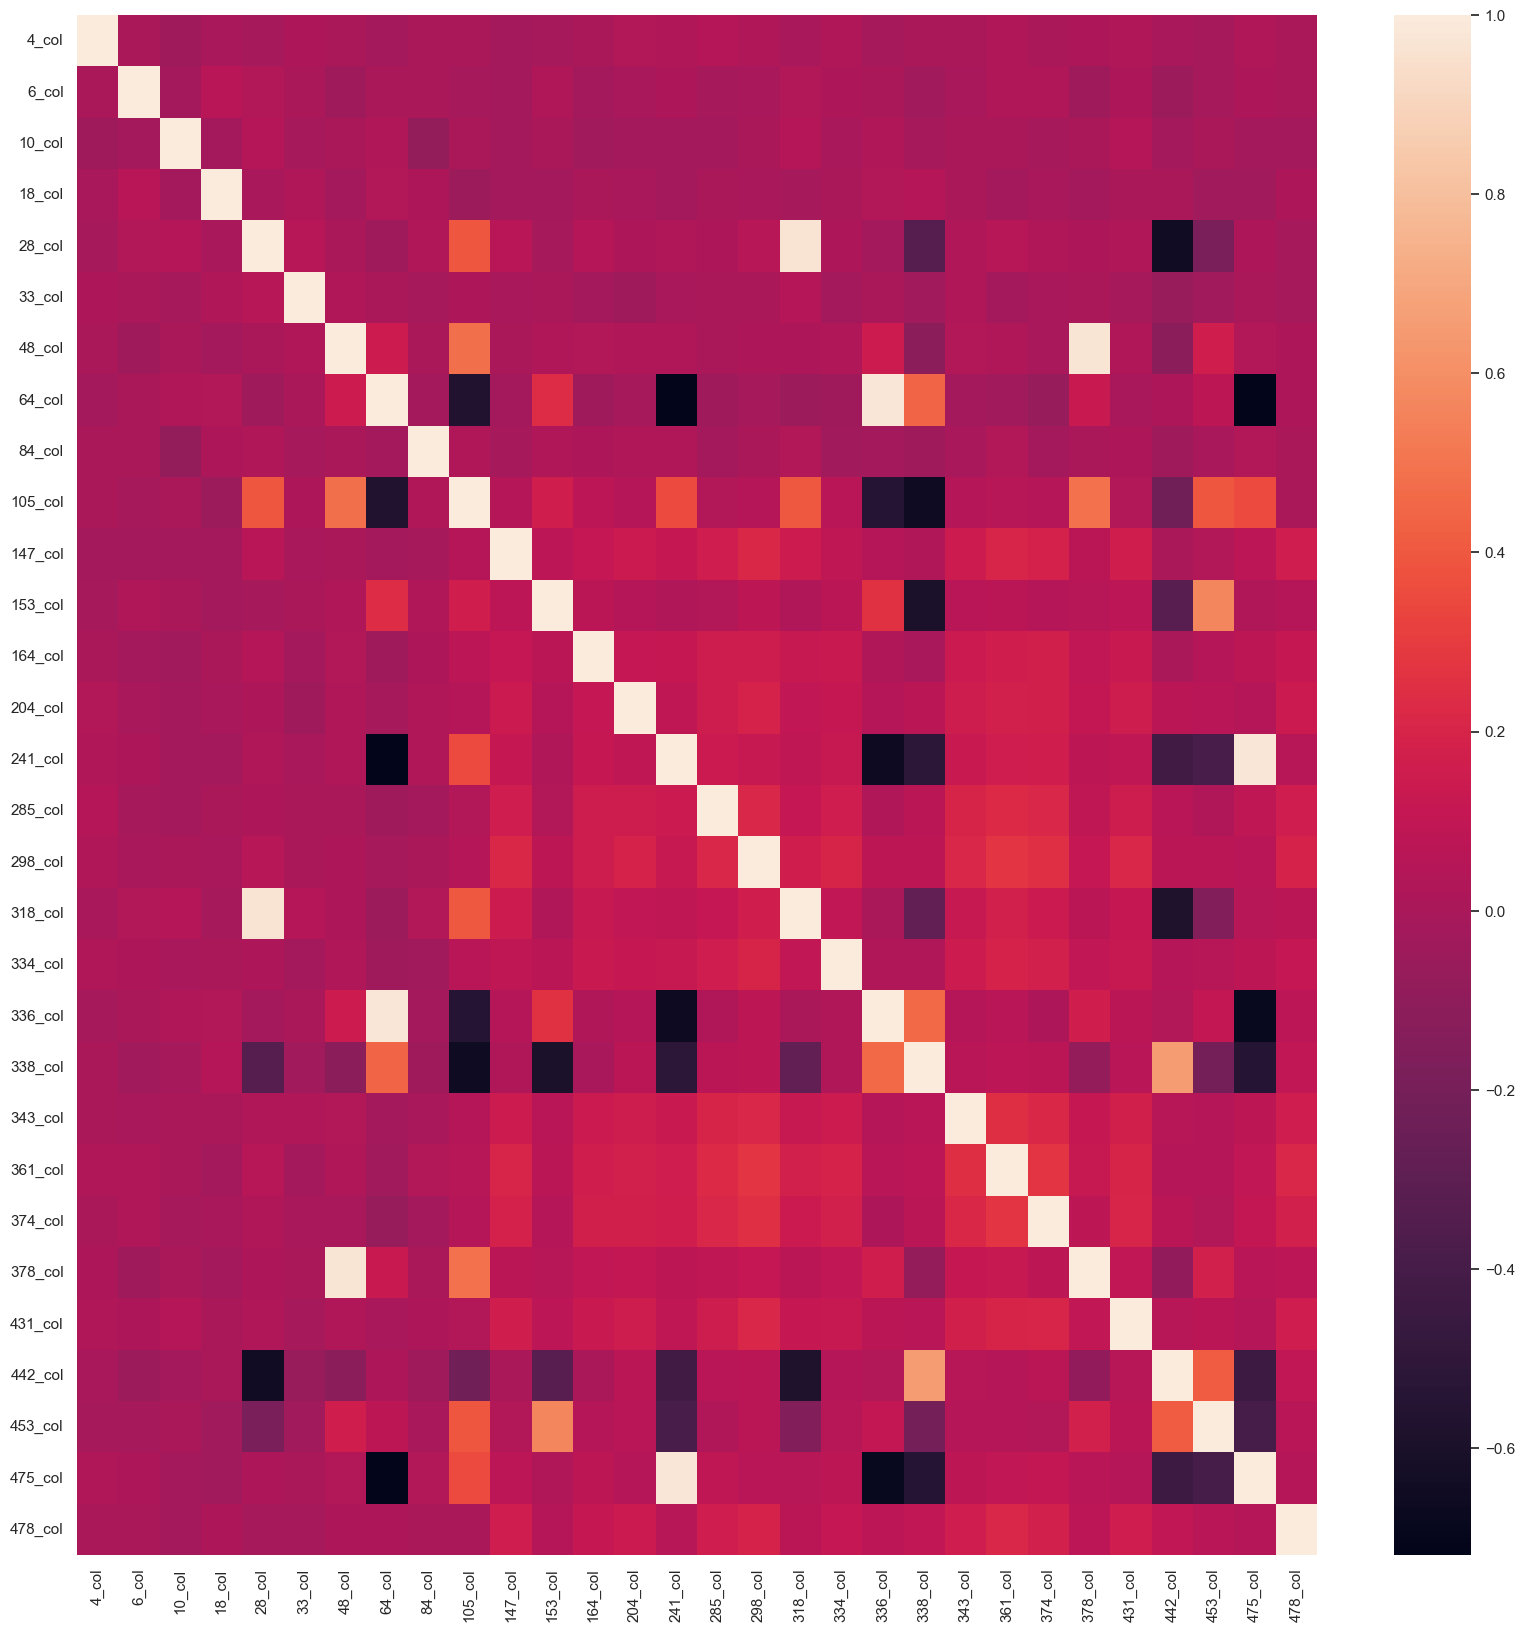

In [12]:
import seaborn as sns

# increase size of plot
sns.set(rc={'figure.figsize':(20, 20)})
sns.heatmap(X.corr())

### Feature Distriubtion

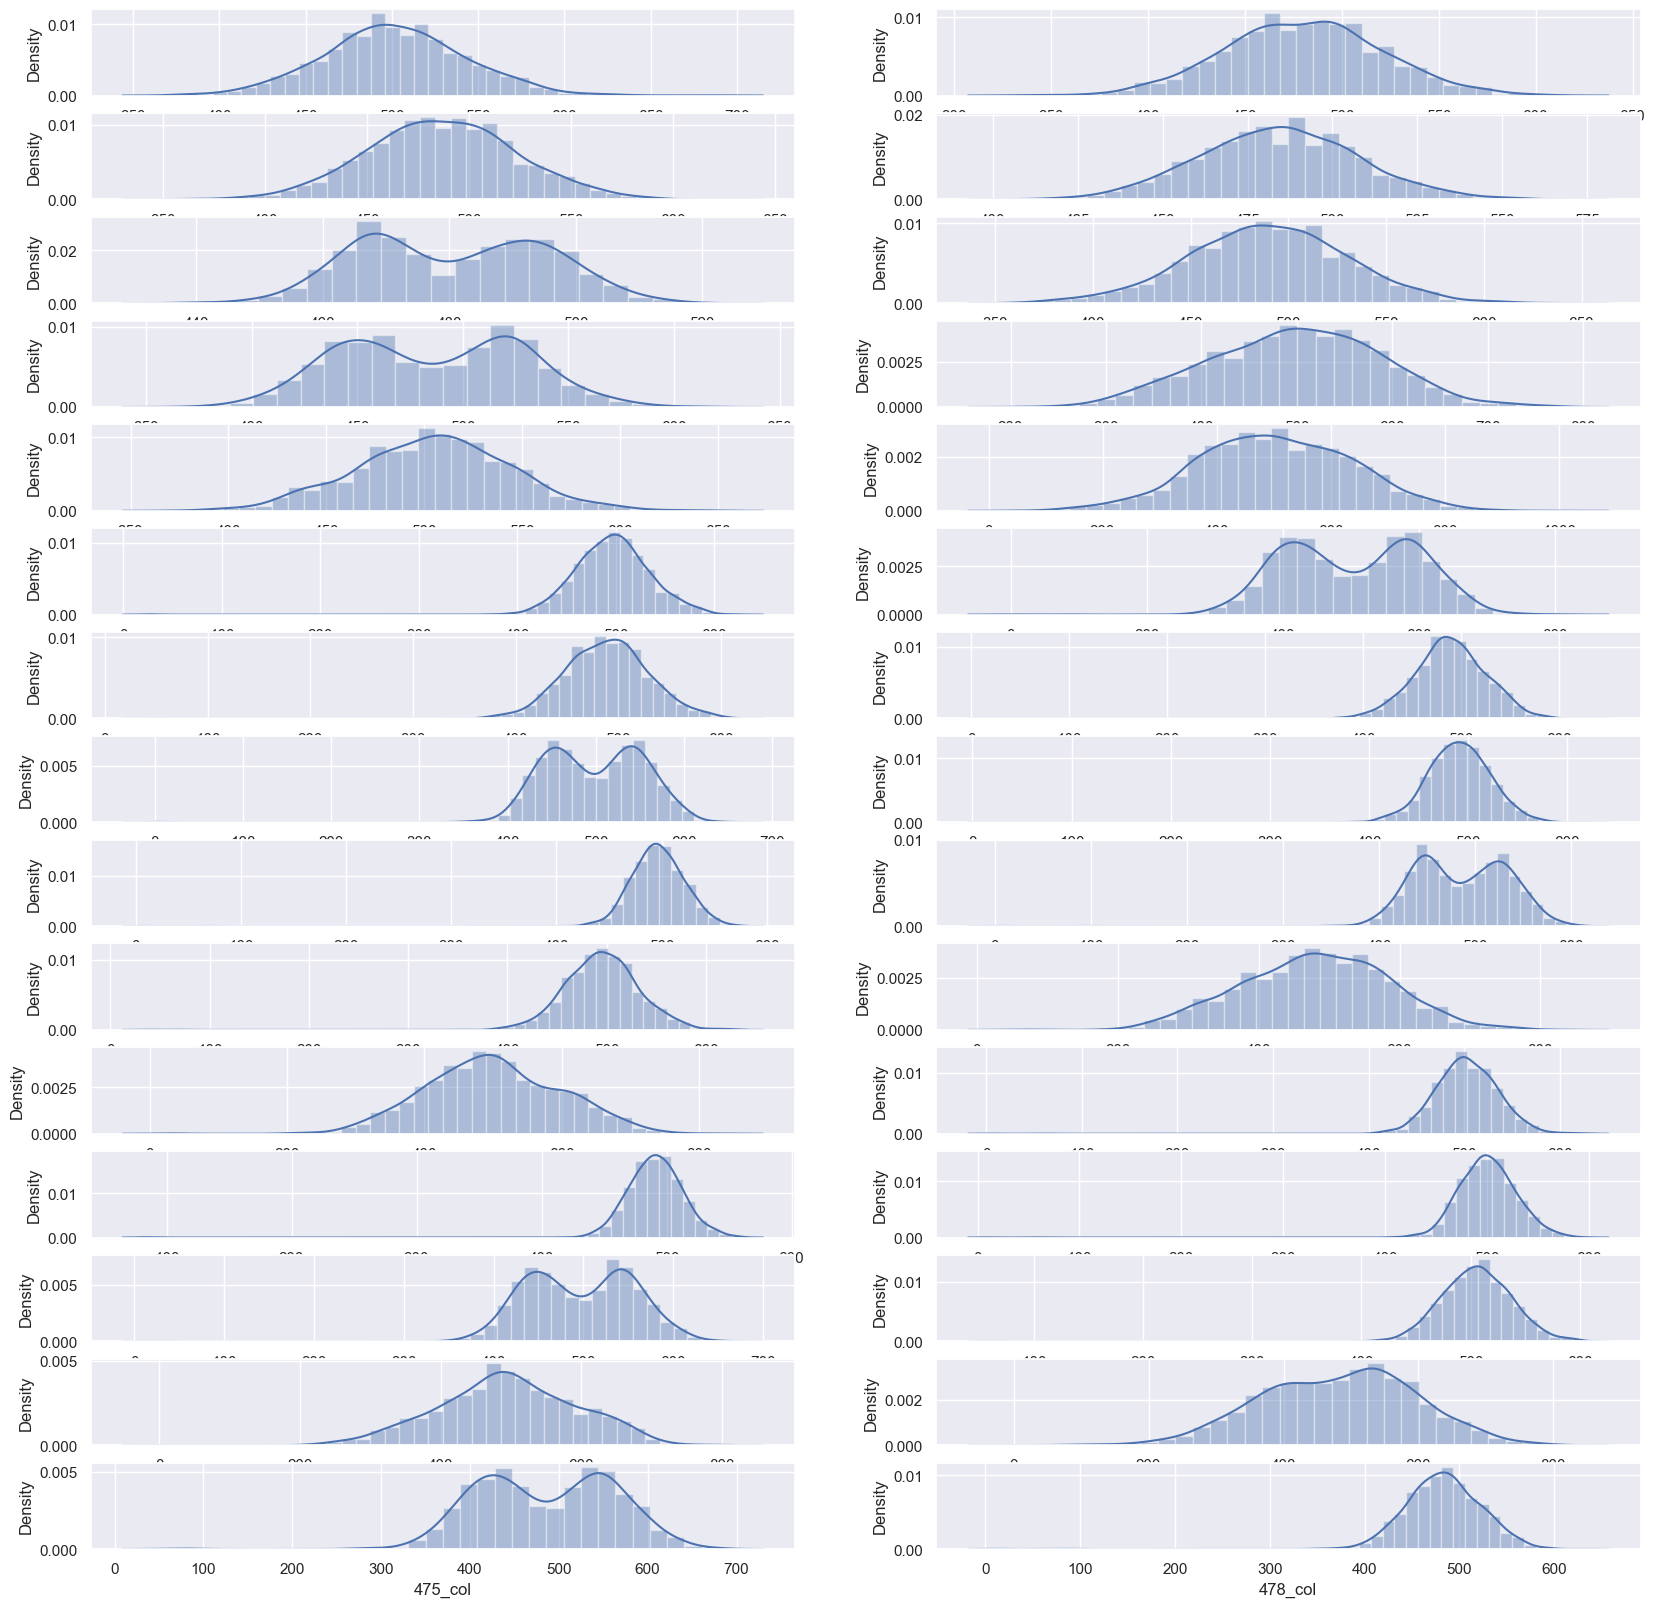

In [13]:
# plot distirbution of each column in X
# show them ins subplots 2 per row
import matplotlib.pyplot as plt
# sns.set(rc={'figure.figsize':(20, 50)})
fig, axes = plt.subplots(15, 2)
for i, column in enumerate(X.columns):
    sns.distplot(X[column], ax=axes[i//2, i%2])
    # set xaxis label to column name
    axes[i//2, i%2].set_xlabel(column)

## Delete columns based on their correlation

In [14]:
# delete most correlated columns based on X.corr values

cols = X.columns
cols_to_drop = []

for i, col in enumerate(cols):
    for j in range(i+1, len(cols)):
        if X[col].corr(X[cols[j]]) > 0.8:
            print(col, cols[j])
            cols_to_drop.append(cols[j])

cols_to_drop

28_col 318_col
48_col 378_col
64_col 336_col
241_col 475_col


['318_col', '378_col', '336_col', '475_col']

In [15]:
X_trim = X.drop(cols_to_drop, axis=1)

# tune for 30 columns
study = optuna.create_study(direction='maximize')
study.optimize(partial(objective_lightgbm, X=X, y=y, metric=balanced_accuracy_score, random_state=random_state), n_trials=100)
lgbm = lgb.LGBMClassifier(**study.best_params, random_state=random_state)
validation_scores['30_final'] = kfold(X, y, lgbm, num_folds=7, metric=balanced_accuracy_score, random_state=random_state)[1]
print("Validation for 30 columns: ", validation_scores['30_final'])

# tune for trimmed columns
study = optuna.create_study(direction='maximize')
study.optimize(partial(objective_lightgbm, X=X_trim, y=y, metric=balanced_accuracy_score, random_state=random_state), n_trials=100)
lgbm_trim = lgb.LGBMClassifier(**study.best_params, random_state=random_state)
validation_scores['trim'] = kfold(X_trim, y, lgbm_trim, num_folds=7, metric=balanced_accuracy_score, random_state=random_state)[1]
print("Validation for trimmed columns: ", validation_scores['trim'])

[I 2024-01-16 17:56:39,123] A new study created in memory with name: no-name-49bdc4f0-2e34-4b03-adfa-688ad46ad0c8


[LightGBM] [Warning] feature_fraction is set=0.9647868760837542, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9647868760837542
[LightGBM] [Warning] bagging_fraction is set=0.8433755940634807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8433755940634807
[LightGBM] [Warning] lambda_l1 is set=1.2318020609579976e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2318020609579976e-08
[LightGBM] [Warning] lambda_l2 is set=1.3248572047675894e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3248572047675894e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9647868760837542, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9647868760837542
[LightGBM] [Warning] bagging_fraction is set=0.8433755940634807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8433755940634807
[LightG

[I 2024-01-16 17:56:39,620] Trial 0 finished with value: 0.8030541983145891 and parameters: {'lambda_l1': 1.2318020609579976e-08, 'lambda_l2': 1.3248572047675894e-05, 'num_leaves': 142, 'feature_fraction': 0.9647868760837542, 'bagging_fraction': 0.8433755940634807, 'bagging_freq': 6, 'min_child_samples': 78}. Best is trial 0 with value: 0.8030541983145891.


[LightGBM] [Warning] feature_fraction is set=0.8037799561498082, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8037799561498082
[LightGBM] [Warning] bagging_fraction is set=0.5037249882658643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5037249882658643
[LightGBM] [Warning] lambda_l1 is set=2.3053335949662084e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3053335949662084e-07
[LightGBM] [Warning] lambda_l2 is set=2.8719197128880247, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8719197128880247
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8037799561498082, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8037799561498082
[LightGBM] [Warning] bagging_fraction is set=0.5037249882658643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5037249882658643
[LightGBM] [War

[I 2024-01-16 17:56:39,999] Trial 1 finished with value: 0.7657823835965709 and parameters: {'lambda_l1': 2.3053335949662084e-07, 'lambda_l2': 2.8719197128880247, 'num_leaves': 234, 'feature_fraction': 0.8037799561498082, 'bagging_fraction': 0.5037249882658643, 'bagging_freq': 5, 'min_child_samples': 75}. Best is trial 0 with value: 0.8030541983145891.


[LightGBM] [Warning] feature_fraction is set=0.8037799561498082, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8037799561498082
[LightGBM] [Warning] bagging_fraction is set=0.5037249882658643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5037249882658643
[LightGBM] [Warning] lambda_l1 is set=2.3053335949662084e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3053335949662084e-07
[LightGBM] [Warning] lambda_l2 is set=2.8719197128880247, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8719197128880247
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8037799561498082, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8037799561498082
[LightGBM] [Warning] bagging_fraction is set=0.5037249882658643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5037249882658643
[LightGBM] [War

[I 2024-01-16 17:56:41,307] Trial 2 finished with value: 0.8184730621777192 and parameters: {'lambda_l1': 3.946526860361568e-06, 'lambda_l2': 0.003607297102303938, 'num_leaves': 44, 'feature_fraction': 0.699966761358621, 'bagging_fraction': 0.5649396442713226, 'bagging_freq': 7, 'min_child_samples': 7}. Best is trial 2 with value: 0.8184730621777192.


[LightGBM] [Warning] feature_fraction is set=0.47142549950246065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47142549950246065
[LightGBM] [Warning] bagging_fraction is set=0.41018972336803006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41018972336803006
[LightGBM] [Warning] lambda_l1 is set=0.03831916293149284, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03831916293149284
[LightGBM] [Warning] lambda_l2 is set=4.729963434663764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.729963434663764
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.47142549950246065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47142549950246065
[LightGBM] [Warning] bagging_fraction is set=0.41018972336803006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41018972336803006
[LightGBM] [War

[I 2024-01-16 17:56:41,692] Trial 3 finished with value: 0.7391005037715855 and parameters: {'lambda_l1': 0.03831916293149284, 'lambda_l2': 4.729963434663764, 'num_leaves': 240, 'feature_fraction': 0.47142549950246065, 'bagging_fraction': 0.41018972336803006, 'bagging_freq': 6, 'min_child_samples': 58}. Best is trial 2 with value: 0.8184730621777192.


[LightGBM] [Warning] feature_fraction is set=0.47142549950246065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47142549950246065
[LightGBM] [Warning] bagging_fraction is set=0.41018972336803006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41018972336803006
[LightGBM] [Warning] lambda_l1 is set=0.03831916293149284, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03831916293149284
[LightGBM] [Warning] lambda_l2 is set=4.729963434663764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.729963434663764
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.47142549950246065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47142549950246065
[LightGBM] [Warning] bagging_fraction is set=0.41018972336803006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41018972336803006
[LightGBM] [War

[I 2024-01-16 17:56:42,131] Trial 4 finished with value: 0.7977239452904519 and parameters: {'lambda_l1': 2.5484958421746336e-08, 'lambda_l2': 0.7282733783347938, 'num_leaves': 28, 'feature_fraction': 0.6443238173893886, 'bagging_fraction': 0.7273224368479712, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 2 with value: 0.8184730621777192.


[LightGBM] [Warning] feature_fraction is set=0.6443238173893886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6443238173893886
[LightGBM] [Warning] bagging_fraction is set=0.7273224368479712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7273224368479712
[LightGBM] [Warning] lambda_l1 is set=2.5484958421746336e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5484958421746336e-08
[LightGBM] [Warning] lambda_l2 is set=0.7282733783347938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7282733783347938
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5015831470839507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5015831470839507
[LightGBM] [Warning] bagging_fraction is set=0.781252938518948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.781252938518948
[LightGBM] [Warni

[I 2024-01-16 17:56:44,030] Trial 5 finished with value: 0.8338033099604477 and parameters: {'lambda_l1': 1.1186789120604694e-06, 'lambda_l2': 0.00019480401743455052, 'num_leaves': 254, 'feature_fraction': 0.5015831470839507, 'bagging_fraction': 0.781252938518948, 'bagging_freq': 4, 'min_child_samples': 8}. Best is trial 5 with value: 0.8338033099604477.


[LightGBM] [Warning] feature_fraction is set=0.648800824412084, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.648800824412084
[LightGBM] [Warning] bagging_fraction is set=0.9625493560128336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9625493560128336
[LightGBM] [Warning] lambda_l1 is set=0.0010316915768369388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010316915768369388
[LightGBM] [Warning] lambda_l2 is set=5.382290970087385e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.382290970087385e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.648800824412084, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.648800824412084
[LightGBM] [Warning] bagging_fraction is set=0.9625493560128336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9625493560128336
[LightGBM] [War

[I 2024-01-16 17:56:44,638] Trial 6 finished with value: 0.8196043394812607 and parameters: {'lambda_l1': 0.0010316915768369388, 'lambda_l2': 5.382290970087385e-07, 'num_leaves': 212, 'feature_fraction': 0.648800824412084, 'bagging_fraction': 0.9625493560128336, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 5 with value: 0.8338033099604477.


[LightGBM] [Warning] feature_fraction is set=0.648800824412084, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.648800824412084
[LightGBM] [Warning] bagging_fraction is set=0.9625493560128336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9625493560128336
[LightGBM] [Warning] lambda_l1 is set=0.0010316915768369388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010316915768369388
[LightGBM] [Warning] lambda_l2 is set=5.382290970087385e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.382290970087385e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6538625512093963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6538625512093963
[LightGBM] [Warning] bagging_fraction is set=0.6956803542371555, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6956803542371555
[LightGBM] [W

[I 2024-01-16 17:56:45,125] Trial 7 finished with value: 0.7745361931743637 and parameters: {'lambda_l1': 0.07470906099755058, 'lambda_l2': 6.05090753585294e-07, 'num_leaves': 246, 'feature_fraction': 0.6538625512093963, 'bagging_fraction': 0.6956803542371555, 'bagging_freq': 3, 'min_child_samples': 81}. Best is trial 5 with value: 0.8338033099604477.


[LightGBM] [Warning] feature_fraction is set=0.6538625512093963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6538625512093963
[LightGBM] [Warning] bagging_fraction is set=0.6956803542371555, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6956803542371555
[LightGBM] [Warning] lambda_l1 is set=0.07470906099755058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07470906099755058
[LightGBM] [Warning] lambda_l2 is set=6.05090753585294e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.05090753585294e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.46162279646511206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46162279646511206
[LightGBM] [Warning] bagging_fraction is set=0.9046417136094149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9046417136094149
[LightGBM] [War

[I 2024-01-16 17:56:45,712] Trial 8 finished with value: 0.8215305262011231 and parameters: {'lambda_l1': 1.2980123010079176, 'lambda_l2': 0.0006158495211581091, 'num_leaves': 22, 'feature_fraction': 0.46162279646511206, 'bagging_fraction': 0.9046417136094149, 'bagging_freq': 2, 'min_child_samples': 39}. Best is trial 5 with value: 0.8338033099604477.


[LightGBM] [Warning] feature_fraction is set=0.8419810919818238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8419810919818238
[LightGBM] [Warning] bagging_fraction is set=0.8982550894121646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8982550894121646
[LightGBM] [Warning] lambda_l1 is set=0.004769077689550613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004769077689550613
[LightGBM] [Warning] lambda_l2 is set=3.2950347971127644e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2950347971127644e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8419810919818238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8419810919818238
[LightGBM] [Warning] bagging_fraction is set=0.8982550894121646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8982550894121646
[LightGBM] 

[I 2024-01-16 17:56:46,304] Trial 9 finished with value: 0.8207381001397897 and parameters: {'lambda_l1': 0.004769077689550613, 'lambda_l2': 3.2950347971127644e-06, 'num_leaves': 26, 'feature_fraction': 0.8419810919818238, 'bagging_fraction': 0.8982550894121646, 'bagging_freq': 6, 'min_child_samples': 47}. Best is trial 5 with value: 0.8338033099604477.


[LightGBM] [Warning] feature_fraction is set=0.8419810919818238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8419810919818238
[LightGBM] [Warning] bagging_fraction is set=0.8982550894121646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8982550894121646
[LightGBM] [Warning] lambda_l1 is set=0.004769077689550613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004769077689550613
[LightGBM] [Warning] lambda_l2 is set=3.2950347971127644e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2950347971127644e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4026107386060648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4026107386060648
[LightGBM] [Warning] bagging_fraction is set=0.7514248453146098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7514248453146098
[LightGBM] 

[I 2024-01-16 17:56:48,188] Trial 10 finished with value: 0.8378804252598208 and parameters: {'lambda_l1': 6.1141558603850445e-06, 'lambda_l2': 1.1026625259486554e-08, 'num_leaves': 171, 'feature_fraction': 0.4026107386060648, 'bagging_fraction': 0.7514248453146098, 'bagging_freq': 1, 'min_child_samples': 8}. Best is trial 10 with value: 0.8378804252598208.


[LightGBM] [Warning] feature_fraction is set=0.4105642286242354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4105642286242354
[LightGBM] [Warning] bagging_fraction is set=0.7682080831190589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7682080831190589
[LightGBM] [Warning] lambda_l1 is set=1.5459303336682648e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5459303336682648e-05
[LightGBM] [Warning] lambda_l2 is set=4.15905857199036e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.15905857199036e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4105642286242354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4105642286242354
[LightGBM] [Warning] bagging_fraction is set=0.7682080831190589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7682080831190589
[LightGBM] 

[I 2024-01-16 17:56:50,521] Trial 11 finished with value: 0.842512506465949 and parameters: {'lambda_l1': 1.5459303336682648e-05, 'lambda_l2': 4.15905857199036e-08, 'num_leaves': 170, 'feature_fraction': 0.4105642286242354, 'bagging_fraction': 0.7682080831190589, 'bagging_freq': 1, 'min_child_samples': 6}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.5497340534357422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5497340534357422
[LightGBM] [Warning] bagging_fraction is set=0.6368412316341265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6368412316341265
[LightGBM] [Warning] lambda_l1 is set=3.1770132220465705e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1770132220465705e-05
[LightGBM] [Warning] lambda_l2 is set=1.3975369747843547e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3975369747843547e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5497340534357422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5497340534357422
[LightGBM] [Warning] bagging_fraction is set=0.6368412316341265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6368412316341265
[LightG

[I 2024-01-16 17:56:51,210] Trial 12 finished with value: 0.8074690562346263 and parameters: {'lambda_l1': 3.1770132220465705e-05, 'lambda_l2': 1.3975369747843547e-08, 'num_leaves': 165, 'feature_fraction': 0.5497340534357422, 'bagging_fraction': 0.6368412316341265, 'bagging_freq': 1, 'min_child_samples': 26}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.5497340534357422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5497340534357422
[LightGBM] [Warning] bagging_fraction is set=0.6368412316341265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6368412316341265
[LightGBM] [Warning] lambda_l1 is set=3.1770132220465705e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1770132220465705e-05
[LightGBM] [Warning] lambda_l2 is set=1.3975369747843547e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3975369747843547e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4057770774567837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4057770774567837
[LightGBM] [Warning] bagging_fraction is set=0.8150810705334746, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8150810705334746
[LightG

[I 2024-01-16 17:56:52,018] Trial 13 finished with value: 0.8244720465281523 and parameters: {'lambda_l1': 4.321918682295322e-05, 'lambda_l2': 3.034682153237707e-08, 'num_leaves': 92, 'feature_fraction': 0.4057770774567837, 'bagging_fraction': 0.8150810705334746, 'bagging_freq': 1, 'min_child_samples': 25}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.4029253712190977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4029253712190977
[LightGBM] [Warning] bagging_fraction is set=0.6732276744327979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6732276744327979
[LightGBM] [Warning] lambda_l1 is set=3.66936117691527e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.66936117691527e-05
[LightGBM] [Warning] lambda_l2 is set=1.0235562225925861e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0235562225925861e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4029253712190977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4029253712190977
[LightGBM] [Warning] bagging_fraction is set=0.6732276744327979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6732276744327979
[LightGBM] 

[I 2024-01-16 17:56:52,410] Trial 14 finished with value: 0.7613433709830358 and parameters: {'lambda_l1': 3.66936117691527e-05, 'lambda_l2': 1.0235562225925861e-08, 'num_leaves': 174, 'feature_fraction': 0.4029253712190977, 'bagging_fraction': 0.6732276744327979, 'bagging_freq': 1, 'min_child_samples': 100}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.4029253712190977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4029253712190977
[LightGBM] [Warning] bagging_fraction is set=0.6732276744327979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6732276744327979
[LightGBM] [Warning] lambda_l1 is set=3.66936117691527e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.66936117691527e-05
[LightGBM] [Warning] lambda_l2 is set=1.0235562225925861e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0235562225925861e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5601590680547666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5601590680547666
[LightGBM] [Warning] bagging_fraction is set=0.7714742667110972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7714742667110972
[LightGBM] 

[I 2024-01-16 17:56:53,404] Trial 15 finished with value: 0.8328640356884227 and parameters: {'lambda_l1': 3.0788621365815073e-06, 'lambda_l2': 1.0187773361278968e-07, 'num_leaves': 98, 'feature_fraction': 0.5601590680547666, 'bagging_fraction': 0.7714742667110972, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.5586555117193118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5586555117193118
[LightGBM] [Warning] bagging_fraction is set=0.6021562848368814, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6021562848368814
[LightGBM] [Warning] lambda_l1 is set=0.00017600463877720111, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017600463877720111
[LightGBM] [Warning] lambda_l2 is set=0.08301817086835588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08301817086835588
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5586555117193118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5586555117193118
[LightGBM] [Warning] bagging_fraction is set=0.6021562848368814, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6021562848368814
[LightGBM] [W

[I 2024-01-16 17:56:53,923] Trial 16 finished with value: 0.8012582810081856 and parameters: {'lambda_l1': 0.00017600463877720111, 'lambda_l2': 0.08301817086835588, 'num_leaves': 191, 'feature_fraction': 0.5586555117193118, 'bagging_fraction': 0.6021562848368814, 'bagging_freq': 2, 'min_child_samples': 39}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.5586555117193118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5586555117193118
[LightGBM] [Warning] bagging_fraction is set=0.6021562848368814, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6021562848368814
[LightGBM] [Warning] lambda_l1 is set=0.00017600463877720111, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017600463877720111
[LightGBM] [Warning] lambda_l2 is set=0.08301817086835588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08301817086835588
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5586555117193118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5586555117193118
[LightGBM] [Warning] bagging_fraction is set=0.6021562848368814, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6021562848368814
[LightGBM] [W

[I 2024-01-16 17:56:55,178] Trial 17 finished with value: 0.8349570672307447 and parameters: {'lambda_l1': 2.791625679970395e-07, 'lambda_l2': 1.7243795429589983e-05, 'num_leaves': 120, 'feature_fraction': 0.7959206385081936, 'bagging_fraction': 0.9894806597540511, 'bagging_freq': 1, 'min_child_samples': 18}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.40233490901249014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40233490901249014
[LightGBM] [Warning] bagging_fraction is set=0.7348361900298229, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7348361900298229
[LightGBM] [Warning] lambda_l1 is set=0.0007067833622522666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007067833622522666
[LightGBM] [Warning] lambda_l2 is set=2.656840970061347e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.656840970061347e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.40233490901249014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40233490901249014
[LightGBM] [Warning] bagging_fraction is set=0.7348361900298229, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7348361900298229
[LightG

[I 2024-01-16 17:56:55,828] Trial 18 finished with value: 0.8145271598589126 and parameters: {'lambda_l1': 0.0007067833622522666, 'lambda_l2': 2.656840970061347e-07, 'num_leaves': 151, 'feature_fraction': 0.40233490901249014, 'bagging_fraction': 0.7348361900298229, 'bagging_freq': 4, 'min_child_samples': 33}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.40233490901249014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40233490901249014
[LightGBM] [Warning] bagging_fraction is set=0.7348361900298229, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7348361900298229
[LightGBM] [Warning] lambda_l1 is set=0.0007067833622522666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007067833622522666
[LightGBM] [Warning] lambda_l2 is set=2.656840970061347e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.656840970061347e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5086769884370688, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5086769884370688
[LightGBM] [Warning] bagging_fraction is set=0.8620342113925008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8620342113925008
[LightGBM

[I 2024-01-16 17:56:56,509] Trial 19 finished with value: 0.8093493673171428 and parameters: {'lambda_l1': 9.268105000341611, 'lambda_l2': 3.598978720038778e-06, 'num_leaves': 200, 'feature_fraction': 0.5086769884370688, 'bagging_fraction': 0.8620342113925008, 'bagging_freq': 2, 'min_child_samples': 6}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.5086769884370688, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5086769884370688
[LightGBM] [Warning] bagging_fraction is set=0.8620342113925008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8620342113925008
[LightGBM] [Warning] lambda_l1 is set=9.268105000341611, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.268105000341611
[LightGBM] [Warning] lambda_l2 is set=3.598978720038778e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.598978720038778e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9784529023534958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9784529023534958
[LightGBM] [Warning] bagging_fraction is set=0.5336071534852141, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5336071534852141
[LightGBM] [Warning

[I 2024-01-16 17:56:57,439] Trial 20 finished with value: 0.8027114583432329 and parameters: {'lambda_l1': 8.550871975057742e-06, 'lambda_l2': 9.508596468090252e-05, 'num_leaves': 116, 'feature_fraction': 0.9784529023534958, 'bagging_fraction': 0.5336071534852141, 'bagging_freq': 3, 'min_child_samples': 16}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.8175685597079153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8175685597079153
[LightGBM] [Warning] bagging_fraction is set=0.9925679047195757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9925679047195757
[LightGBM] [Warning] lambda_l1 is set=1.318136141861422e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.318136141861422e-07
[LightGBM] [Warning] lambda_l2 is set=1.7117450778056486e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7117450778056486e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8175685597079153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8175685597079153
[LightGBM] [Warning] bagging_fraction is set=0.9925679047195757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9925679047195757
[LightGBM

[I 2024-01-16 17:56:58,799] Trial 21 finished with value: 0.8417611836007473 and parameters: {'lambda_l1': 1.318136141861422e-07, 'lambda_l2': 1.7117450778056486e-05, 'num_leaves': 122, 'feature_fraction': 0.8175685597079153, 'bagging_fraction': 0.9925679047195757, 'bagging_freq': 1, 'min_child_samples': 16}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.8968574712813594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8968574712813594
[LightGBM] [Warning] bagging_fraction is set=0.9349700207836925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9349700207836925
[LightGBM] [Warning] lambda_l1 is set=1.2722215724850063e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2722215724850063e-07
[LightGBM] [Warning] lambda_l2 is set=0.011041295891331395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011041295891331395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8968574712813594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8968574712813594
[LightGBM] [Warning] bagging_fraction is set=0.9349700207836925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9349700207836925
[LightGBM] 

[I 2024-01-16 17:57:00,258] Trial 22 finished with value: 0.8376927500394455 and parameters: {'lambda_l1': 1.2722215724850063e-07, 'lambda_l2': 0.011041295891331395, 'num_leaves': 79, 'feature_fraction': 0.8968574712813594, 'bagging_fraction': 0.9349700207836925, 'bagging_freq': 1, 'min_child_samples': 14}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.7741336141468483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7741336141468483
[LightGBM] [Warning] bagging_fraction is set=0.8013505141775678, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8013505141775678
[LightGBM] [Warning] lambda_l1 is set=7.299498297294827e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.299498297294827e-07
[LightGBM] [Warning] lambda_l2 is set=5.176756895257552e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.176756895257552e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7741336141468483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7741336141468483
[LightGBM] [Warning] bagging_fraction is set=0.8013505141775678, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8013505141775678
[LightGBM] 

[I 2024-01-16 17:57:01,027] Trial 23 finished with value: 0.8291782094822086 and parameters: {'lambda_l1': 7.299498297294827e-07, 'lambda_l2': 5.176756895257552e-08, 'num_leaves': 145, 'feature_fraction': 0.7741336141468483, 'bagging_fraction': 0.8013505141775678, 'bagging_freq': 2, 'min_child_samples': 30}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.7741336141468483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7741336141468483
[LightGBM] [Warning] bagging_fraction is set=0.8013505141775678, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8013505141775678
[LightGBM] [Warning] lambda_l1 is set=7.299498297294827e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.299498297294827e-07
[LightGBM] [Warning] lambda_l2 is set=5.176756895257552e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.176756895257552e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7422858987380752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7422858987380752
[LightGBM] [Warning] bagging_fraction is set=0.6541703640261431, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6541703640261431
[LightGBM] 

[I 2024-01-16 17:57:02,313] Trial 24 finished with value: 0.829341446968526 and parameters: {'lambda_l1': 1.3034748402771945e-07, 'lambda_l2': 1.6752614559214322e-06, 'num_leaves': 176, 'feature_fraction': 0.7422858987380752, 'bagging_fraction': 0.6541703640261431, 'bagging_freq': 1, 'min_child_samples': 12}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.8702586796426108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8702586796426108
[LightGBM] [Warning] bagging_fraction is set=0.739093612535301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.739093612535301
[LightGBM] [Warning] lambda_l1 is set=1.1484592681189317e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1484592681189317e-05
[LightGBM] [Warning] lambda_l2 is set=1.2093980631215494e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2093980631215494e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8702586796426108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8702586796426108
[LightGBM] [Warning] bagging_fraction is set=0.739093612535301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.739093612535301
[LightGBM] 

[I 2024-01-16 17:57:03,907] Trial 25 finished with value: 0.8391486429182029 and parameters: {'lambda_l1': 1.1484592681189317e-05, 'lambda_l2': 1.2093980631215494e-07, 'num_leaves': 62, 'feature_fraction': 0.8702586796426108, 'bagging_fraction': 0.739093612535301, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.909443203171908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.909443203171908
[LightGBM] [Warning] bagging_fraction is set=0.8706498318119891, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706498318119891
[LightGBM] [Warning] lambda_l1 is set=0.00014763897460829585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014763897460829585
[LightGBM] [Warning] lambda_l2 is set=3.7304625571970026e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7304625571970026e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.909443203171908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.909443203171908
[LightGBM] [Warning] bagging_fraction is set=0.8706498318119891, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706498318119891
[LightGBM] 

[I 2024-01-16 17:57:05,183] Trial 26 finished with value: 0.8313029587670723 and parameters: {'lambda_l1': 0.00014763897460829585, 'lambda_l2': 3.7304625571970026e-05, 'num_leaves': 60, 'feature_fraction': 0.909443203171908, 'bagging_fraction': 0.8706498318119891, 'bagging_freq': 2, 'min_child_samples': 25}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.8729239033527663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8729239033527663
[LightGBM] [Warning] bagging_fraction is set=0.4411989189667432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4411989189667432
[LightGBM] [Warning] lambda_l1 is set=3.5457302468454154e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5457302468454154e-08
[LightGBM] [Warning] lambda_l2 is set=1.0364720177576577e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0364720177576577e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8729239033527663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8729239033527663
[LightGBM] [Warning] bagging_fraction is set=0.4411989189667432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4411989189667432
[LightG

[I 2024-01-16 17:57:05,577] Trial 27 finished with value: 0.6329989598563927 and parameters: {'lambda_l1': 3.5457302468454154e-08, 'lambda_l2': 1.0364720177576577e-07, 'num_leaves': 2, 'feature_fraction': 0.8729239033527663, 'bagging_fraction': 0.4411989189667432, 'bagging_freq': 2, 'min_child_samples': 20}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.8729239033527663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8729239033527663
[LightGBM] [Warning] bagging_fraction is set=0.4411989189667432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4411989189667432
[LightGBM] [Warning] lambda_l1 is set=3.5457302468454154e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5457302468454154e-08
[LightGBM] [Warning] lambda_l2 is set=1.0364720177576577e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0364720177576577e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8554092789057226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8554092789057226
[LightGBM] [Warning] bagging_fraction is set=0.6121375201917296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6121375201917296
[LightG

[I 2024-01-16 17:57:06,415] Trial 28 finished with value: 0.804759181669551 and parameters: {'lambda_l1': 1.0324220312537463e-06, 'lambda_l2': 2.286670260702001e-07, 'num_leaves': 68, 'feature_fraction': 0.8554092789057226, 'bagging_fraction': 0.6121375201917296, 'bagging_freq': 3, 'min_child_samples': 43}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.9325981464851754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9325981464851754
[LightGBM] [Warning] bagging_fraction is set=0.8346855857295055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8346855857295055
[LightGBM] [Warning] lambda_l1 is set=2.2421099896567307e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2421099896567307e-05
[LightGBM] [Warning] lambda_l2 is set=5.352606052089161e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.352606052089161e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9325981464851754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9325981464851754
[LightGBM] [Warning] bagging_fraction is set=0.8346855857295055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8346855857295055
[LightGBM

[I 2024-01-16 17:57:07,558] Trial 29 finished with value: 0.8298823234906353 and parameters: {'lambda_l1': 2.2421099896567307e-05, 'lambda_l2': 5.352606052089161e-06, 'num_leaves': 133, 'feature_fraction': 0.9325981464851754, 'bagging_fraction': 0.8346855857295055, 'bagging_freq': 5, 'min_child_samples': 33}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.9325981464851754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9325981464851754
[LightGBM] [Warning] bagging_fraction is set=0.8346855857295055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8346855857295055
[LightGBM] [Warning] lambda_l1 is set=2.2421099896567307e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2421099896567307e-05
[LightGBM] [Warning] lambda_l2 is set=5.352606052089161e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.352606052089161e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7189516432815569, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7189516432815569
[LightGBM] [Warning] bagging_fraction is set=0.707727666884998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.707727666884998
[LightGBM] 

[I 2024-01-16 17:57:10,656] Trial 30 finished with value: 0.8393975257548677 and parameters: {'lambda_l1': 2.6093174586935146e-08, 'lambda_l2': 1.1082222823677993e-06, 'num_leaves': 104, 'feature_fraction': 0.7189516432815569, 'bagging_fraction': 0.707727666884998, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.7228563619137428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7228563619137428
[LightGBM] [Warning] bagging_fraction is set=0.7141844973044879, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7141844973044879
[LightGBM] [Warning] lambda_l1 is set=1.3050395335959266e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3050395335959266e-08
[LightGBM] [Warning] lambda_l2 is set=9.117165692696588e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.117165692696588e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7228563619137428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7228563619137428
[LightGBM] [Warning] bagging_fraction is set=0.7141844973044879, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7141844973044879
[LightGBM

[I 2024-01-16 17:57:14,161] Trial 31 finished with value: 0.8367837471343531 and parameters: {'lambda_l1': 1.3050395335959266e-08, 'lambda_l2': 9.117165692696588e-07, 'num_leaves': 109, 'feature_fraction': 0.7228563619137428, 'bagging_fraction': 0.7141844973044879, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.8292667661871129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8292667661871129
[LightGBM] [Warning] bagging_fraction is set=0.6889633403533647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6889633403533647
[LightGBM] [Warning] lambda_l1 is set=5.141438901207213e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.141438901207213e-08
[LightGBM] [Warning] lambda_l2 is set=1.0398398404101626e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0398398404101626e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8292667661871129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8292667661871129
[LightGBM] [Warning] bagging_fraction is set=0.6889633403533647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6889633403533647
[LightGBM

[I 2024-01-16 17:57:16,340] Trial 32 finished with value: 0.8381596896084957 and parameters: {'lambda_l1': 5.141438901207213e-08, 'lambda_l2': 1.0398398404101626e-05, 'num_leaves': 84, 'feature_fraction': 0.8292667661871129, 'bagging_fraction': 0.6889633403533647, 'bagging_freq': 1, 'min_child_samples': 13}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.6882642499260848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6882642499260848
[LightGBM] [Warning] bagging_fraction is set=0.49102157253926426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49102157253926426
[LightGBM] [Warning] lambda_l1 is set=4.0050128995166294e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0050128995166294e-07
[LightGBM] [Warning] lambda_l2 is set=0.0007400708199042421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007400708199042421
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6882642499260848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6882642499260848
[LightGBM] [Warning] bagging_fraction is set=0.49102157253926426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49102157253926426
[Ligh

[I 2024-01-16 17:57:18,071] Trial 33 finished with value: 0.8078609711192744 and parameters: {'lambda_l1': 4.0050128995166294e-07, 'lambda_l2': 0.0007400708199042421, 'num_leaves': 56, 'feature_fraction': 0.6882642499260848, 'bagging_fraction': 0.49102157253926426, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.7621410789270141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7621410789270141
[LightGBM] [Warning] bagging_fraction is set=0.5659615131760147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5659615131760147
[LightGBM] [Warning] lambda_l1 is set=1.2576539106046501e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2576539106046501e-08
[LightGBM] [Warning] lambda_l2 is set=1.1203388234116306e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1203388234116306e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7621410789270141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7621410789270141
[LightGBM] [Warning] bagging_fraction is set=0.5659615131760147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5659615131760147
[LightG

[I 2024-01-16 17:57:19,520] Trial 34 finished with value: 0.810373978719672 and parameters: {'lambda_l1': 1.2576539106046501e-08, 'lambda_l2': 1.1203388234116306e-07, 'num_leaves': 107, 'feature_fraction': 0.7621410789270141, 'bagging_fraction': 0.5659615131760147, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.8091350030968645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8091350030968645
[LightGBM] [Warning] bagging_fraction is set=0.755907365849333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.755907365849333
[LightGBM] [Warning] lambda_l1 is set=2.3043427005442966e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3043427005442966e-06
[LightGBM] [Warning] lambda_l2 is set=3.707453620754818e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.707453620754818e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8091350030968645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8091350030968645
[LightGBM] [Warning] bagging_fraction is set=0.755907365849333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.755907365849333
[LightGBM] [W

[I 2024-01-16 17:57:23,830] Trial 35 finished with value: 0.8293340921345482 and parameters: {'lambda_l1': 2.3043427005442966e-06, 'lambda_l2': 3.707453620754818e-05, 'num_leaves': 155, 'feature_fraction': 0.8091350030968645, 'bagging_fraction': 0.755907365849333, 'bagging_freq': 7, 'min_child_samples': 6}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.6024218241411438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6024218241411438
[LightGBM] [Warning] bagging_fraction is set=0.8226820290681227, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8226820290681227
[LightGBM] [Warning] lambda_l1 is set=7.501403290428971e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.501403290428971e-08
[LightGBM] [Warning] lambda_l2 is set=1.2507415896833906e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2507415896833906e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6024218241411438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6024218241411438
[LightGBM] [Warning] bagging_fraction is set=0.8226820290681227, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8226820290681227
[LightGBM

[I 2024-01-16 17:57:24,591] Trial 36 finished with value: 0.81272884877489 and parameters: {'lambda_l1': 7.501403290428971e-08, 'lambda_l2': 1.2507415896833906e-06, 'num_leaves': 221, 'feature_fraction': 0.6024218241411438, 'bagging_fraction': 0.8226820290681227, 'bagging_freq': 2, 'min_child_samples': 67}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.6024218241411438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6024218241411438
[LightGBM] [Warning] bagging_fraction is set=0.8226820290681227, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8226820290681227
[LightGBM] [Warning] lambda_l1 is set=7.501403290428971e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.501403290428971e-08
[LightGBM] [Warning] lambda_l2 is set=1.2507415896833906e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2507415896833906e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9395421008230519, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9395421008230519
[LightGBM] [Warning] bagging_fraction is set=0.7856968002412674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7856968002412674
[LightGBM

[I 2024-01-16 17:57:27,077] Trial 37 finished with value: 0.8367435520584229 and parameters: {'lambda_l1': 0.004926954799384791, 'lambda_l2': 3.827043985082449e-07, 'num_leaves': 126, 'feature_fraction': 0.9395421008230519, 'bagging_fraction': 0.7856968002412674, 'bagging_freq': 1, 'min_child_samples': 10}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.696475704546694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.696475704546694
[LightGBM] [Warning] bagging_fraction is set=0.7224319253664597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7224319253664597
[LightGBM] [Warning] lambda_l1 is set=1.2400559974175873e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2400559974175873e-05
[LightGBM] [Warning] lambda_l2 is set=3.414329992445792e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.414329992445792e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.696475704546694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.696475704546694
[LightGBM] [Warning] bagging_fraction is set=0.7224319253664597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7224319253664597
[LightGBM] [W

[I 2024-01-16 17:57:28,739] Trial 38 finished with value: 0.8243519868890313 and parameters: {'lambda_l1': 1.2400559974175873e-05, 'lambda_l2': 3.414329992445792e-08, 'num_leaves': 137, 'feature_fraction': 0.696475704546694, 'bagging_fraction': 0.7224319253664597, 'bagging_freq': 3, 'min_child_samples': 16}. Best is trial 11 with value: 0.842512506465949.


[LightGBM] [Warning] feature_fraction is set=0.9942050143843584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9942050143843584
[LightGBM] [Warning] bagging_fraction is set=0.9328287389838387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9328287389838387
[LightGBM] [Warning] lambda_l1 is set=1.943796550829322e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.943796550829322e-06
[LightGBM] [Warning] lambda_l2 is set=1.6883383878025976e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6883383878025976e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9942050143843584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9942050143843584
[LightGBM] [Warning] bagging_fraction is set=0.9328287389838387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9328287389838387
[LightGBM

[I 2024-01-16 17:57:30,809] Trial 39 finished with value: 0.848547507133399 and parameters: {'lambda_l1': 1.943796550829322e-06, 'lambda_l2': 1.6883383878025976e-05, 'num_leaves': 48, 'feature_fraction': 0.9942050143843584, 'bagging_fraction': 0.9328287389838387, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 39 with value: 0.848547507133399.


[LightGBM] [Warning] feature_fraction is set=0.9557750541583977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9557750541583977
[LightGBM] [Warning] bagging_fraction is set=0.9434488319751567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9434488319751567
[LightGBM] [Warning] lambda_l1 is set=1.6022774226755604e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6022774226755604e-06
[LightGBM] [Warning] lambda_l2 is set=0.0001803384355597888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001803384355597888
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9557750541583977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9557750541583977
[LightGBM] [Warning] bagging_fraction is set=0.9434488319751567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9434488319751567
[LightGBM

[I 2024-01-16 17:57:31,592] Trial 40 finished with value: 0.8103715776247036 and parameters: {'lambda_l1': 1.6022774226755604e-06, 'lambda_l2': 0.0001803384355597888, 'num_leaves': 48, 'feature_fraction': 0.9557750541583977, 'bagging_fraction': 0.9434488319751567, 'bagging_freq': 5, 'min_child_samples': 89}. Best is trial 39 with value: 0.848547507133399.


[LightGBM] [Warning] feature_fraction is set=0.9557750541583977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9557750541583977
[LightGBM] [Warning] bagging_fraction is set=0.9434488319751567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9434488319751567
[LightGBM] [Warning] lambda_l1 is set=1.6022774226755604e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6022774226755604e-06
[LightGBM] [Warning] lambda_l2 is set=0.0001803384355597888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001803384355597888
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9897354978671228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9897354978671228
[LightGBM] [Warning] bagging_fraction is set=0.9878660993283771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9878660993283771
[LightGBM

[I 2024-01-16 17:57:33,560] Trial 41 finished with value: 0.8331569281751479 and parameters: {'lambda_l1': 2.988698851464477e-07, 'lambda_l2': 1.3801393101199628e-05, 'num_leaves': 36, 'feature_fraction': 0.9897354978671228, 'bagging_fraction': 0.9878660993283771, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 39 with value: 0.848547507133399.


[LightGBM] [Warning] feature_fraction is set=0.8807539237196065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8807539237196065
[LightGBM] [Warning] bagging_fraction is set=0.8987391989974234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8987391989974234
[LightGBM] [Warning] lambda_l1 is set=4.930593361035708e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.930593361035708e-06
[LightGBM] [Warning] lambda_l2 is set=2.182984086566185e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.182984086566185e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8807539237196065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8807539237196065
[LightGBM] [Warning] bagging_fraction is set=0.8987391989974234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8987391989974234
[LightGBM] 

[I 2024-01-16 17:57:35,820] Trial 42 finished with value: 0.8453389869594456 and parameters: {'lambda_l1': 4.930593361035708e-06, 'lambda_l2': 2.182984086566185e-06, 'num_leaves': 71, 'feature_fraction': 0.8807539237196065, 'bagging_fraction': 0.8987391989974234, 'bagging_freq': 1, 'min_child_samples': 12}. Best is trial 39 with value: 0.848547507133399.


[LightGBM] [Warning] feature_fraction is set=0.8968561513500225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8968561513500225
[LightGBM] [Warning] bagging_fraction is set=0.9128500774100362, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9128500774100362
[LightGBM] [Warning] lambda_l1 is set=5.418257475023842e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.418257475023842e-07
[LightGBM] [Warning] lambda_l2 is set=6.188384339705676e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.188384339705676e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8968561513500225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8968561513500225
[LightGBM] [Warning] bagging_fraction is set=0.9128500774100362, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9128500774100362
[LightGBM] 

[I 2024-01-16 17:57:39,032] Trial 43 finished with value: 0.8484771707861132 and parameters: {'lambda_l1': 5.418257475023842e-07, 'lambda_l2': 6.188384339705676e-05, 'num_leaves': 78, 'feature_fraction': 0.8968561513500225, 'bagging_fraction': 0.9128500774100362, 'bagging_freq': 1, 'min_child_samples': 10}. Best is trial 39 with value: 0.848547507133399.


[LightGBM] [Warning] feature_fraction is set=0.8982689624438351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8982689624438351
[LightGBM] [Warning] bagging_fraction is set=0.9045079631941012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9045079631941012
[LightGBM] [Warning] lambda_l1 is set=9.116026893122293e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.116026893122293e-05
[LightGBM] [Warning] lambda_l2 is set=0.003553745442780757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003553745442780757
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8982689624438351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8982689624438351
[LightGBM] [Warning] bagging_fraction is set=0.9045079631941012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9045079631941012
[LightGBM] [W

[I 2024-01-16 17:57:42,050] Trial 44 finished with value: 0.8535163363567783 and parameters: {'lambda_l1': 9.116026893122293e-05, 'lambda_l2': 0.003553745442780757, 'num_leaves': 74, 'feature_fraction': 0.8982689624438351, 'bagging_fraction': 0.9045079631941012, 'bagging_freq': 1, 'min_child_samples': 10}. Best is trial 44 with value: 0.8535163363567783.


[LightGBM] [Warning] feature_fraction is set=0.8935628397543255, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8935628397543255
[LightGBM] [Warning] bagging_fraction is set=0.9072984083304187, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9072984083304187
[LightGBM] [Warning] lambda_l1 is set=5.823198652658674e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.823198652658674e-05
[LightGBM] [Warning] lambda_l2 is set=0.002883304352547768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002883304352547768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8935628397543255, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8935628397543255
[LightGBM] [Warning] bagging_fraction is set=0.9072984083304187, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9072984083304187
[LightGBM] [W

[I 2024-01-16 17:57:44,856] Trial 45 finished with value: 0.8456996727656021 and parameters: {'lambda_l1': 5.823198652658674e-05, 'lambda_l2': 0.002883304352547768, 'num_leaves': 74, 'feature_fraction': 0.8935628397543255, 'bagging_fraction': 0.9072984083304187, 'bagging_freq': 1, 'min_child_samples': 10}. Best is trial 44 with value: 0.8535163363567783.


[LightGBM] [Warning] feature_fraction is set=0.9099473332276148, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9099473332276148
[LightGBM] [Warning] bagging_fraction is set=0.9194267189022313, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9194267189022313
[LightGBM] [Warning] lambda_l1 is set=8.428482652037612e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.428482652037612e-05
[LightGBM] [Warning] lambda_l2 is set=0.0029153368981391322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0029153368981391322
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9099473332276148, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9099473332276148
[LightGBM] [Warning] bagging_fraction is set=0.9194267189022313, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9194267189022313
[LightGBM] 

[I 2024-01-16 17:57:46,729] Trial 46 finished with value: 0.8352836572801146 and parameters: {'lambda_l1': 8.428482652037612e-05, 'lambda_l2': 0.0029153368981391322, 'num_leaves': 74, 'feature_fraction': 0.9099473332276148, 'bagging_fraction': 0.9194267189022313, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 44 with value: 0.8535163363567783.


[LightGBM] [Warning] feature_fraction is set=0.9980308968669758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9980308968669758
[LightGBM] [Warning] bagging_fraction is set=0.880617629291297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.880617629291297
[LightGBM] [Warning] lambda_l1 is set=0.00044847233779215064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00044847233779215064
[LightGBM] [Warning] lambda_l2 is set=0.05336041023350963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05336041023350963
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9980308968669758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9980308968669758
[LightGBM] [Warning] bagging_fraction is set=0.880617629291297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.880617629291297
[LightGBM] [Warni

[I 2024-01-16 17:57:47,746] Trial 47 finished with value: 0.8152262407043953 and parameters: {'lambda_l1': 0.00044847233779215064, 'lambda_l2': 0.05336041023350963, 'num_leaves': 13, 'feature_fraction': 0.9980308968669758, 'bagging_fraction': 0.880617629291297, 'bagging_freq': 1, 'min_child_samples': 10}. Best is trial 44 with value: 0.8535163363567783.


[LightGBM] [Warning] feature_fraction is set=0.9980308968669758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9980308968669758
[LightGBM] [Warning] bagging_fraction is set=0.880617629291297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.880617629291297
[LightGBM] [Warning] lambda_l1 is set=0.00044847233779215064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00044847233779215064
[LightGBM] [Warning] lambda_l2 is set=0.05336041023350963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05336041023350963
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9618509849517873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9618509849517873
[LightGBM] [Warning] bagging_fraction is set=0.8932113687196858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8932113687196858
[LightGBM] [War

[I 2024-01-16 17:57:49,718] Trial 48 finished with value: 0.8274546731984819 and parameters: {'lambda_l1': 4.481630241597135e-06, 'lambda_l2': 0.0019085738242316534, 'num_leaves': 43, 'feature_fraction': 0.9618509849517873, 'bagging_fraction': 0.8932113687196858, 'bagging_freq': 3, 'min_child_samples': 28}. Best is trial 44 with value: 0.8535163363567783.


[LightGBM] [Warning] feature_fraction is set=0.9249765334215203, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9249765334215203
[LightGBM] [Warning] bagging_fraction is set=0.9662642060849133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9662642060849133
[LightGBM] [Warning] lambda_l1 is set=6.669071545535413e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.669071545535413e-05
[LightGBM] [Warning] lambda_l2 is set=0.016341930733854863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.016341930733854863
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9249765334215203, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9249765334215203
[LightGBM] [Warning] bagging_fraction is set=0.9662642060849133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9662642060849133
[LightGBM] [W

[I 2024-01-16 17:57:53,133] Trial 49 finished with value: 0.8485443157729072 and parameters: {'lambda_l1': 6.669071545535413e-05, 'lambda_l2': 0.016341930733854863, 'num_leaves': 89, 'feature_fraction': 0.9249765334215203, 'bagging_fraction': 0.9662642060849133, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 44 with value: 0.8535163363567783.


[LightGBM] [Warning] feature_fraction is set=0.9428058556397207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9428058556397207
[LightGBM] [Warning] bagging_fraction is set=0.958911507407584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.958911507407584
[LightGBM] [Warning] lambda_l1 is set=0.0025755607553911604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0025755607553911604
[LightGBM] [Warning] lambda_l2 is set=0.017489813674877373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017489813674877373
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9428058556397207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9428058556397207
[LightGBM] [Warning] bagging_fraction is set=0.958911507407584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.958911507407584
[LightGBM] [Warni

[I 2024-01-16 17:57:54,556] Trial 50 finished with value: 0.8238763186732555 and parameters: {'lambda_l1': 0.0025755607553911604, 'lambda_l2': 0.017489813674877373, 'num_leaves': 90, 'feature_fraction': 0.9428058556397207, 'bagging_fraction': 0.958911507407584, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 44 with value: 0.8535163363567783.


[LightGBM] [Warning] feature_fraction is set=0.8968124012112835, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8968124012112835
[LightGBM] [Warning] bagging_fraction is set=0.9197717740495984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9197717740495984
[LightGBM] [Warning] lambda_l1 is set=7.224333929805805e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.224333929805805e-05
[LightGBM] [Warning] lambda_l2 is set=0.0007815275327358619, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007815275327358619
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8968124012112835, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8968124012112835
[LightGBM] [Warning] bagging_fraction is set=0.9197717740495984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9197717740495984
[LightGBM] 

[I 2024-01-16 17:57:57,468] Trial 51 finished with value: 0.8402372253983599 and parameters: {'lambda_l1': 7.224333929805805e-05, 'lambda_l2': 0.0007815275327358619, 'num_leaves': 71, 'feature_fraction': 0.8968124012112835, 'bagging_fraction': 0.9197717740495984, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 44 with value: 0.8535163363567783.


[LightGBM] [Warning] feature_fraction is set=0.9241862303717528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9241862303717528
[LightGBM] [Warning] bagging_fraction is set=0.9559700408325992, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9559700408325992
[LightGBM] [Warning] lambda_l1 is set=0.00023671925468573329, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00023671925468573329
[LightGBM] [Warning] lambda_l2 is set=0.293725850488451, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.293725850488451
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9241862303717528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9241862303717528
[LightGBM] [Warning] bagging_fraction is set=0.9559700408325992, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9559700408325992
[LightGBM] [Warni

[I 2024-01-16 17:58:00,154] Trial 52 finished with value: 0.8436791022233419 and parameters: {'lambda_l1': 0.00023671925468573329, 'lambda_l2': 0.293725850488451, 'num_leaves': 51, 'feature_fraction': 0.9241862303717528, 'bagging_fraction': 0.9559700408325992, 'bagging_freq': 1, 'min_child_samples': 10}. Best is trial 44 with value: 0.8535163363567783.


[LightGBM] [Warning] feature_fraction is set=0.8786154687209011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8786154687209011
[LightGBM] [Warning] bagging_fraction is set=0.8512396087628729, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8512396087628729
[LightGBM] [Warning] lambda_l1 is set=4.7573369948254644e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7573369948254644e-06
[LightGBM] [Warning] lambda_l2 is set=0.011113134189681809, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011113134189681809
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8786154687209011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8786154687209011
[LightGBM] [Warning] bagging_fraction is set=0.8512396087628729, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8512396087628729
[LightGBM] 

[I 2024-01-16 17:58:02,024] Trial 53 finished with value: 0.8347390246454512 and parameters: {'lambda_l1': 4.7573369948254644e-06, 'lambda_l2': 0.011113134189681809, 'num_leaves': 37, 'feature_fraction': 0.8786154687209011, 'bagging_fraction': 0.8512396087628729, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 44 with value: 0.8535163363567783.


[LightGBM] [Warning] feature_fraction is set=0.856523375143555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.856523375143555
[LightGBM] [Warning] bagging_fraction is set=0.9154702506629392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9154702506629392
[LightGBM] [Warning] lambda_l1 is set=0.0015246554502716296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015246554502716296
[LightGBM] [Warning] lambda_l2 is set=0.00023164120967240743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00023164120967240743
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.856523375143555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.856523375143555
[LightGBM] [Warning] bagging_fraction is set=0.9154702506629392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9154702506629392
[LightGBM] [W

[I 2024-01-16 17:58:04,833] Trial 54 finished with value: 0.840929426491218 and parameters: {'lambda_l1': 0.0015246554502716296, 'lambda_l2': 0.00023164120967240743, 'num_leaves': 88, 'feature_fraction': 0.856523375143555, 'bagging_fraction': 0.9154702506629392, 'bagging_freq': 2, 'min_child_samples': 17}. Best is trial 44 with value: 0.8535163363567783.


[LightGBM] [Warning] feature_fraction is set=0.9760750305479678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9760750305479678
[LightGBM] [Warning] bagging_fraction is set=0.9727677656537318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9727677656537318
[LightGBM] [Warning] lambda_l1 is set=4.893246503928108e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.893246503928108e-05
[LightGBM] [Warning] lambda_l2 is set=8.112105786202307e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.112105786202307e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9760750305479678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9760750305479678
[LightGBM] [Warning] bagging_fraction is set=0.9727677656537318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9727677656537318
[LightGBM] 

[I 2024-01-16 17:58:06,298] Trial 55 finished with value: 0.8220284390754559 and parameters: {'lambda_l1': 4.893246503928108e-05, 'lambda_l2': 8.112105786202307e-05, 'num_leaves': 96, 'feature_fraction': 0.9760750305479678, 'bagging_fraction': 0.9727677656537318, 'bagging_freq': 1, 'min_child_samples': 58}. Best is trial 44 with value: 0.8535163363567783.


[LightGBM] [Warning] feature_fraction is set=0.8358864499550674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8358864499550674
[LightGBM] [Warning] bagging_fraction is set=0.8908912305367989, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8908912305367989
[LightGBM] [Warning] lambda_l1 is set=5.713046148135774e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.713046148135774e-07
[LightGBM] [Warning] lambda_l2 is set=0.0013808096187853001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013808096187853001
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8358864499550674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8358864499550674
[LightGBM] [Warning] bagging_fraction is set=0.8908912305367989, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8908912305367989
[LightGBM] 

[I 2024-01-16 17:58:09,235] Trial 56 finished with value: 0.8480310018000111 and parameters: {'lambda_l1': 5.713046148135774e-07, 'lambda_l2': 0.0013808096187853001, 'num_leaves': 65, 'feature_fraction': 0.8358864499550674, 'bagging_fraction': 0.8908912305367989, 'bagging_freq': 2, 'min_child_samples': 9}. Best is trial 44 with value: 0.8535163363567783.


[LightGBM] [Warning] feature_fraction is set=0.8384639880905699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8384639880905699
[LightGBM] [Warning] bagging_fraction is set=0.9310063342767421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9310063342767421
[LightGBM] [Warning] lambda_l1 is set=9.447357669019038e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.447357669019038e-07
[LightGBM] [Warning] lambda_l2 is set=0.0057819541012992534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0057819541012992534
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8384639880905699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8384639880905699
[LightGBM] [Warning] bagging_fraction is set=0.9310063342767421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9310063342767421
[LightGBM] 

[I 2024-01-16 17:58:10,911] Trial 57 finished with value: 0.8330992424168955 and parameters: {'lambda_l1': 9.447357669019038e-07, 'lambda_l2': 0.0057819541012992534, 'num_leaves': 23, 'feature_fraction': 0.8384639880905699, 'bagging_fraction': 0.9310063342767421, 'bagging_freq': 4, 'min_child_samples': 9}. Best is trial 44 with value: 0.8535163363567783.


[LightGBM] [Warning] feature_fraction is set=0.9212873284059431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9212873284059431
[LightGBM] [Warning] bagging_fraction is set=0.8737549438006922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8737549438006922
[LightGBM] [Warning] lambda_l1 is set=0.03708770923758512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03708770923758512
[LightGBM] [Warning] lambda_l2 is set=0.03329619907352707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03329619907352707
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9212873284059431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9212873284059431
[LightGBM] [Warning] bagging_fraction is set=0.8737549438006922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8737549438006922
[LightGBM] [Warning

[I 2024-01-16 17:58:13,811] Trial 58 finished with value: 0.8368318773728897 and parameters: {'lambda_l1': 0.03708770923758512, 'lambda_l2': 0.03329619907352707, 'num_leaves': 83, 'feature_fraction': 0.9212873284059431, 'bagging_fraction': 0.8737549438006922, 'bagging_freq': 2, 'min_child_samples': 15}. Best is trial 44 with value: 0.8535163363567783.


[LightGBM] [Warning] feature_fraction is set=0.9550302583831257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9550302583831257
[LightGBM] [Warning] bagging_fraction is set=0.8461209351137889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8461209351137889
[LightGBM] [Warning] lambda_l1 is set=4.858001528648717e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.858001528648717e-07
[LightGBM] [Warning] lambda_l2 is set=0.0016308431351078566, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016308431351078566
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9550302583831257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9550302583831257
[LightGBM] [Warning] bagging_fraction is set=0.8461209351137889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8461209351137889
[LightGBM] 

[I 2024-01-16 17:58:15,690] Trial 59 finished with value: 0.8319846779470648 and parameters: {'lambda_l1': 4.858001528648717e-07, 'lambda_l2': 0.0016308431351078566, 'num_leaves': 36, 'feature_fraction': 0.9550302583831257, 'bagging_fraction': 0.8461209351137889, 'bagging_freq': 3, 'min_child_samples': 24}. Best is trial 44 with value: 0.8535163363567783.


[LightGBM] [Warning] feature_fraction is set=0.7774321526152594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7774321526152594
[LightGBM] [Warning] bagging_fraction is set=0.9731018950482568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9731018950482568
[LightGBM] [Warning] lambda_l1 is set=0.00012094562686433911, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012094562686433911
[LightGBM] [Warning] lambda_l2 is set=0.20807698804658606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20807698804658606
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7774321526152594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7774321526152594
[LightGBM] [Warning] bagging_fraction is set=0.9731018950482568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9731018950482568
[LightGBM] [W

[I 2024-01-16 17:58:18,250] Trial 60 finished with value: 0.8413002177707873 and parameters: {'lambda_l1': 0.00012094562686433911, 'lambda_l2': 0.20807698804658606, 'num_leaves': 60, 'feature_fraction': 0.7774321526152594, 'bagging_fraction': 0.9731018950482568, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 44 with value: 0.8535163363567783.


[LightGBM] [Warning] feature_fraction is set=0.8902156065473735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8902156065473735
[LightGBM] [Warning] bagging_fraction is set=0.8964435846863824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8964435846863824
[LightGBM] [Warning] lambda_l1 is set=2.195847467782136e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.195847467782136e-06
[LightGBM] [Warning] lambda_l2 is set=0.004495544159717306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004495544159717306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8902156065473735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8902156065473735
[LightGBM] [Warning] bagging_fraction is set=0.8964435846863824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8964435846863824
[LightGBM] [W

[I 2024-01-16 17:58:22,113] Trial 61 finished with value: 0.8547016246039127 and parameters: {'lambda_l1': 2.195847467782136e-06, 'lambda_l2': 0.004495544159717306, 'num_leaves': 76, 'feature_fraction': 0.8902156065473735, 'bagging_fraction': 0.8964435846863824, 'bagging_freq': 1, 'min_child_samples': 9}. Best is trial 61 with value: 0.8547016246039127.


[LightGBM] [Warning] feature_fraction is set=0.8999214432183906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999214432183906
[LightGBM] [Warning] bagging_fraction is set=0.8853516964488779, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8853516964488779
[LightGBM] [Warning] lambda_l1 is set=1.7989970105450153e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7989970105450153e-06
[LightGBM] [Warning] lambda_l2 is set=0.005375992543305728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005375992543305728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8999214432183906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999214432183906
[LightGBM] [Warning] bagging_fraction is set=0.8853516964488779, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8853516964488779
[LightGBM] 

[I 2024-01-16 17:58:25,225] Trial 62 finished with value: 0.8371073977746608 and parameters: {'lambda_l1': 1.7989970105450153e-06, 'lambda_l2': 0.005375992543305728, 'num_leaves': 78, 'feature_fraction': 0.8999214432183906, 'bagging_fraction': 0.8853516964488779, 'bagging_freq': 1, 'min_child_samples': 9}. Best is trial 61 with value: 0.8547016246039127.


[LightGBM] [Warning] feature_fraction is set=0.8505345936943851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8505345936943851
[LightGBM] [Warning] bagging_fraction is set=0.9423719824516515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9423719824516515
[LightGBM] [Warning] lambda_l1 is set=1.407903219109519e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.407903219109519e-05
[LightGBM] [Warning] lambda_l2 is set=0.0003485609227599727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003485609227599727
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8505345936943851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8505345936943851
[LightGBM] [Warning] bagging_fraction is set=0.9423719824516515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9423719824516515
[LightGBM] 

[I 2024-01-16 17:58:28,096] Trial 63 finished with value: 0.8536423825379911 and parameters: {'lambda_l1': 1.407903219109519e-05, 'lambda_l2': 0.0003485609227599727, 'num_leaves': 65, 'feature_fraction': 0.8505345936943851, 'bagging_fraction': 0.9423719824516515, 'bagging_freq': 2, 'min_child_samples': 8}. Best is trial 61 with value: 0.8547016246039127.


[LightGBM] [Warning] feature_fraction is set=0.8539162924986072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8539162924986072
[LightGBM] [Warning] bagging_fraction is set=0.9455016813533483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9455016813533483
[LightGBM] [Warning] lambda_l1 is set=2.092340462268605e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.092340462268605e-05
[LightGBM] [Warning] lambda_l2 is set=0.0009754485366445271, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009754485366445271
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8539162924986072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8539162924986072
[LightGBM] [Warning] bagging_fraction is set=0.9455016813533483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9455016813533483
[LightGBM] 

[I 2024-01-16 17:58:30,677] Trial 64 finished with value: 0.843615400367835 and parameters: {'lambda_l1': 2.092340462268605e-05, 'lambda_l2': 0.0009754485366445271, 'num_leaves': 65, 'feature_fraction': 0.8539162924986072, 'bagging_fraction': 0.9455016813533483, 'bagging_freq': 2, 'min_child_samples': 14}. Best is trial 61 with value: 0.8547016246039127.


[LightGBM] [Warning] feature_fraction is set=0.797669878928454, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.797669878928454
[LightGBM] [Warning] bagging_fraction is set=0.9322283418804375, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9322283418804375
[LightGBM] [Warning] lambda_l1 is set=6.994026890343376e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.994026890343376e-07
[LightGBM] [Warning] lambda_l2 is set=0.00035647891142327466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00035647891142327466
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.797669878928454, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.797669878928454
[LightGBM] [Warning] bagging_fraction is set=0.9322283418804375, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9322283418804375
[LightGBM] [W

[I 2024-01-16 17:58:33,175] Trial 65 finished with value: 0.8472808299838475 and parameters: {'lambda_l1': 6.994026890343376e-07, 'lambda_l2': 0.00035647891142327466, 'num_leaves': 54, 'feature_fraction': 0.797669878928454, 'bagging_fraction': 0.9322283418804375, 'bagging_freq': 4, 'min_child_samples': 8}. Best is trial 61 with value: 0.8547016246039127.


[LightGBM] [Warning] feature_fraction is set=0.9768916691572215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9768916691572215
[LightGBM] [Warning] bagging_fraction is set=0.9763667825351157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9763667825351157
[LightGBM] [Warning] lambda_l1 is set=2.6856845306563014e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6856845306563014e-06
[LightGBM] [Warning] lambda_l2 is set=8.670423671666651e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.670423671666651e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9768916691572215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9768916691572215
[LightGBM] [Warning] bagging_fraction is set=0.9763667825351157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9763667825351157
[LightGBM

[I 2024-01-16 17:58:35,375] Trial 66 finished with value: 0.8459644769096732 and parameters: {'lambda_l1': 2.6856845306563014e-06, 'lambda_l2': 8.670423671666651e-05, 'num_leaves': 44, 'feature_fraction': 0.9768916691572215, 'bagging_fraction': 0.9763667825351157, 'bagging_freq': 3, 'min_child_samples': 18}. Best is trial 61 with value: 0.8547016246039127.


[LightGBM] [Warning] feature_fraction is set=0.8349661601602474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8349661601602474
[LightGBM] [Warning] bagging_fraction is set=0.8541724345013031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8541724345013031
[LightGBM] [Warning] lambda_l1 is set=9.598117740373761e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.598117740373761e-06
[LightGBM] [Warning] lambda_l2 is set=2.3151208095860456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3151208095860456
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8349661601602474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8349661601602474
[LightGBM] [Warning] bagging_fraction is set=0.8541724345013031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8541724345013031
[LightGBM] [Warni

[I 2024-01-16 17:58:36,340] Trial 67 finished with value: 0.8091363885191456 and parameters: {'lambda_l1': 9.598117740373761e-06, 'lambda_l2': 2.3151208095860456, 'num_leaves': 100, 'feature_fraction': 0.8349661601602474, 'bagging_fraction': 0.8541724345013031, 'bagging_freq': 2, 'min_child_samples': 74}. Best is trial 61 with value: 0.8547016246039127.


[LightGBM] [Warning] feature_fraction is set=0.8349661601602474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8349661601602474
[LightGBM] [Warning] bagging_fraction is set=0.8541724345013031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8541724345013031
[LightGBM] [Warning] lambda_l1 is set=9.598117740373761e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.598117740373761e-06
[LightGBM] [Warning] lambda_l2 is set=2.3151208095860456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3151208095860456
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9211147166981828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9211147166981828
[LightGBM] [Warning] bagging_fraction is set=0.9490891822838206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9490891822838206
[LightGBM] [Warni

[I 2024-01-16 17:58:41,012] Trial 68 finished with value: 0.8457478416017921 and parameters: {'lambda_l1': 0.000438656832014575, 'lambda_l2': 0.00039945418128019587, 'num_leaves': 113, 'feature_fraction': 0.9211147166981828, 'bagging_fraction': 0.9490891822838206, 'bagging_freq': 2, 'min_child_samples': 8}. Best is trial 61 with value: 0.8547016246039127.


[LightGBM] [Warning] feature_fraction is set=0.8619871993288202, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8619871993288202
[LightGBM] [Warning] bagging_fraction is set=0.9957381264060091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9957381264060091
[LightGBM] [Warning] lambda_l1 is set=2.9950546344327543e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9950546344327543e-05
[LightGBM] [Warning] lambda_l2 is set=0.018950203234980093, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018950203234980093
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8619871993288202, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8619871993288202
[LightGBM] [Warning] bagging_fraction is set=0.9957381264060091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9957381264060091
[LightGBM] 

[I 2024-01-16 17:58:42,921] Trial 69 finished with value: 0.8330644131836719 and parameters: {'lambda_l1': 2.9950546344327543e-05, 'lambda_l2': 0.018950203234980093, 'num_leaves': 82, 'feature_fraction': 0.8619871993288202, 'bagging_fraction': 0.9957381264060091, 'bagging_freq': 2, 'min_child_samples': 33}. Best is trial 61 with value: 0.8547016246039127.


[LightGBM] [Warning] feature_fraction is set=0.8240446624762249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8240446624762249
[LightGBM] [Warning] bagging_fraction is set=0.8244592528786722, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8244592528786722
[LightGBM] [Warning] lambda_l1 is set=1.584511141105931e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.584511141105931e-07
[LightGBM] [Warning] lambda_l2 is set=0.0001382991778688338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001382991778688338
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8240446624762249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8240446624762249
[LightGBM] [Warning] bagging_fraction is set=0.8244592528786722, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8244592528786722
[LightGBM] 

[I 2024-01-16 17:58:45,988] Trial 70 finished with value: 0.841965031124308 and parameters: {'lambda_l1': 1.584511141105931e-07, 'lambda_l2': 0.0001382991778688338, 'num_leaves': 93, 'feature_fraction': 0.8240446624762249, 'bagging_fraction': 0.8244592528786722, 'bagging_freq': 1, 'min_child_samples': 14}. Best is trial 61 with value: 0.8547016246039127.


[LightGBM] [Warning] feature_fraction is set=0.7932855357701228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7932855357701228
[LightGBM] [Warning] bagging_fraction is set=0.9373961677204923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9373961677204923
[LightGBM] [Warning] lambda_l1 is set=8.167742306420947e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.167742306420947e-07
[LightGBM] [Warning] lambda_l2 is set=0.0003413214703227639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003413214703227639
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7932855357701228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7932855357701228
[LightGBM] [Warning] bagging_fraction is set=0.9373961677204923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9373961677204923
[LightGBM] 

[I 2024-01-16 17:58:48,977] Trial 71 finished with value: 0.8560291214188075 and parameters: {'lambda_l1': 8.167742306420947e-07, 'lambda_l2': 0.0003413214703227639, 'num_leaves': 55, 'feature_fraction': 0.7932855357701228, 'bagging_fraction': 0.9373961677204923, 'bagging_freq': 2, 'min_child_samples': 8}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.7846553739519151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7846553739519151
[LightGBM] [Warning] bagging_fraction is set=0.9246211246805291, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9246211246805291
[LightGBM] [Warning] lambda_l1 is set=1.6264362897641237e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6264362897641237e-06
[LightGBM] [Warning] lambda_l2 is set=2.9390799862292192e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9390799862292192e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7846553739519151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7846553739519151
[LightGBM] [Warning] bagging_fraction is set=0.9246211246805291, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9246211246805291
[LightG

[I 2024-01-16 17:58:53,013] Trial 72 finished with value: 0.8495751393218048 and parameters: {'lambda_l1': 1.6264362897641237e-06, 'lambda_l2': 2.9390799862292192e-05, 'num_leaves': 67, 'feature_fraction': 0.7846553739519151, 'bagging_fraction': 0.9246211246805291, 'bagging_freq': 2, 'min_child_samples': 7}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.7838926956267026, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7838926956267026
[LightGBM] [Warning] bagging_fraction is set=0.9280756504535181, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9280756504535181
[LightGBM] [Warning] lambda_l1 is set=1.6836768393804531e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6836768393804531e-06
[LightGBM] [Warning] lambda_l2 is set=4.259214913893047e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.259214913893047e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7838926956267026, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7838926956267026
[LightGBM] [Warning] bagging_fraction is set=0.9280756504535181, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9280756504535181
[LightGBM

[I 2024-01-16 17:58:55,939] Trial 73 finished with value: 0.8488655104156055 and parameters: {'lambda_l1': 1.6836768393804531e-06, 'lambda_l2': 4.259214913893047e-05, 'num_leaves': 57, 'feature_fraction': 0.7838926956267026, 'bagging_fraction': 0.9280756504535181, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.7579440942299378, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7579440942299378
[LightGBM] [Warning] bagging_fraction is set=0.9668130545392112, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9668130545392112
[LightGBM] [Warning] lambda_l1 is set=6.861751343843952e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.861751343843952e-06
[LightGBM] [Warning] lambda_l2 is set=2.9001465424556485e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9001465424556485e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7579440942299378, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7579440942299378
[LightGBM] [Warning] bagging_fraction is set=0.9668130545392112, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9668130545392112
[LightGBM

[I 2024-01-16 17:58:58,828] Trial 74 finished with value: 0.853863057277211 and parameters: {'lambda_l1': 6.861751343843952e-06, 'lambda_l2': 2.9001465424556485e-05, 'num_leaves': 54, 'feature_fraction': 0.7579440942299378, 'bagging_fraction': 0.9668130545392112, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.7612266375235414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7612266375235414
[LightGBM] [Warning] bagging_fraction is set=0.9348012274568142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9348012274568142
[LightGBM] [Warning] lambda_l1 is set=1.5970227126544568e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5970227126544568e-06
[LightGBM] [Warning] lambda_l2 is set=3.2605129424338383e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2605129424338383e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7612266375235414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7612266375235414
[LightGBM] [Warning] bagging_fraction is set=0.9348012274568142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9348012274568142
[LightG

[I 2024-01-16 17:58:59,970] Trial 75 finished with value: 0.8188117889474238 and parameters: {'lambda_l1': 1.5970227126544568e-06, 'lambda_l2': 3.2605129424338383e-05, 'num_leaves': 15, 'feature_fraction': 0.7612266375235414, 'bagging_fraction': 0.9348012274568142, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.7612266375235414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7612266375235414
[LightGBM] [Warning] bagging_fraction is set=0.9348012274568142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9348012274568142
[LightGBM] [Warning] lambda_l1 is set=1.5970227126544568e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5970227126544568e-06
[LightGBM] [Warning] lambda_l2 is set=3.2605129424338383e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2605129424338383e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7812756412654374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7812756412654374
[LightGBM] [Warning] bagging_fraction is set=0.8625748175518596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8625748175518596
[LightG

[I 2024-01-16 17:59:02,574] Trial 76 finished with value: 0.8351059982619564 and parameters: {'lambda_l1': 7.384598422029301e-06, 'lambda_l2': 6.235374807892945e-06, 'num_leaves': 58, 'feature_fraction': 0.7812756412654374, 'bagging_fraction': 0.8625748175518596, 'bagging_freq': 3, 'min_child_samples': 15}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.7428237192852056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7428237192852056
[LightGBM] [Warning] bagging_fraction is set=0.9282794196617099, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9282794196617099
[LightGBM] [Warning] lambda_l1 is set=3.5625684801864675e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5625684801864675e-06
[LightGBM] [Warning] lambda_l2 is set=3.4510891350041004e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4510891350041004e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7428237192852056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7428237192852056
[LightGBM] [Warning] bagging_fraction is set=0.9282794196617099, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9282794196617099
[LightG

[I 2024-01-16 17:59:04,389] Trial 77 finished with value: 0.8368204541988771 and parameters: {'lambda_l1': 3.5625684801864675e-06, 'lambda_l2': 3.4510891350041004e-05, 'num_leaves': 30, 'feature_fraction': 0.7428237192852056, 'bagging_fraction': 0.9282794196617099, 'bagging_freq': 4, 'min_child_samples': 7}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.8094806337614396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8094806337614396
[LightGBM] [Warning] bagging_fraction is set=0.9999805724099297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999805724099297
[LightGBM] [Warning] lambda_l1 is set=1.7583135926844556e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7583135926844556e-05
[LightGBM] [Warning] lambda_l2 is set=6.911112207350502e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.911112207350502e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8094806337614396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8094806337614396
[LightGBM] [Warning] bagging_fraction is set=0.9999805724099297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999805724099297
[LightGBM

[I 2024-01-16 17:59:06,958] Trial 78 finished with value: 0.847794938294556 and parameters: {'lambda_l1': 1.7583135926844556e-05, 'lambda_l2': 6.911112207350502e-06, 'num_leaves': 47, 'feature_fraction': 0.8094806337614396, 'bagging_fraction': 0.9999805724099297, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.6718957219965671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6718957219965671
[LightGBM] [Warning] bagging_fraction is set=0.9516826105142606, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9516826105142606
[LightGBM] [Warning] lambda_l1 is set=2.1901127023078646e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1901127023078646e-07
[LightGBM] [Warning] lambda_l2 is set=0.00043443626076162444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00043443626076162444
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6718957219965671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6718957219965671
[LightGBM] [Warning] bagging_fraction is set=0.9516826105142606, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9516826105142606
[LightG

[I 2024-01-16 17:59:09,476] Trial 79 finished with value: 0.8460685375385765 and parameters: {'lambda_l1': 2.1901127023078646e-07, 'lambda_l2': 0.00043443626076162444, 'num_leaves': 53, 'feature_fraction': 0.6718957219965671, 'bagging_fraction': 0.9516826105142606, 'bagging_freq': 2, 'min_child_samples': 18}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.7526166484124505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7526166484124505
[LightGBM] [Warning] bagging_fraction is set=0.9029751519866835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9029751519866835
[LightGBM] [Warning] lambda_l1 is set=1.3278567491706637e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3278567491706637e-06
[LightGBM] [Warning] lambda_l2 is set=2.2157307672803353e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2157307672803353e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7526166484124505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7526166484124505
[LightGBM] [Warning] bagging_fraction is set=0.9029751519866835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9029751519866835
[LightG

[I 2024-01-16 17:59:11,582] Trial 80 finished with value: 0.8395750263229909 and parameters: {'lambda_l1': 1.3278567491706637e-06, 'lambda_l2': 2.2157307672803353e-05, 'num_leaves': 31, 'feature_fraction': 0.7526166484124505, 'bagging_fraction': 0.9029751519866835, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.7226345633153441, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7226345633153441
[LightGBM] [Warning] bagging_fraction is set=0.9741900725157403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9741900725157403
[LightGBM] [Warning] lambda_l1 is set=1.083362212512618e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.083362212512618e-05
[LightGBM] [Warning] lambda_l2 is set=0.00015111906893331334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015111906893331334
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7226345633153441, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7226345633153441
[LightGBM] [Warning] bagging_fraction is set=0.9741900725157403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9741900725157403
[LightGBM

[I 2024-01-16 17:59:14,748] Trial 81 finished with value: 0.8400919808640903 and parameters: {'lambda_l1': 1.083362212512618e-05, 'lambda_l2': 0.00015111906893331334, 'num_leaves': 64, 'feature_fraction': 0.7226345633153441, 'bagging_fraction': 0.9741900725157403, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.7967534358584358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7967534358584358
[LightGBM] [Warning] bagging_fraction is set=0.9659011413878031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9659011413878031
[LightGBM] [Warning] lambda_l1 is set=2.7535800161237732e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7535800161237732e-06
[LightGBM] [Warning] lambda_l2 is set=5.247627211709282e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.247627211709282e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7967534358584358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7967534358584358
[LightGBM] [Warning] bagging_fraction is set=0.9659011413878031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9659011413878031
[LightGBM

[I 2024-01-16 17:59:17,208] Trial 82 finished with value: 0.8455199823100316 and parameters: {'lambda_l1': 2.7535800161237732e-06, 'lambda_l2': 5.247627211709282e-05, 'num_leaves': 45, 'feature_fraction': 0.7967534358584358, 'bagging_fraction': 0.9659011413878031, 'bagging_freq': 2, 'min_child_samples': 7}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.7875532548000492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7875532548000492
[LightGBM] [Warning] bagging_fraction is set=0.9844440843877609, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9844440843877609
[LightGBM] [Warning] lambda_l1 is set=6.6278059946907476e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.6278059946907476e-06
[LightGBM] [Warning] lambda_l2 is set=3.2038198796200293e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2038198796200293e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7875532548000492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7875532548000492
[LightGBM] [Warning] bagging_fraction is set=0.9844440843877609, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9844440843877609
[LightG

[I 2024-01-16 17:59:19,414] Trial 83 finished with value: 0.8410006144863311 and parameters: {'lambda_l1': 6.6278059946907476e-06, 'lambda_l2': 3.2038198796200293e-06, 'num_leaves': 39, 'feature_fraction': 0.7875532548000492, 'bagging_fraction': 0.9844440843877609, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.811698440046936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.811698440046936
[LightGBM] [Warning] bagging_fraction is set=0.9589094763603929, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9589094763603929
[LightGBM] [Warning] lambda_l1 is set=2.5965275279628393e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5965275279628393e-05
[LightGBM] [Warning] lambda_l2 is set=1.0991355526728502e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0991355526728502e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.811698440046936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.811698440046936
[LightGBM] [Warning] bagging_fraction is set=0.9589094763603929, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9589094763603929
[LightGBM] 

[I 2024-01-16 17:59:22,409] Trial 84 finished with value: 0.8462882042673989 and parameters: {'lambda_l1': 2.5965275279628393e-05, 'lambda_l2': 1.0991355526728502e-05, 'num_leaves': 57, 'feature_fraction': 0.811698440046936, 'bagging_fraction': 0.9589094763603929, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.7682865290925555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7682865290925555
[LightGBM] [Warning] bagging_fraction is set=0.9426109000435411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9426109000435411
[LightGBM] [Warning] lambda_l1 is set=0.00010268121128141627, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010268121128141627
[LightGBM] [Warning] lambda_l2 is set=0.009467637409633425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009467637409633425
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7682865290925555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7682865290925555
[LightGBM] [Warning] bagging_fraction is set=0.9426109000435411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9426109000435411
[LightGBM] 

[I 2024-01-16 17:59:25,134] Trial 85 finished with value: 0.8487363831390388 and parameters: {'lambda_l1': 0.00010268121128141627, 'lambda_l2': 0.009467637409633425, 'num_leaves': 70, 'feature_fraction': 0.7682865290925555, 'bagging_fraction': 0.9426109000435411, 'bagging_freq': 2, 'min_child_samples': 16}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.7696850943301896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7696850943301896
[LightGBM] [Warning] bagging_fraction is set=0.9118864149254247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9118864149254247
[LightGBM] [Warning] lambda_l1 is set=0.00013672966672198175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013672966672198175
[LightGBM] [Warning] lambda_l2 is set=2.468662846031008e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.468662846031008e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7696850943301896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7696850943301896
[LightGBM] [Warning] bagging_fraction is set=0.9118864149254247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9118864149254247
[LightGBM

[I 2024-01-16 17:59:28,257] Trial 86 finished with value: 0.8439088426043426 and parameters: {'lambda_l1': 0.00013672966672198175, 'lambda_l2': 2.468662846031008e-05, 'num_leaves': 75, 'feature_fraction': 0.7696850943301896, 'bagging_fraction': 0.9118864149254247, 'bagging_freq': 2, 'min_child_samples': 16}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.736460158281317, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.736460158281317
[LightGBM] [Warning] bagging_fraction is set=0.9451446184738868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9451446184738868
[LightGBM] [Warning] lambda_l1 is set=9.546496791078693e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.546496791078693e-07
[LightGBM] [Warning] lambda_l2 is set=0.008893160319636538, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008893160319636538
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.736460158281317, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.736460158281317
[LightGBM] [Warning] bagging_fraction is set=0.9451446184738868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9451446184738868
[LightGBM] [Warni

[I 2024-01-16 17:59:29,191] Trial 87 finished with value: 0.7922761871170972 and parameters: {'lambda_l1': 9.546496791078693e-07, 'lambda_l2': 0.008893160319636538, 'num_leaves': 69, 'feature_fraction': 0.736460158281317, 'bagging_fraction': 0.9451446184738868, 'bagging_freq': 3, 'min_child_samples': 98}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.736460158281317, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.736460158281317
[LightGBM] [Warning] bagging_fraction is set=0.9451446184738868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9451446184738868
[LightGBM] [Warning] lambda_l1 is set=9.546496791078693e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.546496791078693e-07
[LightGBM] [Warning] lambda_l2 is set=0.008893160319636538, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008893160319636538
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8205374896291925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8205374896291925
[LightGBM] [Warning] bagging_fraction is set=0.8713816828582095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8713816828582095
[LightGBM] [War

[I 2024-01-16 17:59:32,255] Trial 88 finished with value: 0.8437865637800938 and parameters: {'lambda_l1': 3.316789890066347e-07, 'lambda_l2': 0.0006059646874205243, 'num_leaves': 54, 'feature_fraction': 0.8205374896291925, 'bagging_fraction': 0.8713816828582095, 'bagging_freq': 7, 'min_child_samples': 13}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.7530786896488276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7530786896488276
[LightGBM] [Warning] bagging_fraction is set=0.922518206632309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.922518206632309
[LightGBM] [Warning] lambda_l1 is set=1.4817665895550005e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4817665895550005e-05
[LightGBM] [Warning] lambda_l2 is set=0.004507804494890994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004507804494890994
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7530786896488276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7530786896488276
[LightGBM] [Warning] bagging_fraction is set=0.922518206632309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.922518206632309
[LightGBM] [War

[I 2024-01-16 17:59:37,008] Trial 89 finished with value: 0.8346528862192708 and parameters: {'lambda_l1': 1.4817665895550005e-05, 'lambda_l2': 0.004507804494890994, 'num_leaves': 67, 'feature_fraction': 0.7530786896488276, 'bagging_fraction': 0.922518206632309, 'bagging_freq': 1, 'min_child_samples': 23}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.7867099835336911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7867099835336911
[LightGBM] [Warning] bagging_fraction is set=0.8058392701858985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8058392701858985
[LightGBM] [Warning] lambda_l1 is set=2.9458733498898782e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9458733498898782e-06
[LightGBM] [Warning] lambda_l2 is set=0.0002750454939122141, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002750454939122141
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7867099835336911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7867099835336911
[LightGBM] [Warning] bagging_fraction is set=0.8058392701858985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8058392701858985
[LightGBM

[I 2024-01-16 17:59:39,404] Trial 90 finished with value: 0.8179856311774639 and parameters: {'lambda_l1': 2.9458733498898782e-06, 'lambda_l2': 0.0002750454939122141, 'num_leaves': 19, 'feature_fraction': 0.7867099835336911, 'bagging_fraction': 0.8058392701858985, 'bagging_freq': 2, 'min_child_samples': 40}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.7117127171350687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7117127171350687
[LightGBM] [Warning] bagging_fraction is set=0.8983531774358473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8983531774358473
[LightGBM] [Warning] lambda_l1 is set=0.00026146394579247605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00026146394579247605
[LightGBM] [Warning] lambda_l2 is set=0.029913095837853843, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.029913095837853843
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7117127171350687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7117127171350687
[LightGBM] [Warning] bagging_fraction is set=0.8983531774358473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8983531774358473
[LightGBM] 

[I 2024-01-16 17:59:45,801] Trial 91 finished with value: 0.8472045927327786 and parameters: {'lambda_l1': 0.00026146394579247605, 'lambda_l2': 0.029913095837853843, 'num_leaves': 61, 'feature_fraction': 0.7117127171350687, 'bagging_fraction': 0.8983531774358473, 'bagging_freq': 2, 'min_child_samples': 8}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.8737723944817322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8737723944817322
[LightGBM] [Warning] bagging_fraction is set=0.9430608021820891, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9430608021820891
[LightGBM] [Warning] lambda_l1 is set=3.687537867660457e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.687537867660457e-05
[LightGBM] [Warning] lambda_l2 is set=0.09998143476934597, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09998143476934597
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8737723944817322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8737723944817322
[LightGBM] [Warning] bagging_fraction is set=0.9430608021820891, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9430608021820891
[LightGBM] [War

[I 2024-01-16 17:59:49,743] Trial 92 finished with value: 0.8371680630966798 and parameters: {'lambda_l1': 3.687537867660457e-05, 'lambda_l2': 0.09998143476934597, 'num_leaves': 88, 'feature_fraction': 0.8737723944817322, 'bagging_fraction': 0.9430608021820891, 'bagging_freq': 2, 'min_child_samples': 20}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.9353253627550978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9353253627550978
[LightGBM] [Warning] bagging_fraction is set=0.9669003964681775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9669003964681775
[LightGBM] [Warning] lambda_l1 is set=0.0008791554552717626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008791554552717626
[LightGBM] [Warning] lambda_l2 is set=0.0020648416538143937, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0020648416538143937
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9353253627550978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9353253627550978
[LightGBM] [Warning] bagging_fraction is set=0.9669003964681775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9669003964681775
[LightGBM] 

[I 2024-01-16 17:59:54,726] Trial 93 finished with value: 0.8401262256806217 and parameters: {'lambda_l1': 0.0008791554552717626, 'lambda_l2': 0.0020648416538143937, 'num_leaves': 50, 'feature_fraction': 0.9353253627550978, 'bagging_fraction': 0.9669003964681775, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.7326527898118642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7326527898118642
[LightGBM] [Warning] bagging_fraction is set=0.9846551060374137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9846551060374137
[LightGBM] [Warning] lambda_l1 is set=9.562447196282642e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.562447196282642e-05
[LightGBM] [Warning] lambda_l2 is set=0.01589252819874091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01589252819874091
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7326527898118642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7326527898118642
[LightGBM] [Warning] bagging_fraction is set=0.9846551060374137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9846551060374137
[LightGBM] [War

[I 2024-01-16 17:59:58,384] Trial 94 finished with value: 0.8335035702852199 and parameters: {'lambda_l1': 9.562447196282642e-05, 'lambda_l2': 0.01589252819874091, 'num_leaves': 84, 'feature_fraction': 0.7326527898118642, 'bagging_fraction': 0.9846551060374137, 'bagging_freq': 1, 'min_child_samples': 27}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.8427475823760191, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8427475823760191
[LightGBM] [Warning] bagging_fraction is set=0.8849588706281764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8849588706281764
[LightGBM] [Warning] lambda_l1 is set=6.190042687868118e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.190042687868118e-06
[LightGBM] [Warning] lambda_l2 is set=0.00011258769715563355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011258769715563355
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8427475823760191, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8427475823760191
[LightGBM] [Warning] bagging_fraction is set=0.8849588706281764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8849588706281764
[LightGBM

[I 2024-01-16 18:00:05,059] Trial 95 finished with value: 0.8499223473241152 and parameters: {'lambda_l1': 6.190042687868118e-06, 'lambda_l2': 0.00011258769715563355, 'num_leaves': 71, 'feature_fraction': 0.8427475823760191, 'bagging_fraction': 0.8849588706281764, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.8524766706590564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8524766706590564
[LightGBM] [Warning] bagging_fraction is set=0.8847773573623366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8847773573623366
[LightGBM] [Warning] lambda_l1 is set=5.482748952783174e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.482748952783174e-06
[LightGBM] [Warning] lambda_l2 is set=5.541012962547194e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.541012962547194e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8524766706590564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8524766706590564
[LightGBM] [Warning] bagging_fraction is set=0.8847773573623366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8847773573623366
[LightGBM] 

[I 2024-01-16 18:00:11,773] Trial 96 finished with value: 0.8495878581374084 and parameters: {'lambda_l1': 5.482748952783174e-06, 'lambda_l2': 5.541012962547194e-05, 'num_leaves': 71, 'feature_fraction': 0.8524766706590564, 'bagging_fraction': 0.8847773573623366, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.853151647671956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.853151647671956
[LightGBM] [Warning] bagging_fraction is set=0.8840516666462798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8840516666462798
[LightGBM] [Warning] lambda_l1 is set=5.7047759970860205e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7047759970860205e-06
[LightGBM] [Warning] lambda_l2 is set=5.6612016041055467e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6612016041055467e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.853151647671956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.853151647671956
[LightGBM] [Warning] bagging_fraction is set=0.8840516666462798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8840516666462798
[LightGBM] 

[I 2024-01-16 18:00:18,943] Trial 97 finished with value: 0.8470029069036963 and parameters: {'lambda_l1': 5.7047759970860205e-06, 'lambda_l2': 5.6612016041055467e-05, 'num_leaves': 73, 'feature_fraction': 0.853151647671956, 'bagging_fraction': 0.8840516666462798, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.885376610102298, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.885376610102298
[LightGBM] [Warning] bagging_fraction is set=0.9104680469184754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9104680469184754
[LightGBM] [Warning] lambda_l1 is set=7.859339282804942e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.859339282804942e-06
[LightGBM] [Warning] lambda_l2 is set=0.00014294380031829038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014294380031829038
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.885376610102298, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.885376610102298
[LightGBM] [Warning] bagging_fraction is set=0.9104680469184754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9104680469184754
[LightGBM] [W

[I 2024-01-16 18:00:25,386] Trial 98 finished with value: 0.8343132437214666 and parameters: {'lambda_l1': 7.859339282804942e-06, 'lambda_l2': 0.00014294380031829038, 'num_leaves': 102, 'feature_fraction': 0.885376610102298, 'bagging_fraction': 0.9104680469184754, 'bagging_freq': 4, 'min_child_samples': 16}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.8451885928867402, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8451885928867402
[LightGBM] [Warning] bagging_fraction is set=0.8954006765099521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8954006765099521
[LightGBM] [Warning] lambda_l1 is set=1.2211016046143949e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2211016046143949e-06
[LightGBM] [Warning] lambda_l2 is set=7.826165520770576e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.826165520770576e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8451885928867402, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8451885928867402
[LightGBM] [Warning] bagging_fraction is set=0.8954006765099521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8954006765099521
[LightGBM

[I 2024-01-16 18:00:33,595] Trial 99 finished with value: 0.8530266442192069 and parameters: {'lambda_l1': 1.2211016046143949e-06, 'lambda_l2': 7.826165520770576e-05, 'num_leaves': 77, 'feature_fraction': 0.8451885928867402, 'bagging_fraction': 0.8954006765099521, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 71 with value: 0.8560291214188075.


[LightGBM] [Warning] feature_fraction is set=0.7932855357701228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7932855357701228
[LightGBM] [Warning] bagging_fraction is set=0.9373961677204923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9373961677204923
[LightGBM] [Warning] lambda_l1 is set=8.167742306420947e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.167742306420947e-07
[LightGBM] [Warning] lambda_l2 is set=0.0003413214703227639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003413214703227639
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7932855357701228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7932855357701228
[LightGBM] [Warning] bagging_fraction is set=0.9373961677204923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9373961677204923
[LightGBM] 

[I 2024-01-16 18:00:40,190] A new study created in memory with name: no-name-34446d7b-1a1d-4470-9923-9d7d611dd519


Validation for 30 columns:  [0.8294181  0.89015152 0.80403951 0.8528361  0.85009469 0.86676352
 0.87420958]
[LightGBM] [Warning] feature_fraction is set=0.7612692382992359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7612692382992359
[LightGBM] [Warning] bagging_fraction is set=0.473879099477753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.473879099477753
[LightGBM] [Warning] lambda_l1 is set=2.7259330475192677e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7259330475192677e-07
[LightGBM] [Warning] lambda_l2 is set=2.2781101627382675e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2781101627382675e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7612692382992359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7612692382992359
[LightGBM] [Warning] bagging_fraction is set=0.4

[I 2024-01-16 18:00:41,978] Trial 0 finished with value: 0.7892940121950819 and parameters: {'lambda_l1': 2.7259330475192677e-07, 'lambda_l2': 2.2781101627382675e-05, 'num_leaves': 26, 'feature_fraction': 0.7612692382992359, 'bagging_fraction': 0.473879099477753, 'bagging_freq': 3, 'min_child_samples': 20}. Best is trial 0 with value: 0.7892940121950819.


[LightGBM] [Warning] feature_fraction is set=0.773318505676529, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.773318505676529
[LightGBM] [Warning] bagging_fraction is set=0.7493245209324599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7493245209324599
[LightGBM] [Warning] lambda_l1 is set=0.000510251360193225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000510251360193225
[LightGBM] [Warning] lambda_l2 is set=7.029864194280431, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.029864194280431
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.773318505676529, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.773318505676529
[LightGBM] [Warning] bagging_fraction is set=0.7493245209324599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7493245209324599
[LightGBM] [Warning] lamb

[I 2024-01-16 18:00:43,373] Trial 1 finished with value: 0.8020931424200137 and parameters: {'lambda_l1': 0.000510251360193225, 'lambda_l2': 7.029864194280431, 'num_leaves': 151, 'feature_fraction': 0.773318505676529, 'bagging_fraction': 0.7493245209324599, 'bagging_freq': 7, 'min_child_samples': 50}. Best is trial 1 with value: 0.8020931424200137.


[LightGBM] [Warning] feature_fraction is set=0.59372119476089, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.59372119476089
[LightGBM] [Warning] bagging_fraction is set=0.7531943208802034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7531943208802034
[LightGBM] [Warning] lambda_l1 is set=2.3669461307674093e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3669461307674093e-06
[LightGBM] [Warning] lambda_l2 is set=0.027210974247883934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.027210974247883934
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.59372119476089, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.59372119476089
[LightGBM] [Warning] bagging_fraction is set=0.7531943208802034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7531943208802034
[LightGBM] [Warning

[I 2024-01-16 18:00:44,730] Trial 2 finished with value: 0.7898892288639834 and parameters: {'lambda_l1': 2.3669461307674093e-06, 'lambda_l2': 0.027210974247883934, 'num_leaves': 171, 'feature_fraction': 0.59372119476089, 'bagging_fraction': 0.7531943208802034, 'bagging_freq': 5, 'min_child_samples': 65}. Best is trial 1 with value: 0.8020931424200137.


[LightGBM] [Warning] feature_fraction is set=0.7170873239860426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7170873239860426
[LightGBM] [Warning] bagging_fraction is set=0.7418666888584085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7418666888584085
[LightGBM] [Warning] lambda_l1 is set=0.09177139972245192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09177139972245192
[LightGBM] [Warning] lambda_l2 is set=0.000724354888377253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000724354888377253
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7170873239860426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7170873239860426
[LightGBM] [Warning] bagging_fraction is set=0.7418666888584085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7418666888584085
[LightGBM] [Warni

[I 2024-01-16 18:00:46,092] Trial 3 finished with value: 0.7902141917968272 and parameters: {'lambda_l1': 0.09177139972245192, 'lambda_l2': 0.000724354888377253, 'num_leaves': 74, 'feature_fraction': 0.7170873239860426, 'bagging_fraction': 0.7418666888584085, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 1 with value: 0.8020931424200137.


[LightGBM] [Warning] feature_fraction is set=0.6706585066735395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6706585066735395
[LightGBM] [Warning] bagging_fraction is set=0.42681654683720444, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42681654683720444
[LightGBM] [Warning] lambda_l1 is set=2.1231645289930632e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1231645289930632e-07
[LightGBM] [Warning] lambda_l2 is set=1.74895296271729e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.74895296271729e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6706585066735395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6706585066735395
[LightGBM] [Warning] bagging_fraction is set=0.42681654683720444, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42681654683720444
[LightG

[I 2024-01-16 18:00:47,455] Trial 4 finished with value: 0.7661898249458793 and parameters: {'lambda_l1': 2.1231645289930632e-07, 'lambda_l2': 1.74895296271729e-07, 'num_leaves': 115, 'feature_fraction': 0.6706585066735395, 'bagging_fraction': 0.42681654683720444, 'bagging_freq': 2, 'min_child_samples': 55}. Best is trial 1 with value: 0.8020931424200137.


[LightGBM] [Warning] feature_fraction is set=0.4595296383245886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4595296383245886
[LightGBM] [Warning] bagging_fraction is set=0.5652714667338049, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5652714667338049
[LightGBM] [Warning] lambda_l1 is set=0.0008835086979919503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008835086979919503
[LightGBM] [Warning] lambda_l2 is set=0.014825794649398205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014825794649398205
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4595296383245886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4595296383245886
[LightGBM] [Warning] bagging_fraction is set=0.5652714667338049, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5652714667338049
[LightGBM] [W

[I 2024-01-16 18:00:48,799] Trial 5 finished with value: 0.7723361491592583 and parameters: {'lambda_l1': 0.0008835086979919503, 'lambda_l2': 0.014825794649398205, 'num_leaves': 41, 'feature_fraction': 0.4595296383245886, 'bagging_fraction': 0.5652714667338049, 'bagging_freq': 7, 'min_child_samples': 44}. Best is trial 1 with value: 0.8020931424200137.


[LightGBM] [Warning] feature_fraction is set=0.43933323916538985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43933323916538985
[LightGBM] [Warning] bagging_fraction is set=0.8855170204949413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8855170204949413
[LightGBM] [Warning] lambda_l1 is set=2.2426045307725944e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2426045307725944e-07
[LightGBM] [Warning] lambda_l2 is set=0.3087887536448709, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3087887536448709
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.43933323916538985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43933323916538985
[LightGBM] [Warning] bagging_fraction is set=0.8855170204949413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8855170204949413
[LightGBM] 

[I 2024-01-16 18:00:50,433] Trial 6 finished with value: 0.800606836078906 and parameters: {'lambda_l1': 2.2426045307725944e-07, 'lambda_l2': 0.3087887536448709, 'num_leaves': 218, 'feature_fraction': 0.43933323916538985, 'bagging_fraction': 0.8855170204949413, 'bagging_freq': 3, 'min_child_samples': 44}. Best is trial 1 with value: 0.8020931424200137.


[LightGBM] [Warning] feature_fraction is set=0.8557491744427557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8557491744427557
[LightGBM] [Warning] bagging_fraction is set=0.41008313999501783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41008313999501783
[LightGBM] [Warning] lambda_l1 is set=0.3369673248433681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3369673248433681
[LightGBM] [Warning] lambda_l2 is set=2.890720854218696e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.890720854218696e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8557491744427557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8557491744427557
[LightGBM] [Warning] bagging_fraction is set=0.41008313999501783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41008313999501783
[LightGBM] [W

[I 2024-01-16 18:00:52,400] Trial 7 finished with value: 0.7859367445442988 and parameters: {'lambda_l1': 0.3369673248433681, 'lambda_l2': 2.890720854218696e-08, 'num_leaves': 28, 'feature_fraction': 0.8557491744427557, 'bagging_fraction': 0.41008313999501783, 'bagging_freq': 7, 'min_child_samples': 15}. Best is trial 1 with value: 0.8020931424200137.


[LightGBM] [Warning] feature_fraction is set=0.5719989867652998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5719989867652998
[LightGBM] [Warning] bagging_fraction is set=0.4560041138400833, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4560041138400833
[LightGBM] [Warning] lambda_l1 is set=4.864961648493029e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.864961648493029e-06
[LightGBM] [Warning] lambda_l2 is set=9.004536474061566e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.004536474061566e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5719989867652998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5719989867652998
[LightGBM] [Warning] bagging_fraction is set=0.4560041138400833, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4560041138400833
[LightGBM] 

[I 2024-01-16 18:00:53,803] Trial 8 finished with value: 0.7701822960055577 and parameters: {'lambda_l1': 4.864961648493029e-06, 'lambda_l2': 9.004536474061566e-06, 'num_leaves': 229, 'feature_fraction': 0.5719989867652998, 'bagging_fraction': 0.4560041138400833, 'bagging_freq': 4, 'min_child_samples': 36}. Best is trial 1 with value: 0.8020931424200137.


[LightGBM] [Warning] feature_fraction is set=0.6546761555187917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6546761555187917
[LightGBM] [Warning] bagging_fraction is set=0.48861629475643414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48861629475643414
[LightGBM] [Warning] lambda_l1 is set=0.011438486403255331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011438486403255331
[LightGBM] [Warning] lambda_l2 is set=0.00020673547150054287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020673547150054287
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6546761555187917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6546761555187917
[LightGBM] [Warning] bagging_fraction is set=0.48861629475643414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48861629475643414
[LightG

[I 2024-01-16 18:00:55,340] Trial 9 finished with value: 0.78407416306191 and parameters: {'lambda_l1': 0.011438486403255331, 'lambda_l2': 0.00020673547150054287, 'num_leaves': 127, 'feature_fraction': 0.6546761555187917, 'bagging_fraction': 0.48861629475643414, 'bagging_freq': 7, 'min_child_samples': 29}. Best is trial 1 with value: 0.8020931424200137.


[LightGBM] [Warning] feature_fraction is set=0.9612323963982342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9612323963982342
[LightGBM] [Warning] bagging_fraction is set=0.9387686169774142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9387686169774142
[LightGBM] [Warning] lambda_l1 is set=0.00011921311685273132, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011921311685273132
[LightGBM] [Warning] lambda_l2 is set=9.291150124905213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.291150124905213
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9612323963982342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9612323963982342
[LightGBM] [Warning] bagging_fraction is set=0.9387686169774142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9387686169774142
[LightGBM] [Warni

[I 2024-01-16 18:00:56,706] Trial 10 finished with value: 0.7926596762361763 and parameters: {'lambda_l1': 0.00011921311685273132, 'lambda_l2': 9.291150124905213, 'num_leaves': 182, 'feature_fraction': 0.9612323963982342, 'bagging_fraction': 0.9387686169774142, 'bagging_freq': 1, 'min_child_samples': 98}. Best is trial 1 with value: 0.8020931424200137.


[LightGBM] [Warning] feature_fraction is set=0.41751198991751926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41751198991751926
[LightGBM] [Warning] bagging_fraction is set=0.9140341397181303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9140341397181303
[LightGBM] [Warning] lambda_l1 is set=8.714818843336681e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.714818843336681e-05
[LightGBM] [Warning] lambda_l2 is set=8.886700528080244, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.886700528080244
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.41751198991751926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41751198991751926
[LightGBM] [Warning] bagging_fraction is set=0.9140341397181303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9140341397181303
[LightGBM] [War

[I 2024-01-16 18:00:58,304] Trial 11 finished with value: 0.7926757625723996 and parameters: {'lambda_l1': 8.714818843336681e-05, 'lambda_l2': 8.886700528080244, 'num_leaves': 245, 'feature_fraction': 0.41751198991751926, 'bagging_fraction': 0.9140341397181303, 'bagging_freq': 4, 'min_child_samples': 53}. Best is trial 1 with value: 0.8020931424200137.


[LightGBM] [Warning] feature_fraction is set=0.8346327212308519, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8346327212308519
[LightGBM] [Warning] bagging_fraction is set=0.8422693587809812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8422693587809812
[LightGBM] [Warning] lambda_l1 is set=0.0020000819276274656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0020000819276274656
[LightGBM] [Warning] lambda_l2 is set=0.2692998734115651, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2692998734115651
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8346327212308519, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8346327212308519
[LightGBM] [Warning] bagging_fraction is set=0.8422693587809812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8422693587809812
[LightGBM] [Warni

[I 2024-01-16 18:01:07,367] Trial 12 finished with value: 0.8403208196594047 and parameters: {'lambda_l1': 0.0020000819276274656, 'lambda_l2': 0.2692998734115651, 'num_leaves': 180, 'feature_fraction': 0.8346327212308519, 'bagging_fraction': 0.8422693587809812, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 12 with value: 0.8403208196594047.


[LightGBM] [Warning] feature_fraction is set=0.8606361960321497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8606361960321497
[LightGBM] [Warning] bagging_fraction is set=0.8183917126878161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8183917126878161
[LightGBM] [Warning] lambda_l1 is set=4.148375714179714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.148375714179714
[LightGBM] [Warning] lambda_l2 is set=0.2846943832344576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2846943832344576
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8606361960321497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8606361960321497
[LightGBM] [Warning] bagging_fraction is set=0.8183917126878161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8183917126878161
[LightGBM] [Warning] lamb

[I 2024-01-16 18:01:11,234] Trial 13 finished with value: 0.8294956635032351 and parameters: {'lambda_l1': 4.148375714179714, 'lambda_l2': 0.2846943832344576, 'num_leaves': 166, 'feature_fraction': 0.8606361960321497, 'bagging_fraction': 0.8183917126878161, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 12 with value: 0.8403208196594047.


[LightGBM] [Warning] feature_fraction is set=0.9029534716766171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9029534716766171
[LightGBM] [Warning] bagging_fraction is set=0.813812675736591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.813812675736591
[LightGBM] [Warning] lambda_l1 is set=8.11553178222686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.11553178222686
[LightGBM] [Warning] lambda_l2 is set=0.13934672386875327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13934672386875327
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9029534716766171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9029534716766171
[LightGBM] [Warning] bagging_fraction is set=0.813812675736591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.813812675736591
[LightGBM] [Warning] lambda_l

[I 2024-01-16 18:01:13,898] Trial 14 finished with value: 0.8127425337742415 and parameters: {'lambda_l1': 8.11553178222686, 'lambda_l2': 0.13934672386875327, 'num_leaves': 200, 'feature_fraction': 0.9029534716766171, 'bagging_fraction': 0.813812675736591, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 12 with value: 0.8403208196594047.


[LightGBM] [Warning] feature_fraction is set=0.8415670198747769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8415670198747769
[LightGBM] [Warning] bagging_fraction is set=0.6414337435685533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6414337435685533
[LightGBM] [Warning] lambda_l1 is set=6.550672813908438, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.550672813908438
[LightGBM] [Warning] lambda_l2 is set=0.0037423329190876247, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0037423329190876247
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8415670198747769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8415670198747769
[LightGBM] [Warning] bagging_fraction is set=0.6414337435685533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6414337435685533
[LightGBM] [Warning

[I 2024-01-16 18:01:16,717] Trial 15 finished with value: 0.8111135557812202 and parameters: {'lambda_l1': 6.550672813908438, 'lambda_l2': 0.0037423329190876247, 'num_leaves': 93, 'feature_fraction': 0.8415670198747769, 'bagging_fraction': 0.6414337435685533, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 12 with value: 0.8403208196594047.


[LightGBM] [Warning] feature_fraction is set=0.997089864317859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.997089864317859
[LightGBM] [Warning] bagging_fraction is set=0.8365801565755364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8365801565755364
[LightGBM] [Warning] lambda_l1 is set=0.24454098558278378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24454098558278378
[LightGBM] [Warning] lambda_l2 is set=0.35306028410648227, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35306028410648227
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.997089864317859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.997089864317859
[LightGBM] [Warning] bagging_fraction is set=0.8365801565755364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8365801565755364
[LightGBM] [Warning] la

[I 2024-01-16 18:01:19,663] Trial 16 finished with value: 0.8250700813382169 and parameters: {'lambda_l1': 0.24454098558278378, 'lambda_l2': 0.35306028410648227, 'num_leaves': 156, 'feature_fraction': 0.997089864317859, 'bagging_fraction': 0.8365801565755364, 'bagging_freq': 5, 'min_child_samples': 25}. Best is trial 12 with value: 0.8403208196594047.


[LightGBM] [Warning] feature_fraction is set=0.8182748066070513, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8182748066070513
[LightGBM] [Warning] bagging_fraction is set=0.6636466359503161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6636466359503161
[LightGBM] [Warning] lambda_l1 is set=0.004453439271292613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004453439271292613
[LightGBM] [Warning] lambda_l2 is set=0.917601524293887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.917601524293887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8182748066070513, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8182748066070513
[LightGBM] [Warning] bagging_fraction is set=0.6636466359503161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6636466359503161
[LightGBM] [Warning] 

[I 2024-01-16 18:01:24,736] Trial 17 finished with value: 0.8288324310070646 and parameters: {'lambda_l1': 0.004453439271292613, 'lambda_l2': 0.917601524293887, 'num_leaves': 193, 'feature_fraction': 0.8182748066070513, 'bagging_fraction': 0.6636466359503161, 'bagging_freq': 1, 'min_child_samples': 9}. Best is trial 12 with value: 0.8403208196594047.


[LightGBM] [Warning] feature_fraction is set=0.9222228552754973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9222228552754973
[LightGBM] [Warning] bagging_fraction is set=0.9729607892467245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9729607892467245
[LightGBM] [Warning] lambda_l1 is set=0.015005824491028556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015005824491028556
[LightGBM] [Warning] lambda_l2 is set=0.024460799424506328, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024460799424506328
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9222228552754973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9222228552754973
[LightGBM] [Warning] bagging_fraction is set=0.9729607892467245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9729607892467245
[LightGBM] [War

[I 2024-01-16 18:01:28,691] Trial 18 finished with value: 0.8306945603493168 and parameters: {'lambda_l1': 0.015005824491028556, 'lambda_l2': 0.024460799424506328, 'num_leaves': 146, 'feature_fraction': 0.9222228552754973, 'bagging_fraction': 0.9729607892467245, 'bagging_freq': 2, 'min_child_samples': 32}. Best is trial 12 with value: 0.8403208196594047.


[LightGBM] [Warning] feature_fraction is set=0.9242013541497591, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9242013541497591
[LightGBM] [Warning] bagging_fraction is set=0.9951947806425847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9951947806425847
[LightGBM] [Warning] lambda_l1 is set=0.008991187099427037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008991187099427037
[LightGBM] [Warning] lambda_l2 is set=0.00196563046458347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00196563046458347
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9242013541497591, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9242013541497591
[LightGBM] [Warning] bagging_fraction is set=0.9951947806425847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9951947806425847
[LightGBM] [Warni

[I 2024-01-16 18:01:31,915] Trial 19 finished with value: 0.8308465829737223 and parameters: {'lambda_l1': 0.008991187099427037, 'lambda_l2': 0.00196563046458347, 'num_leaves': 100, 'feature_fraction': 0.9242013541497591, 'bagging_fraction': 0.9951947806425847, 'bagging_freq': 2, 'min_child_samples': 32}. Best is trial 12 with value: 0.8403208196594047.


[LightGBM] [Warning] feature_fraction is set=0.9180207549522974, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9180207549522974
[LightGBM] [Warning] bagging_fraction is set=0.9654373659208849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9654373659208849
[LightGBM] [Warning] lambda_l1 is set=0.004062894504976846, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004062894504976846
[LightGBM] [Warning] lambda_l2 is set=0.0001482049843394995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001482049843394995
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9180207549522974, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9180207549522974
[LightGBM] [Warning] bagging_fraction is set=0.9654373659208849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9654373659208849
[LightGBM] [W

[I 2024-01-16 18:01:36,461] Trial 20 finished with value: 0.835277478406136 and parameters: {'lambda_l1': 0.004062894504976846, 'lambda_l2': 0.0001482049843394995, 'num_leaves': 68, 'feature_fraction': 0.9180207549522974, 'bagging_fraction': 0.9654373659208849, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial 12 with value: 0.8403208196594047.


[LightGBM] [Warning] feature_fraction is set=0.9210516412494902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9210516412494902
[LightGBM] [Warning] bagging_fraction is set=0.995951964660941, subsample=1.0 will be ignored. Current value: bagging_fraction=0.995951964660941
[LightGBM] [Warning] lambda_l1 is set=0.0024524951208854673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024524951208854673
[LightGBM] [Warning] lambda_l2 is set=2.9135598424359587e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9135598424359587e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9210516412494902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9210516412494902
[LightGBM] [Warning] bagging_fraction is set=0.995951964660941, subsample=1.0 will be ignored. Current value: bagging_fraction=0.995951964660941
[LightGBM] [W

[I 2024-01-16 18:01:39,786] Trial 21 finished with value: 0.8276796393124088 and parameters: {'lambda_l1': 0.0024524951208854673, 'lambda_l2': 2.9135598424359587e-05, 'num_leaves': 94, 'feature_fraction': 0.9210516412494902, 'bagging_fraction': 0.995951964660941, 'bagging_freq': 2, 'min_child_samples': 20}. Best is trial 12 with value: 0.8403208196594047.


[LightGBM] [Warning] feature_fraction is set=0.9971873932710849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9971873932710849
[LightGBM] [Warning] bagging_fraction is set=0.8769856177476856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8769856177476856
[LightGBM] [Warning] lambda_l1 is set=2.3710848227798233e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3710848227798233e-05
[LightGBM] [Warning] lambda_l2 is set=1.776536714535608e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.776536714535608e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9971873932710849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9971873932710849
[LightGBM] [Warning] bagging_fraction is set=0.8769856177476856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8769856177476856
[LightGBM

[I 2024-01-16 18:01:44,093] Trial 22 finished with value: 0.8339978662495906 and parameters: {'lambda_l1': 2.3710848227798233e-05, 'lambda_l2': 1.776536714535608e-06, 'num_leaves': 61, 'feature_fraction': 0.9971873932710849, 'bagging_fraction': 0.8769856177476856, 'bagging_freq': 2, 'min_child_samples': 18}. Best is trial 12 with value: 0.8403208196594047.


[LightGBM] [Warning] feature_fraction is set=0.9997267529282052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9997267529282052
[LightGBM] [Warning] bagging_fraction is set=0.8681410005407527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8681410005407527
[LightGBM] [Warning] lambda_l1 is set=2.7698136217884227e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7698136217884227e-05
[LightGBM] [Warning] lambda_l2 is set=2.6120434913579435e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6120434913579435e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9997267529282052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9997267529282052
[LightGBM] [Warning] bagging_fraction is set=0.8681410005407527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8681410005407527
[LightG

[I 2024-01-16 18:01:47,368] Trial 23 finished with value: 0.831147189436722 and parameters: {'lambda_l1': 2.7698136217884227e-05, 'lambda_l2': 2.6120434913579435e-06, 'num_leaves': 57, 'feature_fraction': 0.9997267529282052, 'bagging_fraction': 0.8681410005407527, 'bagging_freq': 3, 'min_child_samples': 20}. Best is trial 12 with value: 0.8403208196594047.


[LightGBM] [Warning] feature_fraction is set=0.7951619113005457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7951619113005457
[LightGBM] [Warning] bagging_fraction is set=0.928828571535372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.928828571535372
[LightGBM] [Warning] lambda_l1 is set=1.771296557490561e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.771296557490561e-05
[LightGBM] [Warning] lambda_l2 is set=0.00011853260354742922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011853260354742922
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7951619113005457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7951619113005457
[LightGBM] [Warning] bagging_fraction is set=0.928828571535372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.928828571535372
[LightGBM] [W

[I 2024-01-16 18:01:48,230] Trial 24 finished with value: 0.692426692064195 and parameters: {'lambda_l1': 1.771296557490561e-05, 'lambda_l2': 0.00011853260354742922, 'num_leaves': 3, 'feature_fraction': 0.7951619113005457, 'bagging_fraction': 0.928828571535372, 'bagging_freq': 1, 'min_child_samples': 18}. Best is trial 12 with value: 0.8403208196594047.


[LightGBM] [Warning] feature_fraction is set=0.7951619113005457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7951619113005457
[LightGBM] [Warning] bagging_fraction is set=0.928828571535372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.928828571535372
[LightGBM] [Warning] lambda_l1 is set=1.771296557490561e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.771296557490561e-05
[LightGBM] [Warning] lambda_l2 is set=0.00011853260354742922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011853260354742922
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8742506355439659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8742506355439659
[LightGBM] [Warning] bagging_fraction is set=0.8763573496727585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8763573496727585
[LightGBM] 

[I 2024-01-16 18:01:52,228] Trial 25 finished with value: 0.8359973137850222 and parameters: {'lambda_l1': 2.607000586785876e-08, 'lambda_l2': 1.2315353415422755e-06, 'num_leaves': 72, 'feature_fraction': 0.8742506355439659, 'bagging_fraction': 0.8763573496727585, 'bagging_freq': 3, 'min_child_samples': 14}. Best is trial 12 with value: 0.8403208196594047.


[LightGBM] [Warning] feature_fraction is set=0.8778369153359019, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8778369153359019
[LightGBM] [Warning] bagging_fraction is set=0.7839601846767039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7839601846767039
[LightGBM] [Warning] lambda_l1 is set=1.2053518662718087e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2053518662718087e-08
[LightGBM] [Warning] lambda_l2 is set=2.337590638239949e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.337590638239949e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8778369153359019, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8778369153359019
[LightGBM] [Warning] bagging_fraction is set=0.7839601846767039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7839601846767039
[LightGBM

[I 2024-01-16 18:01:53,403] Trial 26 finished with value: 0.7845578240789606 and parameters: {'lambda_l1': 1.2053518662718087e-08, 'lambda_l2': 2.337590638239949e-07, 'num_leaves': 79, 'feature_fraction': 0.8778369153359019, 'bagging_fraction': 0.7839601846767039, 'bagging_freq': 4, 'min_child_samples': 81}. Best is trial 12 with value: 0.8403208196594047.


[LightGBM] [Warning] feature_fraction is set=0.8778369153359019, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8778369153359019
[LightGBM] [Warning] bagging_fraction is set=0.7839601846767039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7839601846767039
[LightGBM] [Warning] lambda_l1 is set=1.2053518662718087e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2053518662718087e-08
[LightGBM] [Warning] lambda_l2 is set=2.337590638239949e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.337590638239949e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7519643887627798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7519643887627798
[LightGBM] [Warning] bagging_fraction is set=0.9505400751491673, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9505400751491673
[LightGBM

[I 2024-01-16 18:02:00,132] Trial 27 finished with value: 0.8411572984273864 and parameters: {'lambda_l1': 0.04051792960160283, 'lambda_l2': 8.447305927820758e-07, 'num_leaves': 118, 'feature_fraction': 0.7519643887627798, 'bagging_fraction': 0.9505400751491673, 'bagging_freq': 3, 'min_child_samples': 6}. Best is trial 27 with value: 0.8411572984273864.


[LightGBM] [Warning] feature_fraction is set=0.7336304726544682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7336304726544682
[LightGBM] [Warning] bagging_fraction is set=0.6949424225210801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6949424225210801
[LightGBM] [Warning] lambda_l1 is set=0.07810197326199637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07810197326199637
[LightGBM] [Warning] lambda_l2 is set=1.3355439174509644e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3355439174509644e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7336304726544682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7336304726544682
[LightGBM] [Warning] bagging_fraction is set=0.6949424225210801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6949424225210801
[LightGBM] [W

[I 2024-01-16 18:02:08,460] Trial 28 finished with value: 0.8289090746685808 and parameters: {'lambda_l1': 0.07810197326199637, 'lambda_l2': 1.3355439174509644e-08, 'num_leaves': 123, 'feature_fraction': 0.7336304726544682, 'bagging_fraction': 0.6949424225210801, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 27 with value: 0.8411572984273864.


[LightGBM] [Warning] feature_fraction is set=0.7539348565122173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7539348565122173
[LightGBM] [Warning] bagging_fraction is set=0.8469965462896334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8469965462896334
[LightGBM] [Warning] lambda_l1 is set=4.118371057553653e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.118371057553653e-08
[LightGBM] [Warning] lambda_l2 is set=3.770709941829514e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.770709941829514e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7539348565122173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7539348565122173
[LightGBM] [Warning] bagging_fraction is set=0.8469965462896334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8469965462896334
[LightGBM] 

[I 2024-01-16 18:02:24,027] Trial 29 finished with value: 0.8386957321699787 and parameters: {'lambda_l1': 4.118371057553653e-08, 'lambda_l2': 3.770709941829514e-07, 'num_leaves': 141, 'feature_fraction': 0.7539348565122173, 'bagging_fraction': 0.8469965462896334, 'bagging_freq': 4, 'min_child_samples': 14}. Best is trial 27 with value: 0.8411572984273864.


[LightGBM] [Warning] feature_fraction is set=0.7508303216989728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7508303216989728
[LightGBM] [Warning] bagging_fraction is set=0.8361880561893723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8361880561893723
[LightGBM] [Warning] lambda_l1 is set=1.3918545977144123e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3918545977144123e-06
[LightGBM] [Warning] lambda_l2 is set=1.4064650507702841e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4064650507702841e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7508303216989728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7508303216989728
[LightGBM] [Warning] bagging_fraction is set=0.8361880561893723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8361880561893723
[LightG

[I 2024-01-16 18:02:28,751] Trial 30 finished with value: 0.8145487372209654 and parameters: {'lambda_l1': 1.3918545977144123e-06, 'lambda_l2': 1.4064650507702841e-07, 'num_leaves': 136, 'feature_fraction': 0.7508303216989728, 'bagging_fraction': 0.8361880561893723, 'bagging_freq': 4, 'min_child_samples': 38}. Best is trial 27 with value: 0.8411572984273864.


[LightGBM] [Warning] feature_fraction is set=0.8026088081998867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8026088081998867
[LightGBM] [Warning] bagging_fraction is set=0.9033476683847343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9033476683847343
[LightGBM] [Warning] lambda_l1 is set=1.1514482144915906e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1514482144915906e-07
[LightGBM] [Warning] lambda_l2 is set=8.30587823031963e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.30587823031963e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8026088081998867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8026088081998867
[LightGBM] [Warning] bagging_fraction is set=0.9033476683847343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9033476683847343
[LightGBM] 

[I 2024-01-16 18:02:38,117] Trial 31 finished with value: 0.835313034116804 and parameters: {'lambda_l1': 1.1514482144915906e-07, 'lambda_l2': 8.30587823031963e-07, 'num_leaves': 114, 'feature_fraction': 0.8026088081998867, 'bagging_fraction': 0.9033476683847343, 'bagging_freq': 4, 'min_child_samples': 13}. Best is trial 27 with value: 0.8411572984273864.


[LightGBM] [Warning] feature_fraction is set=0.6852344084034009, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6852344084034009
[LightGBM] [Warning] bagging_fraction is set=0.7817653628090847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7817653628090847
[LightGBM] [Warning] lambda_l1 is set=1.5558339763980422e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5558339763980422e-08
[LightGBM] [Warning] lambda_l2 is set=1.601758335836745e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.601758335836745e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6852344084034009, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6852344084034009
[LightGBM] [Warning] bagging_fraction is set=0.7817653628090847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7817653628090847
[LightGBM

[I 2024-01-16 18:02:45,312] Trial 32 finished with value: 0.8199102730954175 and parameters: {'lambda_l1': 1.5558339763980422e-08, 'lambda_l2': 1.601758335836745e-05, 'num_leaves': 204, 'feature_fraction': 0.6852344084034009, 'bagging_fraction': 0.7817653628090847, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 27 with value: 0.8411572984273864.


[LightGBM] [Warning] feature_fraction is set=0.7627822574806827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7627822574806827
[LightGBM] [Warning] bagging_fraction is set=0.8617745921090079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8617745921090079
[LightGBM] [Warning] lambda_l1 is set=5.178459099083392e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.178459099083392e-08
[LightGBM] [Warning] lambda_l2 is set=7.900897802786654e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.900897802786654e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7627822574806827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7627822574806827
[LightGBM] [Warning] bagging_fraction is set=0.8617745921090079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8617745921090079
[LightGBM] 

[I 2024-01-16 18:02:48,985] Trial 33 finished with value: 0.8207192297341201 and parameters: {'lambda_l1': 5.178459099083392e-08, 'lambda_l2': 7.900897802786654e-07, 'num_leaves': 144, 'feature_fraction': 0.7627822574806827, 'bagging_fraction': 0.8617745921090079, 'bagging_freq': 3, 'min_child_samples': 26}. Best is trial 27 with value: 0.8411572984273864.


[LightGBM] [Warning] feature_fraction is set=0.6273881461438862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6273881461438862
[LightGBM] [Warning] bagging_fraction is set=0.9479187695443022, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9479187695443022
[LightGBM] [Warning] lambda_l1 is set=1.323790649379235e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.323790649379235e-06
[LightGBM] [Warning] lambda_l2 is set=5.7745329314098896e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.7745329314098896e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6273881461438862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6273881461438862
[LightGBM] [Warning] bagging_fraction is set=0.9479187695443022, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9479187695443022
[LightGBM

[I 2024-01-16 18:03:01,693] Trial 34 finished with value: 0.8349660868944699 and parameters: {'lambda_l1': 1.323790649379235e-06, 'lambda_l2': 5.7745329314098896e-08, 'num_leaves': 171, 'feature_fraction': 0.6273881461438862, 'bagging_fraction': 0.9479187695443022, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 27 with value: 0.8411572984273864.


[LightGBM] [Warning] feature_fraction is set=0.710706127362807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.710706127362807
[LightGBM] [Warning] bagging_fraction is set=0.7537461593376542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7537461593376542
[LightGBM] [Warning] lambda_l1 is set=0.042901345988657864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.042901345988657864
[LightGBM] [Warning] lambda_l2 is set=6.077184279248412e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.077184279248412e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.710706127362807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.710706127362807
[LightGBM] [Warning] bagging_fraction is set=0.7537461593376542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7537461593376542
[LightGBM] [Warni

[I 2024-01-16 18:03:04,909] Trial 35 finished with value: 0.8162804929194035 and parameters: {'lambda_l1': 0.042901345988657864, 'lambda_l2': 6.077184279248412e-06, 'num_leaves': 158, 'feature_fraction': 0.710706127362807, 'bagging_fraction': 0.7537461593376542, 'bagging_freq': 3, 'min_child_samples': 24}. Best is trial 27 with value: 0.8411572984273864.


[LightGBM] [Warning] feature_fraction is set=0.8212684089078067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8212684089078067
[LightGBM] [Warning] bagging_fraction is set=0.7105538156684821, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7105538156684821
[LightGBM] [Warning] lambda_l1 is set=2.9293539777369893e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9293539777369893e-08
[LightGBM] [Warning] lambda_l2 is set=3.260606397601509e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.260606397601509e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8212684089078067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8212684089078067
[LightGBM] [Warning] bagging_fraction is set=0.7105538156684821, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7105538156684821
[LightGBM

[I 2024-01-16 18:03:06,392] Trial 36 finished with value: 0.8018549306899786 and parameters: {'lambda_l1': 2.9293539777369893e-08, 'lambda_l2': 3.260606397601509e-05, 'num_leaves': 46, 'feature_fraction': 0.8212684089078067, 'bagging_fraction': 0.7105538156684821, 'bagging_freq': 6, 'min_child_samples': 63}. Best is trial 27 with value: 0.8411572984273864.


[LightGBM] [Warning] feature_fraction is set=0.7802422652503695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7802422652503695
[LightGBM] [Warning] bagging_fraction is set=0.7874824976970255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7874824976970255
[LightGBM] [Warning] lambda_l1 is set=0.0008185109877466401, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008185109877466401
[LightGBM] [Warning] lambda_l2 is set=3.407053700424214e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.407053700424214e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7802422652503695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7802422652503695
[LightGBM] [Warning] bagging_fraction is set=0.7874824976970255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7874824976970255
[LightGBM] 

[I 2024-01-16 18:03:10,750] Trial 37 finished with value: 0.8241478386510117 and parameters: {'lambda_l1': 0.0008185109877466401, 'lambda_l2': 3.407053700424214e-07, 'num_leaves': 112, 'feature_fraction': 0.7802422652503695, 'bagging_fraction': 0.7874824976970255, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 27 with value: 0.8411572984273864.


[LightGBM] [Warning] feature_fraction is set=0.5292399369821214, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5292399369821214
[LightGBM] [Warning] bagging_fraction is set=0.9003737896427801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9003737896427801
[LightGBM] [Warning] lambda_l1 is set=0.747679020352135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.747679020352135
[LightGBM] [Warning] lambda_l2 is set=5.862351290461791e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.862351290461791e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5292399369821214, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5292399369821214
[LightGBM] [Warning] bagging_fraction is set=0.9003737896427801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9003737896427801
[LightGBM] [Warning

[I 2024-01-16 18:03:14,784] Trial 38 finished with value: 0.8254286618345349 and parameters: {'lambda_l1': 0.747679020352135, 'lambda_l2': 5.862351290461791e-08, 'num_leaves': 138, 'feature_fraction': 0.5292399369821214, 'bagging_fraction': 0.9003737896427801, 'bagging_freq': 4, 'min_child_samples': 12}. Best is trial 27 with value: 0.8411572984273864.


[LightGBM] [Warning] feature_fraction is set=0.7233572540570796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7233572540570796
[LightGBM] [Warning] bagging_fraction is set=0.8722052957414139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8722052957414139
[LightGBM] [Warning] lambda_l1 is set=0.00028495085447567345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00028495085447567345
[LightGBM] [Warning] lambda_l2 is set=3.927383028213173e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.927383028213173e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7233572540570796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7233572540570796
[LightGBM] [Warning] bagging_fraction is set=0.8722052957414139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8722052957414139
[LightGBM

[I 2024-01-16 18:03:17,576] Trial 39 finished with value: 0.8114394872888664 and parameters: {'lambda_l1': 0.00028495085447567345, 'lambda_l2': 3.927383028213173e-06, 'num_leaves': 84, 'feature_fraction': 0.7233572540570796, 'bagging_fraction': 0.8722052957414139, 'bagging_freq': 5, 'min_child_samples': 44}. Best is trial 27 with value: 0.8411572984273864.


[LightGBM] [Warning] feature_fraction is set=0.8832021525649781, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8832021525649781
[LightGBM] [Warning] bagging_fraction is set=0.7342224264783503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7342224264783503
[LightGBM] [Warning] lambda_l1 is set=8.099193041068229e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.099193041068229e-07
[LightGBM] [Warning] lambda_l2 is set=8.345543724558913e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.345543724558913e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8832021525649781, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8832021525649781
[LightGBM] [Warning] bagging_fraction is set=0.7342224264783503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7342224264783503
[LightGBM] 

[I 2024-01-16 18:03:19,500] Trial 40 finished with value: 0.8196487775539854 and parameters: {'lambda_l1': 8.099193041068229e-07, 'lambda_l2': 8.345543724558913e-07, 'num_leaves': 15, 'feature_fraction': 0.8832021525649781, 'bagging_fraction': 0.7342224264783503, 'bagging_freq': 2, 'min_child_samples': 16}. Best is trial 27 with value: 0.8411572984273864.


[LightGBM] [Warning] feature_fraction is set=0.8132594021080366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8132594021080366
[LightGBM] [Warning] bagging_fraction is set=0.9088576743899281, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9088576743899281
[LightGBM] [Warning] lambda_l1 is set=8.714392328985184e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.714392328985184e-08
[LightGBM] [Warning] lambda_l2 is set=5.807610064099682e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.807610064099682e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8132594021080366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8132594021080366
[LightGBM] [Warning] bagging_fraction is set=0.9088576743899281, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9088576743899281
[LightGBM] 

[I 2024-01-16 18:03:36,458] Trial 41 finished with value: 0.8311920985919535 and parameters: {'lambda_l1': 8.714392328985184e-08, 'lambda_l2': 5.807610064099682e-07, 'num_leaves': 106, 'feature_fraction': 0.8132594021080366, 'bagging_fraction': 0.9088576743899281, 'bagging_freq': 4, 'min_child_samples': 12}. Best is trial 27 with value: 0.8411572984273864.


[LightGBM] [Warning] feature_fraction is set=0.7864986287058949, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7864986287058949
[LightGBM] [Warning] bagging_fraction is set=0.8460799788677703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8460799788677703
[LightGBM] [Warning] lambda_l1 is set=1.553023966152817e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.553023966152817e-07
[LightGBM] [Warning] lambda_l2 is set=1.4188563448519073e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4188563448519073e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7864986287058949, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7864986287058949
[LightGBM] [Warning] bagging_fraction is set=0.8460799788677703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8460799788677703
[LightGBM

[I 2024-01-16 18:03:44,752] Trial 42 finished with value: 0.8310604008556115 and parameters: {'lambda_l1': 1.553023966152817e-07, 'lambda_l2': 1.4188563448519073e-06, 'num_leaves': 115, 'feature_fraction': 0.7864986287058949, 'bagging_fraction': 0.8460799788677703, 'bagging_freq': 3, 'min_child_samples': 11}. Best is trial 27 with value: 0.8411572984273864.


[LightGBM] [Warning] feature_fraction is set=0.7491992597618429, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7491992597618429
[LightGBM] [Warning] bagging_fraction is set=0.939271842284784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.939271842284784
[LightGBM] [Warning] lambda_l1 is set=5.408737003782105e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.408737003782105e-07
[LightGBM] [Warning] lambda_l2 is set=1.1644992124300703e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1644992124300703e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7491992597618429, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7491992597618429
[LightGBM] [Warning] bagging_fraction is set=0.939271842284784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.939271842284784
[LightGBM] [W

[I 2024-01-16 18:03:58,816] Trial 43 finished with value: 0.8403600567909176 and parameters: {'lambda_l1': 5.408737003782105e-07, 'lambda_l2': 1.1644992124300703e-07, 'num_leaves': 129, 'feature_fraction': 0.7491992597618429, 'bagging_fraction': 0.939271842284784, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 27 with value: 0.8411572984273864.


[LightGBM] [Warning] feature_fraction is set=0.6582054051351036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6582054051351036
[LightGBM] [Warning] bagging_fraction is set=0.9496682740465312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9496682740465312
[LightGBM] [Warning] lambda_l1 is set=3.94566901109224e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.94566901109224e-07
[LightGBM] [Warning] lambda_l2 is set=1.0965272975667389e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0965272975667389e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6582054051351036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6582054051351036
[LightGBM] [Warning] bagging_fraction is set=0.9496682740465312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9496682740465312
[LightGBM] 

[I 2024-01-16 18:04:13,607] Trial 44 finished with value: 0.838641789718441 and parameters: {'lambda_l1': 3.94566901109224e-07, 'lambda_l2': 1.0965272975667389e-08, 'num_leaves': 183, 'feature_fraction': 0.6582054051351036, 'bagging_fraction': 0.9496682740465312, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 27 with value: 0.8411572984273864.


[LightGBM] [Warning] feature_fraction is set=0.6416627999092815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6416627999092815
[LightGBM] [Warning] bagging_fraction is set=0.9645217914191789, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9645217914191789
[LightGBM] [Warning] lambda_l1 is set=6.376511164368838e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.376511164368838e-07
[LightGBM] [Warning] lambda_l2 is set=3.7361816689471195e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7361816689471195e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6416627999092815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6416627999092815
[LightGBM] [Warning] bagging_fraction is set=0.9645217914191789, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9645217914191789
[LightGBM

[I 2024-01-16 18:04:31,131] Trial 45 finished with value: 0.8424973072854733 and parameters: {'lambda_l1': 6.376511164368838e-07, 'lambda_l2': 3.7361816689471195e-08, 'num_leaves': 184, 'feature_fraction': 0.6416627999092815, 'bagging_fraction': 0.9645217914191789, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.6237558933730223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6237558933730223
[LightGBM] [Warning] bagging_fraction is set=0.9652895731333969, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9652895731333969
[LightGBM] [Warning] lambda_l1 is set=5.600427843110125e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.600427843110125e-06
[LightGBM] [Warning] lambda_l2 is set=7.412732834559047e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.412732834559047e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6237558933730223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6237558933730223
[LightGBM] [Warning] bagging_fraction is set=0.9652895731333969, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9652895731333969
[LightGBM] 

[I 2024-01-16 18:04:52,321] Trial 46 finished with value: 0.842427716293305 and parameters: {'lambda_l1': 5.600427843110125e-06, 'lambda_l2': 7.412732834559047e-08, 'num_leaves': 218, 'feature_fraction': 0.6237558933730223, 'bagging_fraction': 0.9652895731333969, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.5807998773849582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5807998773849582
[LightGBM] [Warning] bagging_fraction is set=0.9786960996411679, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9786960996411679
[LightGBM] [Warning] lambda_l1 is set=4.739778011405055e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.739778011405055e-06
[LightGBM] [Warning] lambda_l2 is set=5.7921994865974634e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.7921994865974634e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5807998773849582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5807998773849582
[LightGBM] [Warning] bagging_fraction is set=0.9786960996411679, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9786960996411679
[LightGBM

[I 2024-01-16 18:05:07,277] Trial 47 finished with value: 0.8372273837527289 and parameters: {'lambda_l1': 4.739778011405055e-06, 'lambda_l2': 5.7921994865974634e-08, 'num_leaves': 233, 'feature_fraction': 0.5807998773849582, 'bagging_fraction': 0.9786960996411679, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.5244681563150364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5244681563150364
[LightGBM] [Warning] bagging_fraction is set=0.9310279802474394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9310279802474394
[LightGBM] [Warning] lambda_l1 is set=1.014220185852292e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.014220185852292e-05
[LightGBM] [Warning] lambda_l2 is set=1.3926226823156222e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3926226823156222e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5244681563150364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5244681563150364
[LightGBM] [Warning] bagging_fraction is set=0.9310279802474394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9310279802474394
[LightGBM

[I 2024-01-16 18:05:10,935] Trial 48 finished with value: 0.7919171508689394 and parameters: {'lambda_l1': 1.014220185852292e-05, 'lambda_l2': 1.3926226823156222e-07, 'num_leaves': 222, 'feature_fraction': 0.5244681563150364, 'bagging_fraction': 0.9310279802474394, 'bagging_freq': 6, 'min_child_samples': 70}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.6216637839030321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6216637839030321
[LightGBM] [Warning] bagging_fraction is set=0.9544724688144263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9544724688144263
[LightGBM] [Warning] lambda_l1 is set=7.092920430116167e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.092920430116167e-05
[LightGBM] [Warning] lambda_l2 is set=2.80326346974066e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.80326346974066e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6216637839030321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6216637839030321
[LightGBM] [Warning] bagging_fraction is set=0.9544724688144263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9544724688144263
[LightGBM] [W

[I 2024-01-16 18:05:12,739] Trial 49 finished with value: 0.7900410357860297 and parameters: {'lambda_l1': 7.092920430116167e-05, 'lambda_l2': 2.80326346974066e-08, 'num_leaves': 249, 'feature_fraction': 0.6216637839030321, 'bagging_fraction': 0.9544724688144263, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.6901583267857136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6901583267857136
[LightGBM] [Warning] bagging_fraction is set=0.9217664709037993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9217664709037993
[LightGBM] [Warning] lambda_l1 is set=3.913513697935156e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.913513697935156e-07
[LightGBM] [Warning] lambda_l2 is set=2.2335292931732105, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2335292931732105
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6901583267857136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6901583267857136
[LightGBM] [Warning] bagging_fraction is set=0.9217664709037993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9217664709037993
[LightGBM] [Warni

[I 2024-01-16 18:05:19,646] Trial 50 finished with value: 0.834552922543882 and parameters: {'lambda_l1': 3.913513697935156e-07, 'lambda_l2': 2.2335292931732105, 'num_leaves': 209, 'feature_fraction': 0.6901583267857136, 'bagging_fraction': 0.9217664709037993, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.6195421890499955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6195421890499955
[LightGBM] [Warning] bagging_fraction is set=0.9998900416156712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998900416156712
[LightGBM] [Warning] lambda_l1 is set=3.20304377001615e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.20304377001615e-06
[LightGBM] [Warning] lambda_l2 is set=2.450027287846769e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.450027287846769e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6195421890499955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6195421890499955
[LightGBM] [Warning] bagging_fraction is set=0.9998900416156712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998900416156712
[LightGBM] [W

[I 2024-01-16 18:05:24,522] Trial 51 finished with value: 0.8371728409938033 and parameters: {'lambda_l1': 3.20304377001615e-06, 'lambda_l2': 2.450027287846769e-08, 'num_leaves': 183, 'feature_fraction': 0.6195421890499955, 'bagging_fraction': 0.9998900416156712, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.7540053720023544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7540053720023544
[LightGBM] [Warning] bagging_fraction is set=0.5509821196995235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5509821196995235
[LightGBM] [Warning] lambda_l1 is set=7.113062897582525e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.113062897582525e-07
[LightGBM] [Warning] lambda_l2 is set=6.932456269705475e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.932456269705475e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7540053720023544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7540053720023544
[LightGBM] [Warning] bagging_fraction is set=0.5509821196995235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5509821196995235
[LightGBM] 

[I 2024-01-16 18:05:31,442] Trial 52 finished with value: 0.8121900685374204 and parameters: {'lambda_l1': 7.113062897582525e-07, 'lambda_l2': 6.932456269705475e-08, 'num_leaves': 169, 'feature_fraction': 0.7540053720023544, 'bagging_fraction': 0.5509821196995235, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.5480865199994466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5480865199994466
[LightGBM] [Warning] bagging_fraction is set=0.960179240559184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.960179240559184
[LightGBM] [Warning] lambda_l1 is set=0.00030803931911079223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00030803931911079223
[LightGBM] [Warning] lambda_l2 is set=3.5208673159926625e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5208673159926625e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5480865199994466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5480865199994466
[LightGBM] [Warning] bagging_fraction is set=0.960179240559184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.960179240559184
[LightGBM] 

[I 2024-01-16 18:05:39,756] Trial 53 finished with value: 0.8272498301446045 and parameters: {'lambda_l1': 0.00030803931911079223, 'lambda_l2': 3.5208673159926625e-07, 'num_leaves': 193, 'feature_fraction': 0.5480865199994466, 'bagging_fraction': 0.960179240559184, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.6656730597402936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6656730597402936
[LightGBM] [Warning] bagging_fraction is set=0.8959892938075827, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8959892938075827
[LightGBM] [Warning] lambda_l1 is set=2.1979758332203252e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1979758332203252e-07
[LightGBM] [Warning] lambda_l2 is set=2.1757883479541608e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1757883479541608e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6656730597402936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6656730597402936
[LightGBM] [Warning] bagging_fraction is set=0.8959892938075827, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8959892938075827
[LightG

[I 2024-01-16 18:05:42,888] Trial 54 finished with value: 0.8219004469750791 and parameters: {'lambda_l1': 2.1979758332203252e-07, 'lambda_l2': 2.1757883479541608e-07, 'num_leaves': 127, 'feature_fraction': 0.6656730597402936, 'bagging_fraction': 0.8959892938075827, 'bagging_freq': 7, 'min_child_samples': 23}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.8427201515913945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8427201515913945
[LightGBM] [Warning] bagging_fraction is set=0.9717649599426882, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9717649599426882
[LightGBM] [Warning] lambda_l1 is set=1.3515603735880364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3515603735880364
[LightGBM] [Warning] lambda_l2 is set=0.0012671709830857354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012671709830857354
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8427201515913945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8427201515913945
[LightGBM] [Warning] bagging_fraction is set=0.9717649599426882, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9717649599426882
[LightGBM] [Warni

[I 2024-01-16 18:05:45,272] Trial 55 finished with value: 0.8282399771083396 and parameters: {'lambda_l1': 1.3515603735880364, 'lambda_l2': 0.0012671709830857354, 'num_leaves': 155, 'feature_fraction': 0.8427201515913945, 'bagging_fraction': 0.9717649599426882, 'bagging_freq': 4, 'min_child_samples': 28}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.6363834476015446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6363834476015446
[LightGBM] [Warning] bagging_fraction is set=0.8104524009676634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8104524009676634
[LightGBM] [Warning] lambda_l1 is set=0.0018231653674278254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018231653674278254
[LightGBM] [Warning] lambda_l2 is set=0.009691725227822745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009691725227822745
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6363834476015446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6363834476015446
[LightGBM] [Warning] bagging_fraction is set=0.8104524009676634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8104524009676634
[LightGBM] [W

[I 2024-01-16 18:05:50,544] Trial 56 finished with value: 0.816606475493144 and parameters: {'lambda_l1': 0.0018231653674278254, 'lambda_l2': 0.009691725227822745, 'num_leaves': 235, 'feature_fraction': 0.6363834476015446, 'bagging_fraction': 0.8104524009676634, 'bagging_freq': 4, 'min_child_samples': 17}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.7365631221235337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7365631221235337
[LightGBM] [Warning] bagging_fraction is set=0.935562213183578, subsample=1.0 will be ignored. Current value: bagging_fraction=0.935562213183578
[LightGBM] [Warning] lambda_l1 is set=5.464407008896173e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.464407008896173e-08
[LightGBM] [Warning] lambda_l2 is set=0.06950240949358612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06950240949358612
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7365631221235337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7365631221235337
[LightGBM] [Warning] bagging_fraction is set=0.935562213183578, subsample=1.0 will be ignored. Current value: bagging_fraction=0.935562213183578
[LightGBM] [Warning

[I 2024-01-16 18:05:57,346] Trial 57 finished with value: 0.83883734197004 and parameters: {'lambda_l1': 5.464407008896173e-08, 'lambda_l2': 0.06950240949358612, 'num_leaves': 217, 'feature_fraction': 0.7365631221235337, 'bagging_fraction': 0.935562213183578, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.7223196940124875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7223196940124875
[LightGBM] [Warning] bagging_fraction is set=0.9286601206519819, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9286601206519819
[LightGBM] [Warning] lambda_l1 is set=1.8617074699049107e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8617074699049107e-06
[LightGBM] [Warning] lambda_l2 is set=0.10125007244658409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10125007244658409
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7223196940124875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7223196940124875
[LightGBM] [Warning] bagging_fraction is set=0.9286601206519819, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9286601206519819
[LightGBM] [W

[I 2024-01-16 18:06:05,646] Trial 58 finished with value: 0.8318974328580003 and parameters: {'lambda_l1': 1.8617074699049107e-06, 'lambda_l2': 0.10125007244658409, 'num_leaves': 215, 'feature_fraction': 0.7223196940124875, 'bagging_fraction': 0.9286601206519819, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.4856937868560034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4856937868560034
[LightGBM] [Warning] bagging_fraction is set=0.9809136087066122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9809136087066122
[LightGBM] [Warning] lambda_l1 is set=0.02537679524953094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02537679524953094
[LightGBM] [Warning] lambda_l2 is set=1.961770072161135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.961770072161135
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4856937868560034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4856937868560034
[LightGBM] [Warning] bagging_fraction is set=0.9809136087066122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9809136087066122
[LightGBM] [Warning] la

[I 2024-01-16 18:06:09,148] Trial 59 finished with value: 0.8234742852313849 and parameters: {'lambda_l1': 0.02537679524953094, 'lambda_l2': 1.961770072161135, 'num_leaves': 193, 'feature_fraction': 0.4856937868560034, 'bagging_fraction': 0.9809136087066122, 'bagging_freq': 5, 'min_child_samples': 22}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.5952464006067001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5952464006067001
[LightGBM] [Warning] bagging_fraction is set=0.9427259504256572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9427259504256572
[LightGBM] [Warning] lambda_l1 is set=9.48701467140109e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.48701467140109e-06
[LightGBM] [Warning] lambda_l2 is set=0.0749402388270534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0749402388270534
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5952464006067001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5952464006067001
[LightGBM] [Warning] bagging_fraction is set=0.9427259504256572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9427259504256572
[LightGBM] [Warning

[I 2024-01-16 18:06:19,221] Trial 60 finished with value: 0.8363664825358619 and parameters: {'lambda_l1': 9.48701467140109e-06, 'lambda_l2': 0.0749402388270534, 'num_leaves': 222, 'feature_fraction': 0.5952464006067001, 'bagging_fraction': 0.9427259504256572, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.6940402926600945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6940402926600945
[LightGBM] [Warning] bagging_fraction is set=0.8908534953136626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8908534953136626
[LightGBM] [Warning] lambda_l1 is set=6.4422596821841e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.4422596821841e-08
[LightGBM] [Warning] lambda_l2 is set=0.04446583207029904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04446583207029904
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6940402926600945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6940402926600945
[LightGBM] [Warning] bagging_fraction is set=0.8908534953136626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8908534953136626
[LightGBM] [Warning

[I 2024-01-16 18:06:25,504] Trial 61 finished with value: 0.8395896154470908 and parameters: {'lambda_l1': 6.4422596821841e-08, 'lambda_l2': 0.04446583207029904, 'num_leaves': 240, 'feature_fraction': 0.6940402926600945, 'bagging_fraction': 0.8908534953136626, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.6884789955111823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6884789955111823
[LightGBM] [Warning] bagging_fraction is set=0.8953331821870155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8953331821870155
[LightGBM] [Warning] lambda_l1 is set=8.844358021865457e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.844358021865457e-08
[LightGBM] [Warning] lambda_l2 is set=0.025993340985226772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025993340985226772
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6884789955111823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6884789955111823
[LightGBM] [Warning] bagging_fraction is set=0.8953331821870155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8953331821870155
[LightGBM] [W

[I 2024-01-16 18:06:32,603] Trial 62 finished with value: 0.8403992672277223 and parameters: {'lambda_l1': 8.844358021865457e-08, 'lambda_l2': 0.025993340985226772, 'num_leaves': 242, 'feature_fraction': 0.6884789955111823, 'bagging_fraction': 0.8953331821870155, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.6917128485247509, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6917128485247509
[LightGBM] [Warning] bagging_fraction is set=0.8927213594012208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8927213594012208
[LightGBM] [Warning] lambda_l1 is set=5.471770945287884e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.471770945287884e-07
[LightGBM] [Warning] lambda_l2 is set=0.026002581675483475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026002581675483475
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6917128485247509, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6917128485247509
[LightGBM] [Warning] bagging_fraction is set=0.8927213594012208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8927213594012208
[LightGBM] [W

[I 2024-01-16 18:06:40,990] Trial 63 finished with value: 0.8406033843807348 and parameters: {'lambda_l1': 5.471770945287884e-07, 'lambda_l2': 0.026002581675483475, 'num_leaves': 240, 'feature_fraction': 0.6917128485247509, 'bagging_fraction': 0.8927213594012208, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.6462928606029679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6462928606029679
[LightGBM] [Warning] bagging_fraction is set=0.9147016871505789, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9147016871505789
[LightGBM] [Warning] lambda_l1 is set=4.81776963694879e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.81776963694879e-07
[LightGBM] [Warning] lambda_l2 is set=0.5245218324746944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5245218324746944
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6462928606029679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6462928606029679
[LightGBM] [Warning] bagging_fraction is set=0.9147016871505789, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9147016871505789
[LightGBM] [Warning

[I 2024-01-16 18:06:44,568] Trial 64 finished with value: 0.8283272814867646 and parameters: {'lambda_l1': 4.81776963694879e-07, 'lambda_l2': 0.5245218324746944, 'num_leaves': 227, 'feature_fraction': 0.6462928606029679, 'bagging_fraction': 0.9147016871505789, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.6768707649270184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6768707649270184
[LightGBM] [Warning] bagging_fraction is set=0.6059204725927878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6059204725927878
[LightGBM] [Warning] lambda_l1 is set=8.480248615730292e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.480248615730292e-07
[LightGBM] [Warning] lambda_l2 is set=0.009151672090817756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009151672090817756
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6768707649270184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6768707649270184
[LightGBM] [Warning] bagging_fraction is set=0.6059204725927878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6059204725927878
[LightGBM] [W

[I 2024-01-16 18:06:46,090] Trial 65 finished with value: 0.7848784896770075 and parameters: {'lambda_l1': 8.480248615730292e-07, 'lambda_l2': 0.009151672090817756, 'num_leaves': 243, 'feature_fraction': 0.6768707649270184, 'bagging_fraction': 0.6059204725927878, 'bagging_freq': 7, 'min_child_samples': 49}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.7039885256172713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7039885256172713
[LightGBM] [Warning] bagging_fraction is set=0.9829461854911503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9829461854911503
[LightGBM] [Warning] lambda_l1 is set=4.3105371507060095e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.3105371507060095e-05
[LightGBM] [Warning] lambda_l2 is set=0.0037296675597940985, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0037296675597940985
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7039885256172713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7039885256172713
[LightGBM] [Warning] bagging_fraction is set=0.9829461854911503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9829461854911503
[LightGBM

[I 2024-01-16 18:06:54,240] Trial 66 finished with value: 0.8373809937188259 and parameters: {'lambda_l1': 4.3105371507060095e-05, 'lambda_l2': 0.0037296675597940985, 'num_leaves': 255, 'feature_fraction': 0.7039885256172713, 'bagging_fraction': 0.9829461854911503, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.6074880483087154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6074880483087154
[LightGBM] [Warning] bagging_fraction is set=0.88734943123952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.88734943123952
[LightGBM] [Warning] lambda_l1 is set=0.11128443540345152, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11128443540345152
[LightGBM] [Warning] lambda_l2 is set=0.00046793575765727974, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00046793575765727974
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6074880483087154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6074880483087154
[LightGBM] [Warning] bagging_fraction is set=0.88734943123952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.88734943123952
[LightGBM] [Warning] 

[I 2024-01-16 18:06:58,524] Trial 67 finished with value: 0.825623814941762 and parameters: {'lambda_l1': 0.11128443540345152, 'lambda_l2': 0.00046793575765727974, 'num_leaves': 256, 'feature_fraction': 0.6074880483087154, 'bagging_fraction': 0.88734943123952, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.6691608947787434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6691608947787434
[LightGBM] [Warning] bagging_fraction is set=0.8569981889302076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8569981889302076
[LightGBM] [Warning] lambda_l1 is set=0.0001414663023488247, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001414663023488247
[LightGBM] [Warning] lambda_l2 is set=0.20458746052156132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20458746052156132
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6691608947787434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6691608947787434
[LightGBM] [Warning] bagging_fraction is set=0.8569981889302076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8569981889302076
[LightGBM] [War

[I 2024-01-16 18:07:06,199] Trial 68 finished with value: 0.8344574711997087 and parameters: {'lambda_l1': 0.0001414663023488247, 'lambda_l2': 0.20458746052156132, 'num_leaves': 202, 'feature_fraction': 0.6691608947787434, 'bagging_fraction': 0.8569981889302076, 'bagging_freq': 7, 'min_child_samples': 7}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.560268026118793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.560268026118793
[LightGBM] [Warning] bagging_fraction is set=0.8172659687050974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8172659687050974
[LightGBM] [Warning] lambda_l1 is set=0.00600870057596423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00600870057596423
[LightGBM] [Warning] lambda_l2 is set=1.159303641307101e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.159303641307101e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.560268026118793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.560268026118793
[LightGBM] [Warning] bagging_fraction is set=0.8172659687050974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8172659687050974
[LightGBM] [Warning

[I 2024-01-16 18:07:07,924] Trial 69 finished with value: 0.78933755094327 and parameters: {'lambda_l1': 0.00600870057596423, 'lambda_l2': 1.159303641307101e-07, 'num_leaves': 179, 'feature_fraction': 0.560268026118793, 'bagging_fraction': 0.8172659687050974, 'bagging_freq': 6, 'min_child_samples': 83}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.9571966439776625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9571966439776625
[LightGBM] [Warning] bagging_fraction is set=0.9609401390989688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9609401390989688
[LightGBM] [Warning] lambda_l1 is set=2.0125967567045453e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0125967567045453e-07
[LightGBM] [Warning] lambda_l2 is set=0.018535764086263968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018535764086263968
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9571966439776625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9571966439776625
[LightGBM] [Warning] bagging_fraction is set=0.9609401390989688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9609401390989688
[LightGBM] 

[I 2024-01-16 18:07:11,239] Trial 70 finished with value: 0.8111122311315591 and parameters: {'lambda_l1': 2.0125967567045453e-07, 'lambda_l2': 0.018535764086263968, 'num_leaves': 209, 'feature_fraction': 0.9571966439776625, 'bagging_fraction': 0.9609401390989688, 'bagging_freq': 5, 'min_child_samples': 38}. Best is trial 45 with value: 0.8424973072854733.


[LightGBM] [Warning] feature_fraction is set=0.6930237069438838, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6930237069438838
[LightGBM] [Warning] bagging_fraction is set=0.8851525117606929, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8851525117606929
[LightGBM] [Warning] lambda_l1 is set=7.561550758330386e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.561550758330386e-08
[LightGBM] [Warning] lambda_l2 is set=0.04202151882756471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04202151882756471
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6930237069438838, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6930237069438838
[LightGBM] [Warning] bagging_fraction is set=0.8851525117606929, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8851525117606929
[LightGBM] [War

[I 2024-01-16 18:07:20,214] Trial 71 finished with value: 0.8435257798695364 and parameters: {'lambda_l1': 7.561550758330386e-08, 'lambda_l2': 0.04202151882756471, 'num_leaves': 239, 'feature_fraction': 0.6930237069438838, 'bagging_fraction': 0.8851525117606929, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 71 with value: 0.8435257798695364.


[LightGBM] [Warning] feature_fraction is set=0.7709932245283387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7709932245283387
[LightGBM] [Warning] bagging_fraction is set=0.9137951975335102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9137951975335102
[LightGBM] [Warning] lambda_l1 is set=2.956351380053336e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.956351380053336e-06
[LightGBM] [Warning] lambda_l2 is set=0.032482397749262516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.032482397749262516
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7709932245283387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7709932245283387
[LightGBM] [Warning] bagging_fraction is set=0.9137951975335102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9137951975335102
[LightGBM] [W

[I 2024-01-16 18:07:31,295] Trial 72 finished with value: 0.8450451346355916 and parameters: {'lambda_l1': 2.956351380053336e-06, 'lambda_l2': 0.032482397749262516, 'num_leaves': 237, 'feature_fraction': 0.7709932245283387, 'bagging_fraction': 0.9137951975335102, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.7696114106110532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7696114106110532
[LightGBM] [Warning] bagging_fraction is set=0.9418504400935076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9418504400935076
[LightGBM] [Warning] lambda_l1 is set=3.842450068484542e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.842450068484542e-06
[LightGBM] [Warning] lambda_l2 is set=0.012517691580542448, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012517691580542448
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7696114106110532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7696114106110532
[LightGBM] [Warning] bagging_fraction is set=0.9418504400935076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9418504400935076
[LightGBM] [W

[I 2024-01-16 18:07:40,236] Trial 73 finished with value: 0.8403481528125593 and parameters: {'lambda_l1': 3.842450068484542e-06, 'lambda_l2': 0.012517691580542448, 'num_leaves': 249, 'feature_fraction': 0.7696114106110532, 'bagging_fraction': 0.9418504400935076, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.7046122445312027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7046122445312027
[LightGBM] [Warning] bagging_fraction is set=0.9137004757304527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9137004757304527
[LightGBM] [Warning] lambda_l1 is set=1.2207919841179578e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2207919841179578e-07
[LightGBM] [Warning] lambda_l2 is set=0.005417319617128841, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005417319617128841
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7046122445312027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7046122445312027
[LightGBM] [Warning] bagging_fraction is set=0.9137004757304527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9137004757304527
[LightGBM] 

[I 2024-01-16 18:07:46,448] Trial 74 finished with value: 0.8362891461573376 and parameters: {'lambda_l1': 1.2207919841179578e-07, 'lambda_l2': 0.005417319617128841, 'num_leaves': 229, 'feature_fraction': 0.7046122445312027, 'bagging_fraction': 0.9137004757304527, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.7398588836749395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7398588836749395
[LightGBM] [Warning] bagging_fraction is set=0.8888748814538081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8888748814538081
[LightGBM] [Warning] lambda_l1 is set=2.0225311931365435e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0225311931365435e-06
[LightGBM] [Warning] lambda_l2 is set=0.04065496575322652, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04065496575322652
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7398588836749395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7398588836749395
[LightGBM] [Warning] bagging_fraction is set=0.8888748814538081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8888748814538081
[LightGBM] [W

[I 2024-01-16 18:07:52,814] Trial 75 finished with value: 0.8359064658518168 and parameters: {'lambda_l1': 2.0225311931365435e-06, 'lambda_l2': 0.04065496575322652, 'num_leaves': 238, 'feature_fraction': 0.7398588836749395, 'bagging_fraction': 0.8888748814538081, 'bagging_freq': 7, 'min_child_samples': 11}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.6399322229311122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6399322229311122
[LightGBM] [Warning] bagging_fraction is set=0.9178749477973878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9178749477973878
[LightGBM] [Warning] lambda_l1 is set=2.39501775543557e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.39501775543557e-08
[LightGBM] [Warning] lambda_l2 is set=0.04180204362888163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04180204362888163
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6399322229311122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6399322229311122
[LightGBM] [Warning] bagging_fraction is set=0.9178749477973878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9178749477973878
[LightGBM] [Warni

[I 2024-01-16 18:07:55,121] Trial 76 finished with value: 0.8109623444170797 and parameters: {'lambda_l1': 2.39501775543557e-08, 'lambda_l2': 0.04180204362888163, 'num_leaves': 246, 'feature_fraction': 0.6399322229311122, 'bagging_fraction': 0.9178749477973878, 'bagging_freq': 6, 'min_child_samples': 59}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.7186808486354219, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7186808486354219
[LightGBM] [Warning] bagging_fraction is set=0.8714886134014557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8714886134014557
[LightGBM] [Warning] lambda_l1 is set=7.535913709504921e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.535913709504921e-06
[LightGBM] [Warning] lambda_l2 is set=8.519976386272235e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.519976386272235e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7186808486354219, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7186808486354219
[LightGBM] [Warning] bagging_fraction is set=0.8714886134014557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8714886134014557
[LightGBM] 

[I 2024-01-16 18:08:07,191] Trial 77 finished with value: 0.8417220384671454 and parameters: {'lambda_l1': 7.535913709504921e-06, 'lambda_l2': 8.519976386272235e-05, 'num_leaves': 230, 'feature_fraction': 0.7186808486354219, 'bagging_fraction': 0.8714886134014557, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.7195053838495947, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7195053838495947
[LightGBM] [Warning] bagging_fraction is set=0.830440562638355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.830440562638355
[LightGBM] [Warning] lambda_l1 is set=7.757617462315754e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.757617462315754e-06
[LightGBM] [Warning] lambda_l2 is set=0.0011944161086066244, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011944161086066244
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7195053838495947, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7195053838495947
[LightGBM] [Warning] bagging_fraction is set=0.830440562638355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.830440562638355
[LightGBM] [War

[I 2024-01-16 18:08:11,581] Trial 78 finished with value: 0.8237866631330423 and parameters: {'lambda_l1': 7.757617462315754e-06, 'lambda_l2': 0.0011944161086066244, 'num_leaves': 228, 'feature_fraction': 0.7195053838495947, 'bagging_fraction': 0.830440562638355, 'bagging_freq': 5, 'min_child_samples': 19}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.6852838855188047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6852838855188047
[LightGBM] [Warning] bagging_fraction is set=0.8668035829775419, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8668035829775419
[LightGBM] [Warning] lambda_l1 is set=3.069576445230055e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.069576445230055e-07
[LightGBM] [Warning] lambda_l2 is set=0.00011905601742696374, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011905601742696374
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6852838855188047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6852838855188047
[LightGBM] [Warning] bagging_fraction is set=0.8668035829775419, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8668035829775419
[LightGBM

[I 2024-01-16 18:08:19,881] Trial 79 finished with value: 0.8420679932486411 and parameters: {'lambda_l1': 3.069576445230055e-07, 'lambda_l2': 0.00011905601742696374, 'num_leaves': 235, 'feature_fraction': 0.6852838855188047, 'bagging_fraction': 0.8668035829775419, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.6505083122177293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6505083122177293
[LightGBM] [Warning] bagging_fraction is set=0.8608438991899512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8608438991899512
[LightGBM] [Warning] lambda_l1 is set=1.4884736645412011e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4884736645412011e-05
[LightGBM] [Warning] lambda_l2 is set=5.717648218373467e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.717648218373467e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6505083122177293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6505083122177293
[LightGBM] [Warning] bagging_fraction is set=0.8608438991899512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8608438991899512
[LightGBM

[I 2024-01-16 18:08:26,664] Trial 80 finished with value: 0.8241674140764481 and parameters: {'lambda_l1': 1.4884736645412011e-05, 'lambda_l2': 5.717648218373467e-05, 'num_leaves': 212, 'feature_fraction': 0.6505083122177293, 'bagging_fraction': 0.8608438991899512, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.6810604729855555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6810604729855555
[LightGBM] [Warning] bagging_fraction is set=0.8791616164642153, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8791616164642153
[LightGBM] [Warning] lambda_l1 is set=1.1923705983387633e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1923705983387633e-06
[LightGBM] [Warning] lambda_l2 is set=0.0002533978305138473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002533978305138473
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6810604729855555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6810604729855555
[LightGBM] [Warning] bagging_fraction is set=0.8791616164642153, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8791616164642153
[LightGBM

[I 2024-01-16 18:08:34,797] Trial 81 finished with value: 0.8350990979449469 and parameters: {'lambda_l1': 1.1923705983387633e-06, 'lambda_l2': 0.0002533978305138473, 'num_leaves': 236, 'feature_fraction': 0.6810604729855555, 'bagging_fraction': 0.8791616164642153, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.6628703252219262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6628703252219262
[LightGBM] [Warning] bagging_fraction is set=0.9031502421680817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9031502421680817
[LightGBM] [Warning] lambda_l1 is set=3.1065953364621605e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1065953364621605e-07
[LightGBM] [Warning] lambda_l2 is set=1.1571520609107453e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1571520609107453e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6628703252219262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6628703252219262
[LightGBM] [Warning] bagging_fraction is set=0.9031502421680817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9031502421680817
[LightG

[I 2024-01-16 18:08:39,573] Trial 82 finished with value: 0.8364215983127845 and parameters: {'lambda_l1': 3.1065953364621605e-07, 'lambda_l2': 1.1571520609107453e-05, 'num_leaves': 221, 'feature_fraction': 0.6628703252219262, 'bagging_fraction': 0.9031502421680817, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.6925758150835559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6925758150835559
[LightGBM] [Warning] bagging_fraction is set=0.8676960907143589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8676960907143589
[LightGBM] [Warning] lambda_l1 is set=9.695249225150158e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.695249225150158e-08
[LightGBM] [Warning] lambda_l2 is set=6.275948135138426e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.275948135138426e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6925758150835559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6925758150835559
[LightGBM] [Warning] bagging_fraction is set=0.8676960907143589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8676960907143589
[LightGBM] 

[I 2024-01-16 18:08:48,130] Trial 83 finished with value: 0.8376995147867502 and parameters: {'lambda_l1': 9.695249225150158e-08, 'lambda_l2': 6.275948135138426e-05, 'num_leaves': 251, 'feature_fraction': 0.6925758150835559, 'bagging_fraction': 0.8676960907143589, 'bagging_freq': 7, 'min_child_samples': 7}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.7112171306202022, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7112171306202022
[LightGBM] [Warning] bagging_fraction is set=0.8497626859369638, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8497626859369638
[LightGBM] [Warning] lambda_l1 is set=6.038705749772139e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.038705749772139e-06
[LightGBM] [Warning] lambda_l2 is set=0.0001161434163921955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001161434163921955
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7112171306202022, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7112171306202022
[LightGBM] [Warning] bagging_fraction is set=0.8497626859369638, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8497626859369638
[LightGBM] 

[I 2024-01-16 18:08:56,040] Trial 84 finished with value: 0.8351173695829173 and parameters: {'lambda_l1': 6.038705749772139e-06, 'lambda_l2': 0.0001161434163921955, 'num_leaves': 244, 'feature_fraction': 0.7112171306202022, 'bagging_fraction': 0.8497626859369638, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.7711219514384736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7711219514384736
[LightGBM] [Warning] bagging_fraction is set=0.8054722670405144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8054722670405144
[LightGBM] [Warning] lambda_l1 is set=2.839775856418976e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.839775856418976e-06
[LightGBM] [Warning] lambda_l2 is set=0.0037417891092250085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0037417891092250085
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7711219514384736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7711219514384736
[LightGBM] [Warning] bagging_fraction is set=0.8054722670405144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8054722670405144
[LightGBM] 

[I 2024-01-16 18:09:05,876] Trial 85 finished with value: 0.8157611872977876 and parameters: {'lambda_l1': 2.839775856418976e-06, 'lambda_l2': 0.0037417891092250085, 'num_leaves': 231, 'feature_fraction': 0.7711219514384736, 'bagging_fraction': 0.8054722670405144, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.6008028560563204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6008028560563204
[LightGBM] [Warning] bagging_fraction is set=0.9635426551303106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9635426551303106
[LightGBM] [Warning] lambda_l1 is set=2.3658273817032313e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3658273817032313e-07
[LightGBM] [Warning] lambda_l2 is set=0.0005268545299664752, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005268545299664752
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6008028560563204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6008028560563204
[LightGBM] [Warning] bagging_fraction is set=0.9635426551303106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9635426551303106
[LightGBM

[I 2024-01-16 18:09:23,597] Trial 86 finished with value: 0.8445095318527416 and parameters: {'lambda_l1': 2.3658273817032313e-07, 'lambda_l2': 0.0005268545299664752, 'num_leaves': 223, 'feature_fraction': 0.6008028560563204, 'bagging_fraction': 0.9635426551303106, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.6057980192581266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6057980192581266
[LightGBM] [Warning] bagging_fraction is set=0.9910867506614872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9910867506614872
[LightGBM] [Warning] lambda_l1 is set=1.1355431418591899e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1355431418591899e-06
[LightGBM] [Warning] lambda_l2 is set=0.00043712631905527415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00043712631905527415
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6057980192581266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6057980192581266
[LightGBM] [Warning] bagging_fraction is set=0.9910867506614872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9910867506614872
[LightG

[I 2024-01-16 18:09:38,443] Trial 87 finished with value: 0.835998913963396 and parameters: {'lambda_l1': 1.1355431418591899e-06, 'lambda_l2': 0.00043712631905527415, 'num_leaves': 224, 'feature_fraction': 0.6057980192581266, 'bagging_fraction': 0.9910867506614872, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.5766574628332107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5766574628332107
[LightGBM] [Warning] bagging_fraction is set=0.9268204043852065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9268204043852065
[LightGBM] [Warning] lambda_l1 is set=2.493671071628672e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.493671071628672e-07
[LightGBM] [Warning] lambda_l2 is set=1.916659234050213e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.916659234050213e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5766574628332107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5766574628332107
[LightGBM] [Warning] bagging_fraction is set=0.9268204043852065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9268204043852065
[LightGBM] 

[I 2024-01-16 18:09:50,848] Trial 88 finished with value: 0.830082296547521 and parameters: {'lambda_l1': 2.493671071628672e-07, 'lambda_l2': 1.916659234050213e-08, 'num_leaves': 199, 'feature_fraction': 0.5766574628332107, 'bagging_fraction': 0.9268204043852065, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.7938722582720246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7938722582720246
[LightGBM] [Warning] bagging_fraction is set=0.9654918727288005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9654918727288005
[LightGBM] [Warning] lambda_l1 is set=6.022550094151287e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.022550094151287e-07
[LightGBM] [Warning] lambda_l2 is set=3.158986405518396e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.158986405518396e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7938722582720246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7938722582720246
[LightGBM] [Warning] bagging_fraction is set=0.9654918727288005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9654918727288005
[LightGBM] 

[I 2024-01-16 18:09:59,079] Trial 89 finished with value: 0.827068699975262 and parameters: {'lambda_l1': 6.022550094151287e-07, 'lambda_l2': 3.158986405518396e-06, 'num_leaves': 207, 'feature_fraction': 0.7938722582720246, 'bagging_fraction': 0.9654918727288005, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.6267533009396797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6267533009396797
[LightGBM] [Warning] bagging_fraction is set=0.9529476130281536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9529476130281536
[LightGBM] [Warning] lambda_l1 is set=4.373296475077848e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.373296475077848e-05
[LightGBM] [Warning] lambda_l2 is set=0.002301417590272252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002301417590272252
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6267533009396797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6267533009396797
[LightGBM] [Warning] bagging_fraction is set=0.9529476130281536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9529476130281536
[LightGBM] [W

[I 2024-01-16 18:10:10,528] Trial 90 finished with value: 0.8427108886429513 and parameters: {'lambda_l1': 4.373296475077848e-05, 'lambda_l2': 0.002301417590272252, 'num_leaves': 236, 'feature_fraction': 0.6267533009396797, 'bagging_fraction': 0.9529476130281536, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.6300606979156099, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6300606979156099
[LightGBM] [Warning] bagging_fraction is set=0.9513063134607399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9513063134607399
[LightGBM] [Warning] lambda_l1 is set=2.3440139310704343e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3440139310704343e-05
[LightGBM] [Warning] lambda_l2 is set=0.001568435202147071, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001568435202147071
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6300606979156099, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6300606979156099
[LightGBM] [Warning] bagging_fraction is set=0.9513063134607399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9513063134607399
[LightGBM] 

[I 2024-01-16 18:10:23,451] Trial 91 finished with value: 0.8378915355472618 and parameters: {'lambda_l1': 2.3440139310704343e-05, 'lambda_l2': 0.001568435202147071, 'num_leaves': 234, 'feature_fraction': 0.6300606979156099, 'bagging_fraction': 0.9513063134607399, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.609507028042903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.609507028042903
[LightGBM] [Warning] bagging_fraction is set=0.9717776746360943, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9717776746360943
[LightGBM] [Warning] lambda_l1 is set=4.8130320822657064e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.8130320822657064e-05
[LightGBM] [Warning] lambda_l2 is set=0.0008214030344904434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008214030344904434
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.609507028042903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.609507028042903
[LightGBM] [Warning] bagging_fraction is set=0.9717776746360943, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9717776746360943
[LightGBM] [W

[I 2024-01-16 18:10:31,033] Trial 92 finished with value: 0.8314761400200673 and parameters: {'lambda_l1': 4.8130320822657064e-05, 'lambda_l2': 0.0008214030344904434, 'num_leaves': 215, 'feature_fraction': 0.609507028042903, 'bagging_fraction': 0.9717776746360943, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.5900171642156307, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5900171642156307
[LightGBM] [Warning] bagging_fraction is set=0.9886204232428406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9886204232428406
[LightGBM] [Warning] lambda_l1 is set=2.137854768067382e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.137854768067382e-06
[LightGBM] [Warning] lambda_l2 is set=0.0027002830853739205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0027002830853739205
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5900171642156307, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5900171642156307
[LightGBM] [Warning] bagging_fraction is set=0.9886204232428406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9886204232428406
[LightGBM] 

[I 2024-01-16 18:10:41,425] Trial 93 finished with value: 0.8352932520990464 and parameters: {'lambda_l1': 2.137854768067382e-06, 'lambda_l2': 0.0027002830853739205, 'num_leaves': 239, 'feature_fraction': 0.5900171642156307, 'bagging_fraction': 0.9886204232428406, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.734583497371648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.734583497371648
[LightGBM] [Warning] bagging_fraction is set=0.9609746028074845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9609746028074845
[LightGBM] [Warning] lambda_l1 is set=0.00013055176874766453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013055176874766453
[LightGBM] [Warning] lambda_l2 is set=0.007435472944473686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007435472944473686
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.734583497371648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.734583497371648
[LightGBM] [Warning] bagging_fraction is set=0.9609746028074845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9609746028074845
[LightGBM] [War

[I 2024-01-16 18:10:50,494] Trial 94 finished with value: 0.8403921216679698 and parameters: {'lambda_l1': 0.00013055176874766453, 'lambda_l2': 0.007435472944473686, 'num_leaves': 219, 'feature_fraction': 0.734583497371648, 'bagging_fraction': 0.9609746028074845, 'bagging_freq': 7, 'min_child_samples': 7}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.6574138071443516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6574138071443516
[LightGBM] [Warning] bagging_fraction is set=0.9242216912835853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9242216912835853
[LightGBM] [Warning] lambda_l1 is set=4.995821749596382e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.995821749596382e-06
[LightGBM] [Warning] lambda_l2 is set=7.504361354787581e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.504361354787581e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6574138071443516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6574138071443516
[LightGBM] [Warning] bagging_fraction is set=0.9242216912835853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9242216912835853
[LightGBM] 

[I 2024-01-16 18:10:57,599] Trial 95 finished with value: 0.8263435414471922 and parameters: {'lambda_l1': 4.995821749596382e-06, 'lambda_l2': 7.504361354787581e-05, 'num_leaves': 225, 'feature_fraction': 0.6574138071443516, 'bagging_fraction': 0.9242216912835853, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.6759494823353255, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6759494823353255
[LightGBM] [Warning] bagging_fraction is set=0.9099270797976546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9099270797976546
[LightGBM] [Warning] lambda_l1 is set=1.544054826826825e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.544054826826825e-07
[LightGBM] [Warning] lambda_l2 is set=0.00037476090269250367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00037476090269250367
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6759494823353255, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6759494823353255
[LightGBM] [Warning] bagging_fraction is set=0.9099270797976546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9099270797976546
[LightGBM

[I 2024-01-16 18:11:08,403] Trial 96 finished with value: 0.8376444133734587 and parameters: {'lambda_l1': 1.544054826826825e-07, 'lambda_l2': 0.00037476090269250367, 'num_leaves': 232, 'feature_fraction': 0.6759494823353255, 'bagging_fraction': 0.9099270797976546, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.557631845019821, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.557631845019821
[LightGBM] [Warning] bagging_fraction is set=0.9477971189069643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477971189069643
[LightGBM] [Warning] lambda_l1 is set=1.4115841838033707e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4115841838033707e-05
[LightGBM] [Warning] lambda_l2 is set=3.900035023822173e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.900035023822173e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.557631845019821, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.557631845019821
[LightGBM] [Warning] bagging_fraction is set=0.9477971189069643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477971189069643
[LightGBM] [W

[I 2024-01-16 18:11:23,750] Trial 97 finished with value: 0.8308720341883096 and parameters: {'lambda_l1': 1.4115841838033707e-05, 'lambda_l2': 3.900035023822173e-08, 'num_leaves': 252, 'feature_fraction': 0.557631845019821, 'bagging_fraction': 0.9477971189069643, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.641525352197733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.641525352197733
[LightGBM] [Warning] bagging_fraction is set=0.934012669134776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.934012669134776
[LightGBM] [Warning] lambda_l1 is set=8.865605589611059e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.865605589611059e-07
[LightGBM] [Warning] lambda_l2 is set=2.7812470490282145e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7812470490282145e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.641525352197733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.641525352197733
[LightGBM] [Warning] bagging_fraction is set=0.934012669134776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.934012669134776
[LightGBM] [Warni

[I 2024-01-16 18:11:32,498] Trial 98 finished with value: 0.8385451204561736 and parameters: {'lambda_l1': 8.865605589611059e-07, 'lambda_l2': 2.7812470490282145e-05, 'num_leaves': 246, 'feature_fraction': 0.641525352197733, 'bagging_fraction': 0.934012669134776, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.6178680755119899, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6178680755119899
[LightGBM] [Warning] bagging_fraction is set=0.4920911190946473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4920911190946473
[LightGBM] [Warning] lambda_l1 is set=1.5226795251575303e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5226795251575303e-06
[LightGBM] [Warning] lambda_l2 is set=0.00014094928507883537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014094928507883537
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6178680755119899, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6178680755119899
[LightGBM] [Warning] bagging_fraction is set=0.4920911190946473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4920911190946473
[LightG

[I 2024-01-16 18:11:35,586] Trial 99 finished with value: 0.781957318358467 and parameters: {'lambda_l1': 1.5226795251575303e-06, 'lambda_l2': 0.00014094928507883537, 'num_leaves': 123, 'feature_fraction': 0.6178680755119899, 'bagging_fraction': 0.4920911190946473, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 72 with value: 0.8450451346355916.


[LightGBM] [Warning] feature_fraction is set=0.7709932245283387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7709932245283387
[LightGBM] [Warning] bagging_fraction is set=0.9137951975335102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9137951975335102
[LightGBM] [Warning] lambda_l1 is set=2.956351380053336e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.956351380053336e-06
[LightGBM] [Warning] lambda_l2 is set=0.032482397749262516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.032482397749262516
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7709932245283387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7709932245283387
[LightGBM] [Warning] bagging_fraction is set=0.9137951975335102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9137951975335102
[LightGBM] [W

### Score on 30 columns vs trimmed by deleting the most correlated ones

In [16]:
print("30 columns: ", validation_scores['30_final'], validation_scores['30_final'].mean())
print("Trimmed columns: ", validation_scores['trim'], validation_scores['trim'].mean())

30 columns:  [0.8294181  0.89015152 0.80403951 0.8528361  0.85009469 0.86676352
 0.87420958] 0.8525018582561978
Trimmed columns:  [0.82261538 0.88311688 0.80394171 0.86722459 0.8555766  0.85275288
 0.8506474 ] 0.8479822038834207


In [22]:
lgbm.fit(X, y)
predictions = lgbm.predict_proba(artificial_test[X.columns])
preds_final = [x[1] for x in predictions]
preds_final

[LightGBM] [Warning] feature_fraction is set=0.7932855357701228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7932855357701228
[LightGBM] [Warning] bagging_fraction is set=0.9373961677204923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9373961677204923
[LightGBM] [Warning] lambda_l1 is set=8.167742306420947e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.167742306420947e-07
[LightGBM] [Warning] lambda_l2 is set=0.0003413214703227639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003413214703227639
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[0.0870182588655444,
 0.038492692261252695,
 0.6494435400880936,
 0.9877757062084968,
 0.2857735578763559,
 0.9943875485627632,
 0.10159685316006768,
 0.02792044423987872,
 0.6637495653001572,
 0.9965974406895886,
 0.9954817182273052,
 0.9986459465677405,
 0.10953985578569414,
 0.8369010263733209,
 0.8076261307306851,
 0.017364097771337173,
 0.0859179504173905,
 0.998953188322819,
 0.4689767822789347,
 0.028960253686459454,
 0.34635001952696237,
 0.016850799192336077,
 0.048216365872003626,
 0.9558534347389298,
 0.9599778249792886,
 0.9949775139518816,
 0.15389472300940657,
 0.21906144083753662,
 0.7195727561288267,
 0.0025706233177583025,
 0.014720007309409465,
 0.9392915006734671,
 0.9924124380321603,
 0.052744949730199775,
 0.9958580484295285,
 0.010796106330124313,
 0.6849377814485661,
 0.9943316888420287,
 0.7895495985480779,
 0.9864229921604422,
 0.9510033216566253,
 0.9820811973456154,
 0.9524724111650493,
 0.9151282308145895,
 0.3980587049966384,
 0.9913113096359883,
 0.0033070

In [23]:
import pickle

# save model
with open('lgbm_model.pkl', 'wb') as f:
    pickle.dump(lgbm, f)

In [24]:
with open('313393_313440_artifical_model_prediction.txt', 'w') as f:
    for line in preds_final:
        f.write(f"{line}\n")

# AutoGluon

## AutoGluon on 30 columns

In [52]:
new_train = pd.concat([X, y], axis=1)
new_test = artificial_test[X.columns] 
new_train

,4_col,6_col,10_col,18_col,28_col,33_col,48_col,64_col,84_col,105_col,...,343_col,361_col,374_col,378_col,431_col,442_col,453_col,475_col,478_col,label
0,452,491,455,480,459,458,440,648,488,181,...,618,458,479,419,528,568,471,401,495,-1
1,587,526,434,495,475,406,499,488,554,431,...,478,502,490,526,500,463,311,549,481,-1
2,448,442,468,510,491,432,460,485,523,593,...,502,459,527,464,517,503,606,454,500,-1
3,495,417,455,488,472,553,529,415,482,698,...,524,483,514,553,494,447,545,602,481,1
4,466,402,432,467,472,488,429,387,474,451,...,472,506,515,424,517,536,426,560,459,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,463,519,513,465,462,501,505,482,447,541,...,472,469,502,528,475,509,570,538,477,1
1996,495,515,494,502,496,435,448,311,527,696,...,489,468,490,430,445,421,423,601,511,-1
1997,485,535,534,532,500,437,544,540,485,752,...,576,508,521,582,486,428,643,437,441,-1
1998,542,518,525,488,471,428,490,543,417,524,...,487,439,531,507,496,563,691,387,456,1


In [53]:
# use autogluon to find best model
from autogluon.tabular import TabularDataset, TabularPredictor

new_train = pd.concat([X, y], axis=1) 
new_test = artificial_test[X.columns] 
train = TabularDataset(new_train)
test = TabularDataset(new_test)
model = TabularPredictor(label='label', eval_metric='balanced_accuracy').fit(train)

No path specified. Models will be saved in: "AutogluonModels\ag-20240116_174624\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20240116_174624\"
AutoGluon Version:  0.8.2
Python Version:     3.10.0
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22000
Disk Space Avail:   445.85 GB / 512.71 GB (87.0%)
Train Data Rows:    1999
Train Data Columns: 30
Label Column: label
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [-1, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = -1
	Note: For your binary classification, AutoGluon arbitrarily selected which label-value represents positive (1) vs negative (-1) class.
	To 

In [54]:
model.leaderboard()

                  model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2     0.8600       0.128745  8.885844                0.001605           0.560064            2       True         11
1              CatBoost     0.8500       0.000000  7.185618                0.000000           7.185618            1       True          5
2      RandomForestEntr     0.8325       0.112245  0.987415                0.112245           0.987415            1       True          4
3      RandomForestGini     0.8225       0.106959  1.123426                0.106959           1.123426            1       True          3
4        KNeighborsDist     0.8200       0.020181  0.016736                0.020181           0.016736            1       True          2
5        KNeighborsUnif     0.8200       0.306705  0.199934                0.306705           0.199934            1       True          1
6        ExtraTreesEntr     0.8150

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.8600,0.128745,8.885844,0.001605,0.560064,2,True,11
1,CatBoost,0.8500,0.000000,7.185618,0.000000,7.185618,1,True,5
2,RandomForestEntr,0.8325,0.112245,0.987415,0.112245,0.987415,1,True,4
3,RandomForestGini,0.8225,0.106959,1.123426,0.106959,1.123426,1,True,3
4,KNeighborsDist,0.8200,0.020181,0.016736,0.020181,0.016736,1,True,2
5,KNeighborsUnif,0.8200,0.306705,0.199934,0.306705,0.199934,1,True,1
6,ExtraTreesEntr,0.8150,0.063782,0.622011,0.063782,0.622011,1,True,7
7,ExtraTreesGini,0.8100,0.079726,0.694910,0.079726,0.694910,1,True,6
8,NeuralNetTorch,0.7700,0.007037,9.949798,0.007037,9.949798,1,True,10
9,XGBoost,0.7700,0.008978,0.137797,0.008978,0.137797,1,True,9


In [39]:
predictions = model.predict_proba(test)
preds_final_gluon = predictions[1]
preds_final_gluon

0      0.366855
1      0.055017
2      0.394311
3      0.940702
4      0.301085
         ...   
595    0.882518
596    0.352601
597    0.952545
598    0.915420
599    0.045366
Name: 1, Length: 600, dtype: float64

In [40]:
with open('313393_313440_artifical_automl_prediction_autogluon.txt', 'w') as f:
    for line in preds_final_gluon:
        f.write(f"{line}\n")

## Autogluon on all columns

In [41]:
# use autogluon to find best model
from autogluon.tabular import TabularDataset, TabularPredictor

train = TabularDataset(artificial_train)
test = TabularDataset(artificial_test)
model = TabularPredictor(label='label', eval_metric='balanced_accuracy').fit(train)


No path specified. Models will be saved in: "AutogluonModels\ag-20240116_172742\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20240116_172742\"
AutoGluon Version:  0.8.2
Python Version:     3.10.0
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22000
Disk Space Avail:   445.91 GB / 512.71 GB (87.0%)
Train Data Rows:    1999
Train Data Columns: 500
Label Column: label
Preprocessing data ...


AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [-1, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = -1
	Note: For your binary classification, AutoGluon arbitrarily selected which label-value represents positive (1) vs negative (-1) class.
	To explicitly set the positive_class, either rename classes to 1 and 0, or specify positive_class in Predictor init.
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1081.48 MB
	Train Data (Original)  Memory Usage: 4.0 MB (0.4% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the featur

In [51]:
model.leaderboard()

                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2     0.8450       0.129028  29.804363                0.006901           3.367261            2       True         14
1              CatBoost     0.8275       0.028120  21.063402                0.028120          21.063402            1       True          7
2              LightGBM     0.8225       0.007975   3.461825                0.007975           3.461825            1       True          4
3               XGBoost     0.8225       0.033614  10.817066                0.033614          10.817066            1       True         11
4         LightGBMLarge     0.8025       0.078226  34.440094                0.078226          34.440094            1       True         13
5            LightGBMXT     0.7700       0.004280   2.274262                0.004280           2.274262            1       True          3
6      RandomForestEntr    

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.8450,0.129028,29.804363,0.006901,3.367261,2,True,14
1,CatBoost,0.8275,0.028120,21.063402,0.028120,21.063402,1,True,7
2,LightGBM,0.8225,0.007975,3.461825,0.007975,3.461825,1,True,4
3,XGBoost,0.8225,0.033614,10.817066,0.033614,10.817066,1,True,11
4,LightGBMLarge,0.8025,0.078226,34.440094,0.078226,34.440094,1,True,13
5,LightGBMXT,0.7700,0.004280,2.274262,0.004280,2.274262,1,True,3
6,RandomForestEntr,0.7175,0.134500,3.542768,0.134500,3.542768,1,True,6
7,KNeighborsDist,0.7150,0.011391,0.083511,0.011391,0.083511,1,True,2
8,KNeighborsUnif,0.7150,0.015673,0.088278,0.015673,0.088278,1,True,1
9,RandomForestGini,0.6800,0.086032,1.911875,0.086032,1.911875,1,True,5


In [42]:
predictions = model.predict_proba(test)
preds_final_gluon = predictions[1]
preds_final_gluon

0      0.463929
1      0.407306
2      0.465291
3      0.584932
4      0.466831
         ...   
595    0.552735
596    0.483113
597    0.569208
598    0.577035
599    0.407819
Name: 1, Length: 600, dtype: float64

In [44]:
with open('313393_313440_artifical_automl_prediction_all.txt', 'w') as f:
    for line in preds_final_gluon:
        f.write(f"{line}\n")

## Correlation Matrix of all models predictions

In [48]:
# load predictions
with open('313393_313440_artifical_automl_prediction_all.txt', 'r') as f:
    preds_final_gluon_all = [line for line in f.readlines()][1:]
    preds_final_gluon_all = [float(x) for x in preds_final_gluon_all]

with open('313393_313440_artifical_automl_prediction_autogluon_30.txt', 'r') as f:
    preds_final_gluon_30 = [line for line in f.readlines()][1:]
    preds_final_gluon_30 = [float(x) for x in preds_final_gluon_30]

with open('313393_313440_artifical_model_prediction.txt', 'r') as f:
    preds_final_lgbm = [line for line in f.readlines()][1:]
    preds_final_lgbm = [float(x) for x in preds_final_lgbm]



In [49]:
df = pd.DataFrame({
    "lgbm": preds_final_lgbm,
    "autogluon_all": preds_final_gluon_all,
    "autogluon_30": preds_final_gluon_30
})

df.corr()

,lgbm,autogluon_all,autogluon_30
lgbm,1.000000,0.886130,0.945319
autogluon_all,0.886130,1.000000,0.916401
autogluon_30,0.945319,0.916401,1.000000


In [55]:
df_label = pd.DataFrame({
    "lgbm": [x>=0.5 for x in preds_final_lgbm],
    "autogluon_all": [x>=0.5 for x in preds_final_gluon_all],
    "autogluon_30": [x>=0.5 for x in preds_final_gluon_30]
})

df_label.corr()

,lgbm,autogluon_all,autogluon_30
lgbm,1.000000,0.812882,0.880415
autogluon_all,0.812882,1.000000,0.840789
autogluon_30,0.880415,0.840789,1.000000
